## Object criticality for better and safer navigation

## GOAL 3

In [1]:
%matplotlib inline
import numpy as np
import os
import itertools
import unittest
import sklearn
import tqdm
import pandas
import math
import json
from operator import itemgetter
from typing import Callable
from nuscenes import NuScenes
from nuscenes.eval.prediction.splits import *
import nuscenes.eval.detection.config as cnfig
from nuscenes.eval.detection.configs import *
from nuscenes.eval.detection.data_classes import DetectionBox 
from nuscenes.eval.detection import *
import nuscenes.eval.detection.algo as ag
from nuscenes.eval.detection.data_classes import DetectionMetricData, DetectionConfig, DetectionMetrics, DetectionBox, \
    DetectionMetricDataList
from nuscenes.eval.common.data_classes import EvalBoxes
from typing import List, Dict, Callable, Tuple
from nuscenes.eval.common.utils import center_distance, scale_iou, yaw_diff, velocity_l2, attr_acc, cummean
import nuscenes.eval.detection.evaluate as dcl    
from nuscenes.prediction import *
from nuscenes.map_expansion.map_api import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pkl.models import compile_model
from PIL import Image

import torch
import operator

%load_ext autoreload
%autoreload 2

In [2]:
def samp2mapname(samp, nusc):
    scene = nusc.get('scene', samp['scene_token'])
    log = nusc.get('log', scene['log_token'])
    return log['location']


In [3]:
def get_grid(point_cloud_range, voxel_size):
    lower = np.array(point_cloud_range[:(len(point_cloud_range) // 2)])
    upper = np.array(point_cloud_range[(len(point_cloud_range) // 2):])

    dx = np.array(voxel_size)
    bx = lower + dx/2.0
    nx = ((upper - lower) / dx).astype(int)

    return dx, bx, nx

In [4]:
def get_local_map(nmap, center, stretch, layer_names, line_names):
    # need to get the map here...
    box_coords = (
        center[0] - stretch,
        center[1] - stretch,
        center[0] + stretch,
        center[1] + stretch,
    )

    polys = {}

    # polygons
    records_in_patch = nmap.get_records_in_patch(box_coords,
                                                 layer_names=layer_names,
                                                 mode='intersect')
    for layer_name in layer_names:
        polys[layer_name] = []
        for token in records_in_patch[layer_name]:
            poly_record = nmap.get(layer_name, token)
            if layer_name == 'drivable_area':
                polygon_tokens = poly_record['polygon_tokens']
            else:
                polygon_tokens = [poly_record['polygon_token']]

            for polygon_token in polygon_tokens:
                polygon = nmap.extract_polygon(polygon_token)
                polys[layer_name].append(np.array(polygon.exterior.xy).T)

    # lines
    for layer_name in line_names:
        polys[layer_name] = []
        for record in getattr(nmap, layer_name):
            token = record['token']

            line = nmap.extract_line(record['line_token'])
            if line.is_empty:  # Skip lines without nodes
                continue
            xs, ys = line.xy

            polys[layer_name].append(
                np.array([xs, ys]).T
                )

    # convert to local coordinates in place
    rot = get_rot(np.arctan2(center[3], center[2])).T
    for layer_name in polys:
        for rowi in range(len(polys[layer_name])):
            polys[layer_name][rowi] -= center[:2]
            polys[layer_name][rowi] = np.dot(polys[layer_name][rowi], rot)

    return polys

In [5]:
def get_rot(h):
    return np.array([
        [np.cos(h), np.sin(h)],
        [-np.sin(h), np.cos(h)],
    ])


In [6]:
def objects2frame(history, center, toworld=False):
    """A sphagetti function that converts from global
    coordinates to "center" coordinates or the inverse.
    It has no for loops but works on batchs.
    """
    N, A, B = history.shape
    theta = np.arctan2(center[3], center[2])
    if not toworld:
        newloc = history[:, :, :2] - center[:2].reshape((1, 1, 2))
        rot = get_rot(theta).T
        newh = np.arctan2(history[:, :, 3], history[:, :, 2]) - theta
        newloc = np.dot(newloc.reshape((N*A, 2)), rot).reshape((N, A, 2))
    else:
        rot = get_rot(theta)
        newh = np.arctan2(history[:, :, 3], history[:, :, 2]) + theta
        newloc = np.dot(history[:, :, :2].reshape((N*A, 2)),
                        rot).reshape((N, A, 2))
    newh = np.stack((np.cos(newh), np.sin(newh)), 2)
    if toworld:
        newloc += center[:2]
    return np.append(newloc, newh, axis=2)


In [7]:
def raster_render(lmap, centerlw, lobjs, lws,
                  nx, ny, layer_names, line_names,
                  bx, dx):
    # draw both road layers vin one channel
    road_img = np.zeros((nx, ny))
    for layer_name in layer_names:
        for poly in lmap[layer_name]:
            # draw the lines
            pts = np.round(
                (poly - bx[:2] + dx[:2]/2.) / dx[:2]
            ).astype(np.int32)
            pts[:, [1, 0]] = pts[:, [0, 1]]
            cv2.fillPoly(road_img, [pts], 1.0)

    def draw_lane(layer_name, img):
        for poly in lmap[layer_name]:
            pts = np.round(
                (poly - bx[:2] + dx[:2]/2.) / dx[:2]
            ).astype(np.int32)
            pts[:, [1, 0]] = pts[:, [0, 1]]
            cv2.polylines(img, [pts], isClosed=False, color=1.0)
        return img
    road_div_img = np.zeros((nx, ny))
    draw_lane('road_divider', road_div_img)
    lane_div_img = np.zeros((nx, ny))
    draw_lane('lane_divider', lane_div_img)

    obj_img = np.zeros((nx, ny))
    for box, lw in zip(lobjs, lws):
        pts = get_corners(box, lw)
        # draw the box
        pts = np.round(
            (pts - bx[:2] + dx[:2]/2.) / dx[:2]
        ).astype(np.int32)
        pts[:, [1, 0]] = pts[:, [0, 1]]
        cv2.fillPoly(obj_img, [pts], 1.0)

    center_img = np.zeros((nx, ny))
    pts = get_corners([0.0, 0.0, 1.0, 0.0], centerlw)
    pts = np.round(
        (pts - bx[:2] + dx[:2]/2.) / dx[:2]
    ).astype(np.int32)
    pts[:, [1, 0]] = pts[:, [0, 1]]
    cv2.fillPoly(center_img, [pts], 1.0)

    return np.stack([road_img, road_div_img, lane_div_img,
                     obj_img, center_img])

In [8]:
def get_other_objs(boxes, ego):
    objs = []
    lws = []
    for box in boxes:
        rot = Quaternion(box.rotation).rotation_matrix
        rot = np.arctan2(rot[1, 0], rot[0, 0])

        lws.append([box.size[1], box.size[0]])
        objs.append([box.translation[0], box.translation[1],
                     np.cos(rot), np.sin(rot)])
    objs = np.array(objs)
    lws = np.array(lws)
    if len(objs) == 0:
        lobjs = np.zeros((0, 4))
    else:
        lobjs = objects2frame(objs[np.newaxis, :, :],
                              ego,
                              )[0]
    return lobjs, lws

#lws is the dimension of the bbox
#lobjs seems translation with respect to ego + rotation with respect to ego

In [9]:
def get_corners(box, lw):
    l, w = lw
    simple_box = np.array([
        [-l/2., -w/2.],
        [l/2., -w/2.],
        [l/2., w/2.],
        [-l/2., w/2.],
    ])
    h = np.arctan2(box[3], box[2])
    rot = get_rot(h)
    simple_box = np.dot(simple_box, rot)
    simple_box += box[:2]
    return simple_box

In [34]:
def create_dt(detector_file="none",
              val='val',
              model='none',
              d=1,
              r=1,
              t=1,
              verbose=False,
              recall_type="PRED AL NUMERATORE",
              nworkers=10, #for pkl
              bsz= 128, #for pkl
              gpuid=0# GPU ID, -1 if CPU only
             ):

    
    dt=dcl.DetectionEval(nusc=nuscenes,
        config=confvalue,
        result_path=detector_file,
        eval_set=val,
        model_name=model,
        MAX_DISTANCE_OBJ=d,
        MAX_DISTANCE_INTERSECT=r,
        MAX_TIME_INTERSECT_OBJ=t,
        verbose=verbose,
        recall_type="PRED AL NUMERATORE",
        nworkers=nworkers,
        bsz=bsz,
        gpuid=gpuid,output_dir='/home/notebook/pkl/results/GOAL3'
        )
    
    return dt

In [35]:
def compute_crit_pkl(dt,
                     listtoken=[],
                     conf_th_list=[0.4],
                     dist_list=[2.0],
                     crit_list=[0.5],
                     object_classes='car',
                     verbose=False):

    results= dt.safety_metric_evaluation(
                    list_of_tokens=listtoken,
                    conf_th_list=conf_th_list,
                    dist_list=dist,
                    crit_list=criticalities,
                    obj_classes_list=object_classes, 
                    render_images=False,
                    verbose=verbose
                    )
    
    return results

keep test to false

In [36]:
test=False 
verbose=False 

**Configuration items**

Configuration parameters. Rather intuitive: 

* set the GOAL you want (see the paper), must be GOAL3 here
* decide if you want only cars or all objects
* and set the paths to the correct folders.

In [37]:
GOAL="GOAL3" #set GOAL2, GOAL3, GOAL4 depending what to evaluate

car_only=False #filters out all non-car objects

nworkers=10 # number of workers for dataloader: depends on your resources!
bsz= 128# batch size for dataloader: depends on your resources!
gpuid=0 #id of the gpu; -1 if no GPU

#currently the detector is selected later, no loop
#if test:
#    DETECTOR= {}
#else:
    #the object detector that were experimented on nuscenes
#    DETECTOR= {}
#           "SECFPN": 'SECFPN',
#           "FCOS3D": 'FCOS3D',
#           "PGD": 'PGD',
#           "SSN": 'SSN',
#           "PointPillars": 'POINTP',
#           "RegNetX-1.6gF-FPN":'REG',}

#DETECTOR= {'select it later in the code'}
    
HOME='/home/notebook/'
#nuscene dataset install folder
DATAROOT = HOME+'nuscene/data/'

#pkl path to planner.pt and masks_trainval.json
modelpath=HOME+'/pkl/Evaluation-Of-Safety-Oriented-Metrics-for-Object-Detectors/metrics_model/planner.pt'
mask_json=HOME+'pkl/Evaluation-Of-Safety-Oriented-Metrics-for-Object-Detectors/metrics_model/masks_trainval.json'

#results of the object detectors (result_nusc.json) are stored here, in subdirectories:
#PATH+DETECTOR+FILE_JSON
#e.g. '/home/notebook/pkl/result_objdet/PGD/results_nusc.json'
PATH=HOME+'/pkl/result_objdet/'
FILE_JSON='/results_nusc.json'

#results computed are stored here
RESULTS_PATH=HOME+'/pkl/results/GOAL3/'

#the classes we consider. We can create "set of objects". It accepts 2 sets of objects.
#however we have a criticality model only for cars -- so do not remove cars from the list
#TODO WE NEED CURRENTLY TO EXECUTE EVERYTHING TWICE; THE object_classes_reduced does nothing
if test:
    object_classes=['car', 'truck', 'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 'bicycle', 'traffic_cone', 'barrier']    
    object_classes_reduced=['car']
else:    
    object_classes=['car', 'truck', 'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 'bicycle', 'traffic_cone', 'barrier']    
    object_classes_reduced=['car']

if car_only:
    object_classes=object_classes_reduced

In [38]:
nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)
confvalue=cnfig.config_factory("detection_cvpr_2019")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 37.652 seconds.
Reverse indexing ...
Done reverse indexing in 7.8 seconds.


In [39]:
#number of scene that compose the val set
if test:
    eval=val =['scene-0108',
               ]
else:
    eval=val = ['scene-0013',
                'scene-0554',
                'scene-0771',
                'scene-0929',
                'scene-1070',
                'scene-1072',
                'scene-0798',
                'scene-0108',
                'scene-0519',
                'scene-0332',
               ]

In [40]:
#get the list of tokens in the val set (150 scenes), put it in a file to be used as input
scenes_list=[]
counter=0

for i in nuscenes.scene:
    name=i['name']
    if(name in val):
        counter=counter+1
        scenes_list.append(i)

validation_samples={}
for i in scenes_list:
    scene_name=i['name']
    sample_token_list=[]
    first_sample_token=i['first_sample_token']
    last_sample_token=i['last_sample_token']
    current_sample_token=first_sample_token
    sample_token_list.append(current_sample_token)
    if(sample_token_list[0]!=first_sample_token):
        print("error")
        break
    while(current_sample_token!=last_sample_token):
        sample=nuscenes.get('sample', current_sample_token)
        current_sample_token=sample['next']
        sample_token_list.append(current_sample_token)
    if(sample_token_list[len(sample_token_list)-1]!=last_sample_token):
        print("error")
        break
    
    validation_samples.update({scene_name:sample_token_list})

listtoken=[]
for i in validation_samples.keys():
    listtoken.extend(validation_samples[i])

alltoken=listtoken

**We need to select some parameters**

We select:
- target detector (POINTP, REG, SECFPN, SSN, FCOS3D, ...)

- target dir (car_only, all_objects)

- basic_threshold: given the target detector and target dir, we get the best threshold used to compute PKL. This can be easily get running the "analyze results" notebook. In this way, we are using the detector in its best configuration.

- basic_criticality: this is a criticality threshold, again "analyze results" on GOAL 1 and GOAL 2 can help to identify a possible value

- D,R,T : these are d,r,t connected to the basic_criticality parameter that we choose

- corr_factor_score: a parameter to define two confidence thresholds and realize GOAL 3. This relates confidence threshold to criticality. We have to try multiple parameters, as well as multiple functions to apply the corr_factor_score.target_threshold.

- correction_factor1_2 : this is a function, that implements the corr_factor_score

In [41]:
selected_detector='SSN' 

#select_dir='car_only/'
basic_threshold=0.30 #the threshold where we get the higer PKL; 
                     #can come from GOAL 1 and GOAL 2
basic_criticality=0.6 #this also can come from GOAL 1 and GOAL 2

d,r,t=30,30,20 #best D, R, T, again from GOAL 1 and GOAL 2


In [42]:
if not os.path.exists(RESULTS_PATH+selected_detector+"/"): 
    print(RESULTS_PATH+selected_detector+"/")
    # if the demo_folder directory is not present  
    # then create it. 
    os.makedirs(RESULTS_PATH+selected_detector, exist_ok = False) 


**Here we define the functions to define the thresholds in a dynamic way**

Currently we have just a simple condition:

- *if confidence_score > basic_threshold * corr_factor_score*  --> keep bbox

- *if criticality > basic_criticality and confidence_score < basic_threshold /corr_factor_score* --> keep bbox


To add more alternatives, just add a new function below.

In [43]:
#box.crit, box.detection_score, crit, conf_th
corr_factor_score=1.2
criticality_threshold=0.7

def correction_factor1_2(box_criticality, box_detection_score, criticality_th, conf_th):
    if(box_detection_score > conf_th*corr_factor_score):
        return True
    elif(box_detection_score > conf_th/corr_factor_score and box_criticality> criticality_threshold ):
        return True
    else:
        return False


In [44]:
analyzed_correction_factor=correction_factor1_2
print("target correction factor under analysis: {}".format(analyzed_correction_factor)) 

target correction factor under analysis: <function correction_factor1_2 at 0x7f9b2a8583a0>


Running PKL for the target detector, in the "usual way" (NO correction factor), and with the correction function.

In [45]:
pkl_crit_results_store=[]

detector_file=PATH+selected_detector+FILE_JSON
#results of evaluation will be stored here
print("DRT tuple is {}, {}, {}".format(d, r, t))
print("Loading dt")
dt=create_dt(detector_file,
                         'val',
                         model=selected_detector,
                         d=d,
                         r=r,
                         t=t,
                         verbose=verbose,
                         recall_type="PRED AL NUMERATORE")
        #compute pkl, varying dist, confth
print("Now evaluating object_classes {}".format(object_classes))

DRT tuple is 30, 30, 20
Loading dt


Now evaluating object_classes ['car', 'truck', 'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 'bicycle', 'traffic_cone', 'barrier']


In [46]:
#NO_correction_factor; just the plain pkl
pkl_original=dt.calc_sample_crit_GOAL3(listtoken=alltoken,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     verbose=verbose)

#correction_factor1_2
pkl_dynamic_results=dt.calc_sample_crit_GOAL3(listtoken=alltoken,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor,
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     verbose=verbose)

loading pkl model


/home/notebook/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/notebook/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pkls computed with output of size : 403
loading pkl model
pkls computed with output of size : 403


First evaluation of results: is there an improvement of some kind, with the modified thresholds?

In [47]:
if(pkl_dynamic_results['min'] <=pkl_original['min']):
    print("minimum pkl {:.2f} is better or equal to original pkl {:.2f}".format(pkl_dynamic_results['min'],pkl_original['min'] ))
else:
    print("minimum pkl {:.2f} is worse than original {:.2f} with the planned improvement".format(pkl_dynamic_results['min'],pkl_original['min'] ))
if(pkl_dynamic_results['max'] <=pkl_original['max']):
    print("max pkl {:.2f} is better or equal to original pkl {:.2f}".format(pkl_dynamic_results['max'],pkl_original['max'] ))
else:
    print("max pkl {:.2f} is worse than original pkl {:.2f} with the planned improvement".format(pkl_dynamic_results['max'],pkl_original['max'] ))
if(pkl_dynamic_results['mean'] <=pkl_original['mean']):
    print("mean pkl {:.2f} is better or equal to original pkl {:.2f}".format(pkl_dynamic_results['mean'],pkl_original['mean'] ))
else:
    print("mean pkl {:.2f} is worse than original pkl {:.2f} with the planned improvement".format(pkl_dynamic_results['mean'],pkl_original['mean'] ))
if(pkl_dynamic_results['median'] <=pkl_original['median']):
    print("median pkl {:.2f} is better or equal to original pkl {:.2f}".format(pkl_dynamic_results['median'],pkl_original['median'] ))
else:
    print("median pkl {:.2f} is worse than original pkl {:.2f} with the planned improvement".format(pkl_dynamic_results['median'],pkl_original['median'] ))

minimum pkl 0.00 is better or equal to original pkl 0.00
max pkl 71.60 is better or equal to original pkl 118.75
mean pkl 3.48 is better or equal to original pkl 3.51
median pkl 0.77 is worse than original pkl 0.71 with the planned improvement


If you find at least some improvements, it is worth to go forward on this.

If there are no improvements, may not be relevant-

We quantify the improvement with the following code:

In [48]:
improvement=False

maximum_pkl_improvement=pkl_original['max']-pkl_dynamic_results['max']
mean_pkl_improvement=pkl_original['mean']-pkl_dynamic_results['mean']
median_pkl_improvement=pkl_original['median']-pkl_dynamic_results['median']

if(maximum_pkl_improvement>0 or mean_pkl_improvement > 0 or median_pkl_improvement> 0):
    improvement=True

print("any improvement? , max improvement, mean improvement, median improvement ")
improvement, maximum_pkl_improvement, mean_pkl_improvement, median_pkl_improvement

any improvement? , max improvement, mean improvement, median improvement 


(True, 47.149200439453125, 0.03347969055175781, -0.0649535059928894)

**We want to identify specific cases, to understand what would happen, and, especially, if we improve safety, reducing the risk of crashes.**

To proceed on this, we check if there are some "unsafe trajectory". We are inspired by the rule of the 3-second distance, according to the US National Authorities [1], [2]: this rule establishes that you are driving with a safe distance if it would take you 3 seconds to reach the position of the vehicle in front of you (i.e., supposed the vehicle in front freezes instantly, it would take 3 seconds to bump into it).

[1] Reference Material for DDC Instructors, 5th Edition. National Safety Council, 2005.

[2] https://www.travelers.com/resources/auto/travel/3-second-rule-for-safe-following-distance


Inspired by this, we consider the 4 seconds trajectory planned by pkl. We check the projected trajectories, and we see if the projected position of the ego vehicle in 4 seconds will lead to an overlap with the ground truth objects projected in the next 4 seconds.

For this, we first select the relevant frames. Realistically we should select frames which represent the most critical scenarios. However, it is difficult to say this from pkl, as it is mostly a reliability metric rather than a safety metric, as demonstrated in the SAC paper we published recently. So, pin-pointing a special frame (maybe the one which shows the best pkl improvement, or the one that mostly reduces the maximum pkl) is good only for visualization purposes.

We select most interesting frames, i.e., those we have most relevant improvement, and we show the corresponding pictures.

In [49]:
X=len(pkl_dynamic_results['full']) #total number of frames to analyze
X

403

In [50]:
#Convert dictionary to list

#pkl_d is the list of tokens for dynamic pkl (our modified function)
#pkl_o is the list of tokens for original pkl function
pkl_d, pkl_o=pkl_dynamic_results['full'], pkl_original['full']
list_pkl_d=[]
list_pkl_o=[]

for a in iter(pkl_d):
    list_pkl_d.append([a, pkl_d[a]])

for a in iter(pkl_o):
    list_pkl_o.append([a, pkl_o[a]])

In [51]:
only_pkl_values=[]
for i in list_pkl_d:
    only_pkl_values.append(i[1])

top_X_index=np.argsort(only_pkl_values)[-X:]
top_X_index_pkl_d=itemgetter(*top_X_index)(list_pkl_d)

only_pkl_values=[]
for i in list_pkl_o:
    only_pkl_values.append(i[1])

top_X_index=np.argsort(only_pkl_values)[-X:]
top_X_index_pkl_o=itemgetter(*top_X_index)(list_pkl_o)

print("we have sorted the {} tokens based on pkl, for dynamic and original".format(X))

we have sorted the 403 tokens based on pkl, for dynamic and original


Select:
    
1- n frame with maximum difference between pkl with original function and our modified function (i.e., our modified function is closer to the ground truth)<br>
2- k frame where original function has maximum pkl<br>
3- k frame where dynamic function has maximum pkl<br>

if the frames are the same in points 1, 2, 3, only one sample is shown

In [52]:
n=10
k=10

In [53]:
#k frame where original function has maximum pkl
original_max=top_X_index_pkl_o[-k:]
#k frame where dynamic function has maximum pkl
dynamic_max=top_X_index_pkl_d[-k:]

#n frame of pkl difference maximum between original and dynamic (dynamic is better)
tmp=[]
for i in range(0, len(list_pkl_d)):
    value=list_pkl_o[i][1]-list_pkl_d[i][1]
    if(value>0):
        tmp.append([list_pkl_d[i][0], value])
max_gain_d_over_o=sorted(tmp, key=operator.itemgetter(1))[-n:]


#additional information
np_pkl_o=np.asarray(list_pkl_o)[:,1].astype(float)
np_pkl_d=np.asarray(list_pkl_d)[:,1].astype(float)
difference=np_pkl_d-np_pkl_o

print("number of values where dynamic pkls is equal than original is {}".format(len(difference[difference==0])))

#difference: dynamic smaller than original
print("number of values where dynamic pkls are smaller than original is {}".format(len(difference[difference<0])))

#index sorted, from lowest (most different) to highest"
dynamic_smaller_index=np.argsort(difference)
top_X_pkl_d_smaller=itemgetter(*dynamic_smaller_index[:X])(list_pkl_d)

#difference: dynamic bigger than original
print("number of values where dynamic pkls are larger than original is {}".format(len(difference[difference>0])))

#original_smaller_index=np.argsort(difference)
#top_X_pkl_o_smaller=itemgetter(*original_smaller_index[-X:])(list_pkl_o)
#print("indexes for dynamic smaller, and for original smaller are respectively in top_X_pkl_d_smaller, top_X_pkl_o_smaller ")
#print("dynamic: {}".format(top_X_pkl_d_smaller))
#print("original: {}".format(top_X_pkl_o_smaller)) 

number of values where dynamic pkls is equal than original is 138
number of values where dynamic pkls are smaller than original is 127
number of values where dynamic pkls are larger than original is 138


*and finally we visualize the results!*

We use a modified version of the pkl library and related functions, so that we can visualize the required information.
We obtain the following variables. We report them here as they are a too many and confusing.

- pklfile_original: only configuration parameters, e.g., the handler to the correction factor used
- pklfile_dynamic:  only configuration parameters, e.g., the handler to the correction factor used


- info_original: pkl min, max, mean, median computed on the target sample, using the traditional approach (no correction factor). If it is only 1 token, expect a unique value
- info_dynamic : pkl min, max, mean, median  computed on the target sample, using the correction factor. If it is only 1 token, expect a unique value


- all_pkls_original: pkl measures with no correction factor (original approach) 
- all_pkls_dynamic: pkl measures with correction factor \


- gtdist: ground truth trajectories. It is an array of shape [x, 16, 256, 256]. For each of the X images, there are 16 frames of shape [256, 256] frames: 16 planned trajectories through time, from t+0.25 until t+4.0 seconds. In other words, it is the forecast at time {t + 0.25k | 1 ≤ k ≤ 16}. The trajectory is plotted as "most likely trajectory" on a shape of [256, 256].
- preddist_original: like gtdist, but for trajectories planned using the predicted bbox (and original threshold)

- preddist_dynamic:  like gtdist, but for trajectories planned using the predicted bbox with the correction factor


- gtxs: array of shape [x, 5, 256, 256], where for each image X, it has:
    - position 0: the road
    - position 1: road separators, if any
    - position 2: lane separators, if any
    - position 3: ground truth position of objects
    - position 4: position of ego
    
- predxs_original: same as gtxs, but for prediction with no correction factor (original approach). The difference with respect to gtxs is only on position of objects.
- predxs_dynamic: same as gtxs, but for prediction with correction factor (our approach). The difference with respect to gtxs is only on position of objects.


- createdimages_original: a list, each element corresponds to a token (image). For each element, there is a dictionary. The dictionary contains: 
    - heat_gt: ground truth  trajectory, with 16 different trajectory poses, from t+0.25 until t+4.0 seconds. In practise, each of the 16 trajectory is conserved in a list of two elements: a tensor [256, 256] and an array [256,256,4]. For visualization, the array is better (just use showimg and a coloured picture appears), but the data is the same.
    - heat_pt:  predicted trajectory. 16 different trajectory poses, from t+0.25 until t+4.0 seconds. Structure is as above.
    - i: counter of the token (sample) processed
    - gtx: equivalent of gtxs for a single specific token
    - ptx: equivalent of predxs_original for a single specific token

- createdimages_dynamic: a list, each element corresponds to a token (image). For each element, there is a dictionary. The dictionary contains: (as above but for pkl with correction factor)
    - heat_gt: ground truth  trajectory. 16 different trajectory poses, from t+0.25 until t+4.0 seconds
    - heat_pt:  predicted trajectory. 16 different trajectory poses, from t+0.25 until t+4.0 seconds
    - i: counter of the token (sample) processed
    - gtx: equivalent of gtxs for a single specific token
    - ptx: equivalent of predxs_dynamic for a single specific token

Also, there is a saved image as jpg, but the information of the image is contained in the above values. Just ignore it.

In [54]:
#returns the trajectory as computed by pkl, in number_of_trajectory_poses frames.
#default is 16 frames (one each 0.25 seconds, for a total of 3 seconds)
#TRAJ_POINTS is the number of predicted trajectory positions (trajectory points) for each frame
def computetrajectory(sT, number_of_trajectory_poses=16, TRAJ_POINTS=25):
    dimension=sT[0][0].shape
    basic_shape=np.zeros(dimension)    
    trajectory=basic_shape
    for i in range(0,number_of_trajectory_poses):
        #get 20 most relevant points in sT[i][0].cpu().detach().numpy(), i.e., per frame
        tmp=sT[i][0].cpu().detach().numpy().copy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory=np.add(trajectory,tmp)
        trajectory[trajectory>0]=1

    return trajectory


#as computetrajectory, but returns the trajectory between 2 of the trajectory frames
def computetrajectory_min_max(sT, minimum=0, maximum=16, number_of_trajectory_poses=16, TRAJ_POINTS=25):
    if(minimum <0):
        minimum=0 #needed for the first element of a sequence, see the do_computation that can have a negative j
    dimension=sT[0][0].cpu().detach().numpy().shape
    basic_shape=np.zeros(dimension)    
    trajectory=basic_shape
    for i in range(minimum,maximum):
        #get 20 most relevant points in sT[i][0].cpu().detach().numpy(), i.e., per frame
        tmp=sT[i][0].cpu().detach().numpy().copy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory=np.add(trajectory,tmp)
        trajectory[trajectory>0]=1

    return trajectory


#from 1 layer image to RGB all black 
def toblack(image):
    black_image=np.ones((image.shape[0],image.shape[1],3))
    black_image[:,:,0][image>0]=0
    black_image[:,:,1][image>0]=0
    black_image[:,:,2][image>0]=0
    return black_image

def tored(image):
    red_image=np.ones((image.shape[0],image.shape[1],3))
#    red_image[:,:,0][image==0]=1
    red_image[:,:,1]=red_image[:,:,1]-image
    red_image[:,:,2]=red_image[:,:,1]-image
    return red_image
    
def toblu(image):
    blu_image=np.ones((image.shape[0],image.shape[1],3))
    blu_image[:,:,0]=blu_image[:,:,0]-image
    blu_image[:,:,1]=blu_image[:,:,1]-image
#    blu_image[:,:,2][image==0]=1
    return blu_image

    
def printfigure3x2(font, t_gt, t_pt, t_dt, gt, original_dt,dynamic_dt, ego):
    image_gt=np.ones((original_dt.shape[0],original_dt.shape[1],3))
    image_pt=np.ones((original_dt.shape[0],original_dt.shape[1],3))
    image_dt=np.ones((original_dt.shape[0],original_dt.shape[1],3))
    
    ego=tored(ego)
    t_gt=toblack(t_gt)
    t_pt=toblack(t_pt)
    t_dt=toblack(t_dt)

    gt=toblu(gt)
    original_dt=toblu(original_dt)
    dynamic_dt=toblu(dynamic_dt)
    plt.figure()
    
    fig, (ax) = plt.subplots(2,3)
    ax[0,0].tick_params(axis='both', labelsize=font)
    ax[0,1].tick_params(axis='both', labelsize=font)
    ax[0,2].tick_params(axis='both', labelsize=font)
    ax[1,0].tick_params(axis='both', labelsize=font)
    ax[1,1].tick_params(axis='both', labelsize=font)
    ax[1,2].tick_params(axis='both', labelsize=font)
    fig.tight_layout()

    ax[0,0].set_title('GT Traj', fontsize=font)
    ax[0,0].imshow(np.swapaxes(t_gt, 0, 1))

    ax[0,1].set_title('Original Traj', fontsize=font)
    ax[0,1].imshow(np.swapaxes(t_pt, 0, 1))

    ax[0,2].set_title('Dynamic Traj', fontsize=font)
    ax[0,2].imshow(np.swapaxes(t_dt, 0, 1))

    ax[1,0].set_title('GT BBox and GT Traj', fontsize=font)
    image_gt[t_gt==0]=0
    image_gt[gt==0]=0
    image_gt[ego==0]=0
    image_gt[image_gt>1]=1
    ax[1,0].imshow(np.swapaxes(image_gt, 0, 1))

    ax[1,1].set_title('Orig BBox and orig pkl', fontsize=font)
    image_pt[t_pt==0]=0
    image_pt[original_dt==0]=0
    image_pt[ego==0]=0
    image_pt[image_pt>1]=1
    ax[1,1].imshow(np.swapaxes(image_pt, 0, 1))

    ax[1,2].set_title('Dyn BBox and dyn pkl', fontsize=font)
    image_dt[t_dt==0]=0
    image_dt[dynamic_dt==0]=0
    image_dt[ego==0]=0
    image_dt[image_dt>1]=1
    ax[1,2].imshow(np.swapaxes(image_dt, 0, 1))
    plt.show()


def printfigure3x1(font, overlap, gt_with_respect_to_ego, \
                   trajectory_next_second, resulting_image):
    
    plt.clf()
    plt.figure()
    fig, (ax) = plt.subplots(1,3)
    ax[0].tick_params(axis='both', labelsize=font)
    ax[1].tick_params(axis='both', labelsize=font)
    ax[2].tick_params(axis='both', labelsize=font)
    fig.tight_layout()
        
    ax[0].set_title('GT BBs', fontsize=font)
    ax[0].imshow(np.swapaxes(gt_with_respect_to_ego, 0, 1))

    ax[1].set_title('Predict Traj', fontsize=font)
    ax[1].imshow(np.swapaxes(trajectory_next_second, 0, 1))

    ax[2].set_title('overlap: {}'.format(overlap), fontsize=font)
    ax[2].imshow(np.swapaxes(resulting_image, 0, 1))
    plt.show()    
    
def printfigure4x1(font, overlap, gt_with_respect_to_ego, \
                   trajectory_next_second, resulting_image, whole_data, step):
    
    plt.clf()
    plt.figure(figsize=((4,4)))
    
    fig, (ax) = plt.subplots(1,4)
    ax[0].tick_params(axis='both', labelsize=font)
    ax[1].tick_params(axis='both', labelsize=font)
    ax[2].tick_params(axis='both', labelsize=font)
    ax[3].tick_params(axis='both', labelsize=font)
    fig.tight_layout()
        
    ax[0].set_title('GT BBs', fontsize=font)
    ax[0].imshow(np.swapaxes(gt_with_respect_to_ego, 0, 1))

    ax[1].set_title('Traj', fontsize=font)
    ax[1].imshow(np.swapaxes(trajectory_next_second, 0, 1))

    ax[2].set_title('overlap: {}'.format(overlap), fontsize=font)
    ax[2].imshow(np.swapaxes(resulting_image, 0, 1))

    ax[3].set_title('ego and Traj: {}'.format(overlap), fontsize=font)
    ego_image=whole_data[step]['gtx'].cpu().detach().numpy()[4]
    ego_and_traj=np.add(ego_image,trajectory_next_second)
    ego_and_traj[ego_and_traj>0]=1
    
    ax[3].imshow(np.swapaxes(ego_and_traj, 0, 1))

    plt.show()    

**k frame where original function has maximum pkl**

In [55]:
number_of_trajectory_poses=16
TRAJ_POINTS=35
font=8

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

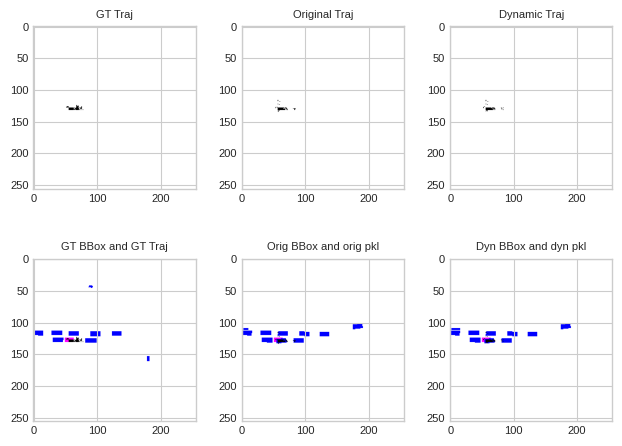

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

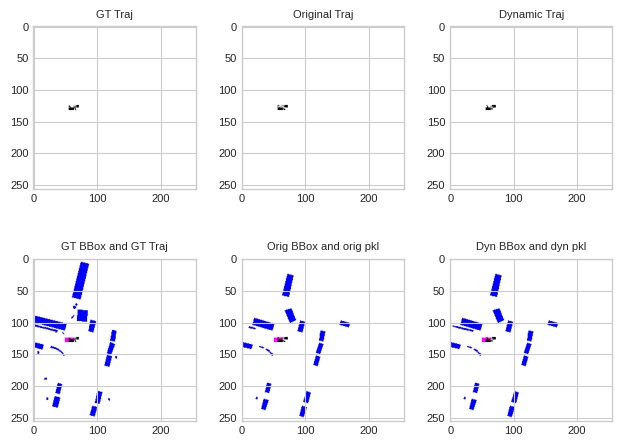

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

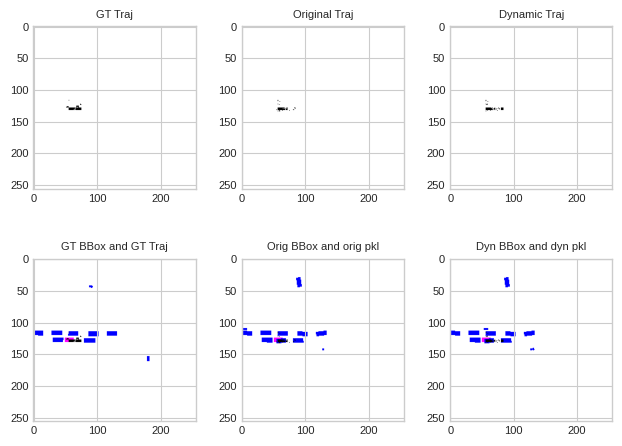

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

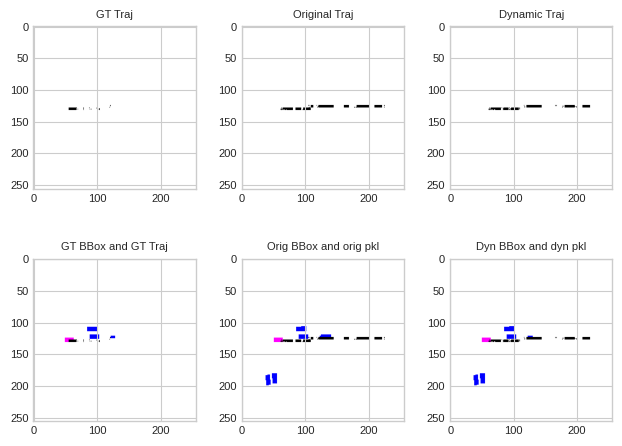

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

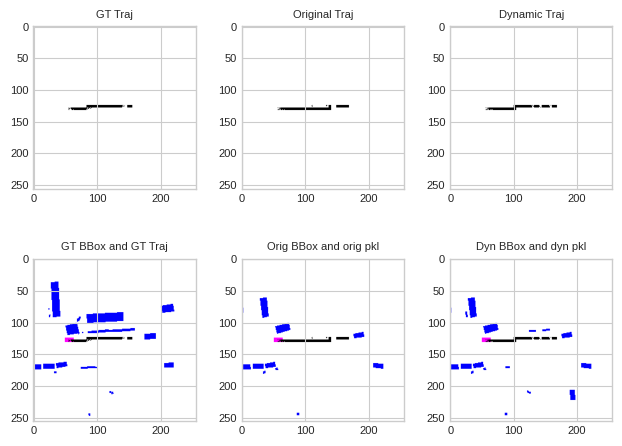

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

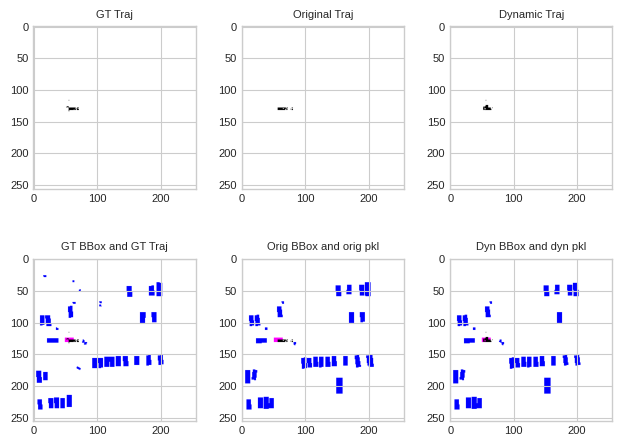

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

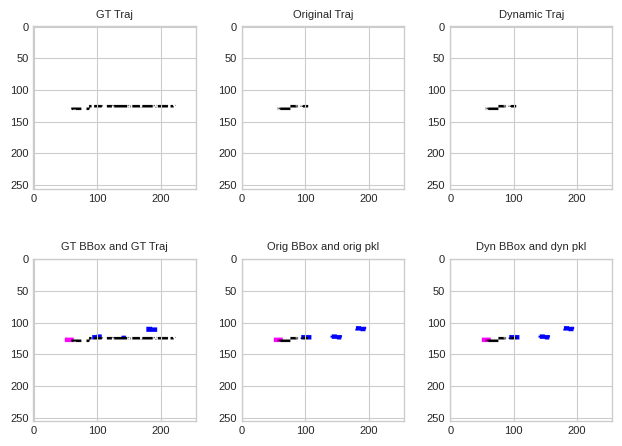

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

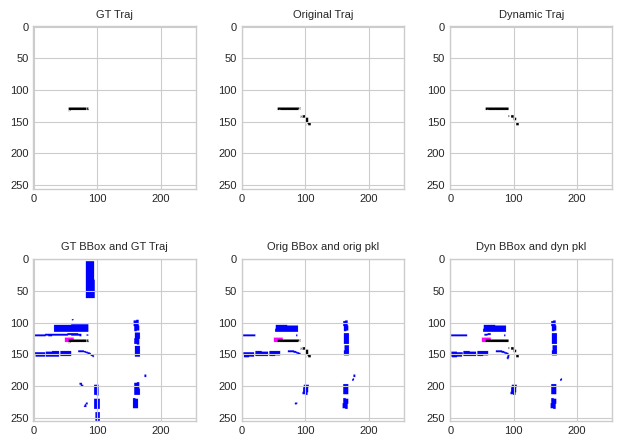

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

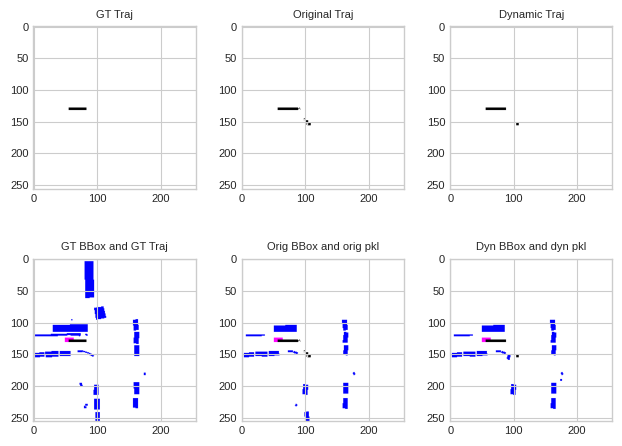

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

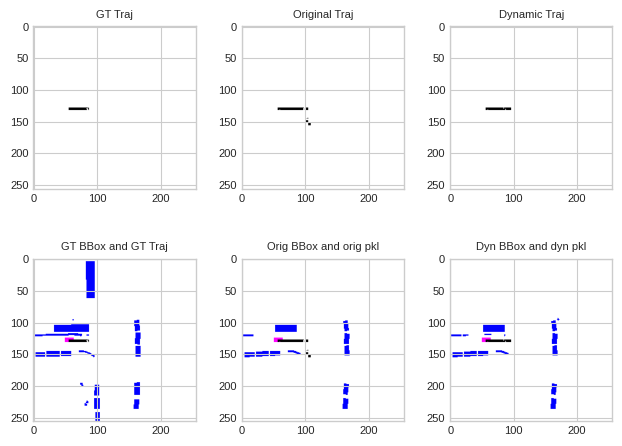

In [56]:
images_to_show=[item[0] for item in original_max]

#first we consider worst cases with original pkl
pklfile_original, info_original, all_pkls_original, gtdist,preddist_original,gtxs, predxs_original, \
createdimages_original, gt_boxes,nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);

pklfile_dynamic, info_dynamic, all_pkls_dynamic, gtdist,preddist_dynamic,gtxs, predxs_dynamic, \
createdimages_dynamic, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);


%matplotlib inline
for token_original, token_dynamic in zip(createdimages_original,createdimages_dynamic):
    #get the ground truth bboxes
    sGT=token_original['heat_gt']
    ground_truths=token_original['gtx'].cpu().detach().numpy()[3]
    ego=token_original['gtx'].cpu().detach().numpy()[4]
    
    #get the ground truth trajectory
    trajectory_gt=computetrajectory(sGT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    
    #get the predicted original bboxes
    sPT=token_original['heat_pt']
    original_detections=token_original['ptx'].cpu().detach().numpy()[3]
    
    #get the predicted original trajectories
    trajectory_pt=computetrajectory(sPT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    
    #get the predicted dynamic (our approach) bboxes
    sDT=token_dynamic['heat_pt']
    dynamic_detections=token_dynamic['ptx'].cpu().detach().numpy()[3]

    #get the predicted dynamic (our approach) trajectories
    trajectory_dt=computetrajectory(sDT.copy(), number_of_trajectory_poses, TRAJ_POINTS)


    plt.clf()
    printfigure3x2(font,#font
                   trajectory_gt,#trajectory ground truth
                   trajectory_pt,#trajectory predicted by original pkl
                   trajectory_dt,#trajectory predicted by our approach to pkl
                   ground_truths,#ground truth position of objects
                   original_detections,#position of objects detected by original approach
                   dynamic_detections,#position of objects detected by our approach (threshold filtering)
                   ego
                  )


**k frame where dynamic function has maximum pkl**

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

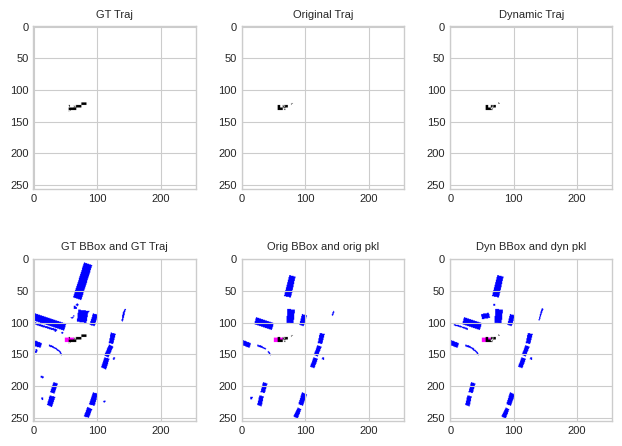

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

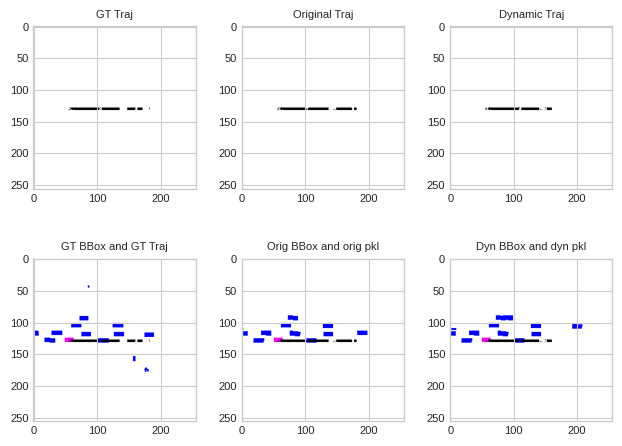

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

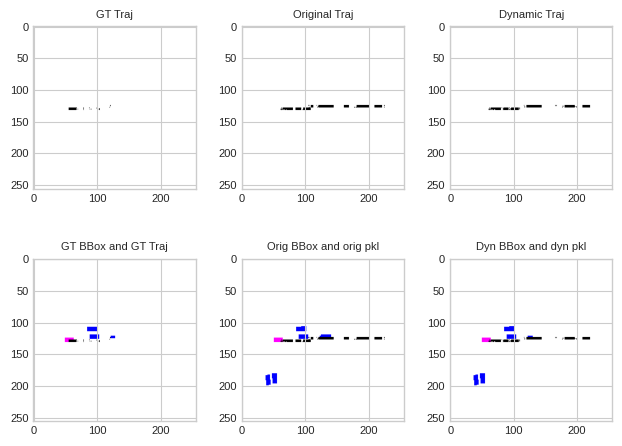

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

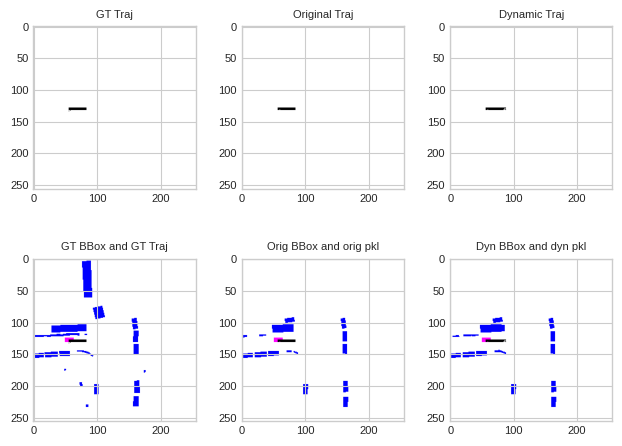

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

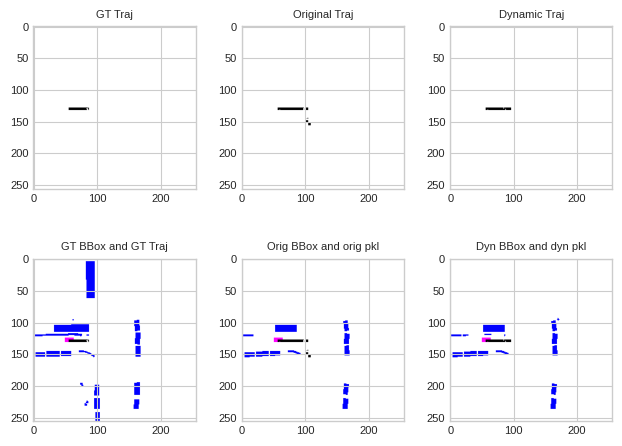

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

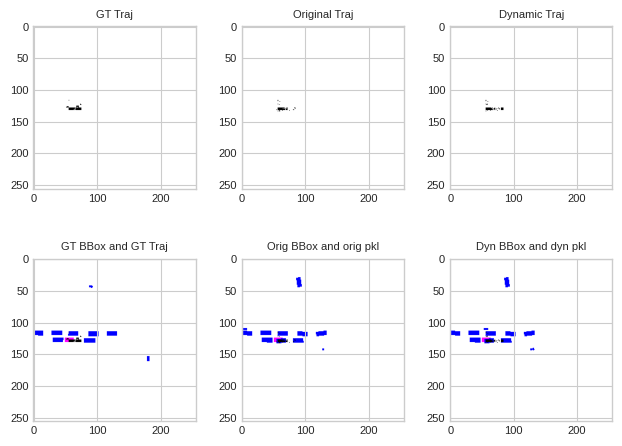

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

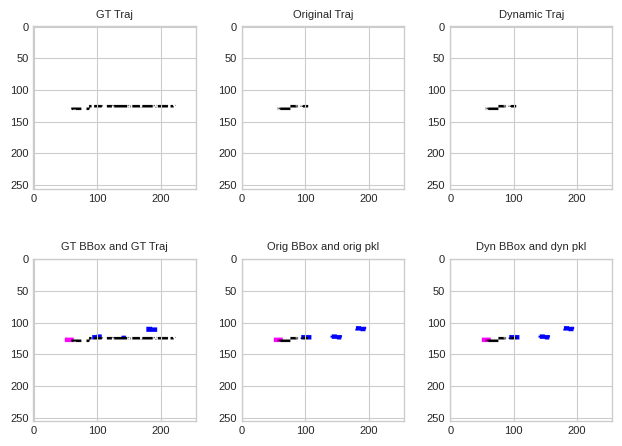

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

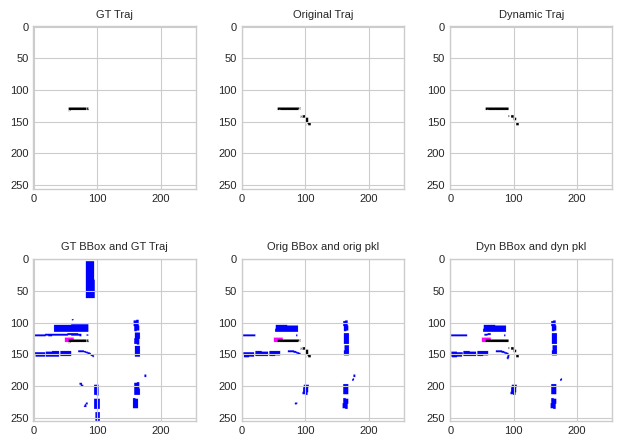

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

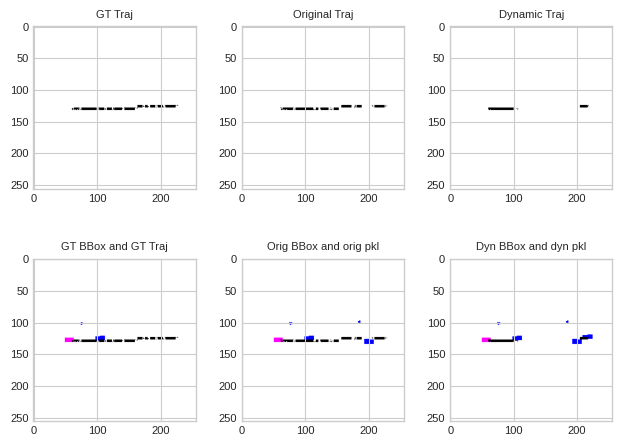

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

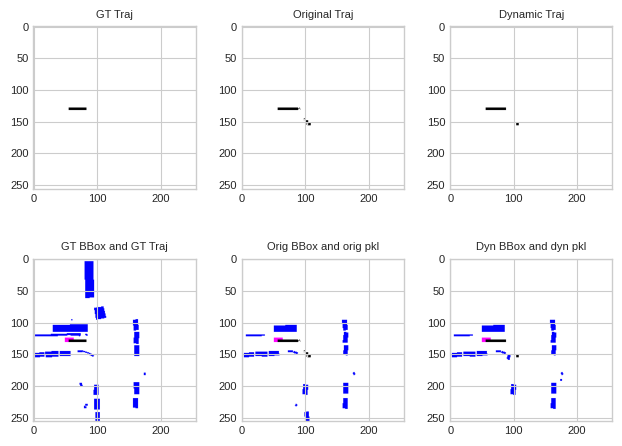

In [57]:
images_to_show=[item[0] for item in dynamic_max]

#first we consider worst cases with original pkl
pklfile_original, info_original, all_pkls_original, gtdist,preddist_original,gtxs, predxs_original, \
createdimages_original, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);

pklfile_dynamic, info_dynamic, all_pkls_dynamic, gtdist,preddist_dynamic,gtxs, predxs_dynamic, \
createdimages_dynamic, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);

%matplotlib inline
for token_original, token_dynamic in zip(createdimages_original,createdimages_dynamic):
    #get the ground truth bboxes
    sGT=token_original['heat_gt']
    ground_truths=token_original['gtx'].cpu().detach().numpy()[3]
    ego=token_original['gtx'].cpu().detach().numpy()[4]
    #ground_truths=np.swapaxes(ground_truths,0,1)
    
    #get the ground truth trajectory
    trajectory_gt=computetrajectory(sGT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_gt=np.swapaxes(trajectory_gt, 0,1)   
    
    #get the predicted original bboxes
    sPT=token_original['heat_pt']
    original_detections=token_original['ptx'].cpu().detach().numpy()[3]
    #original_detections=np.swapaxes(original_detections,0,1)
    
    #get the predicted original trajectories
    trajectory_pt=computetrajectory(sPT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_pt=np.swapaxes(trajectory_pt, 0,1)
    
    #get the predicted dynamic (our approach) bboxes
    sDT=token_dynamic['heat_pt']
    dynamic_detections=token_dynamic['ptx'].cpu().detach().numpy()[3]
    #dynamic_detections=np.swapaxes(dynamic_detections,0,1)

    #get the predicted dynamic (our approach) trajectories
    trajectory_dt=computetrajectory(sDT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_dt=np.swapaxes(trajectory_dt, 0,1)


    plt.clf()
    printfigure3x2(font,#font
                   trajectory_gt,#trajectory ground truth
                   trajectory_pt,#trajectory predicted by original pkl
                   trajectory_dt,#trajectory predicted by our approach to pkl
                   ground_truths,#ground truth position of objects
                   original_detections,#position of objects detected by original approach
                   dynamic_detections,#position of objects detected by our approach (threshold filtering)
                   ego
                  )


**n frame with maximum difference between pkl with original function and our modified function (i.e., our modified function is closer to the ground truth)**

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

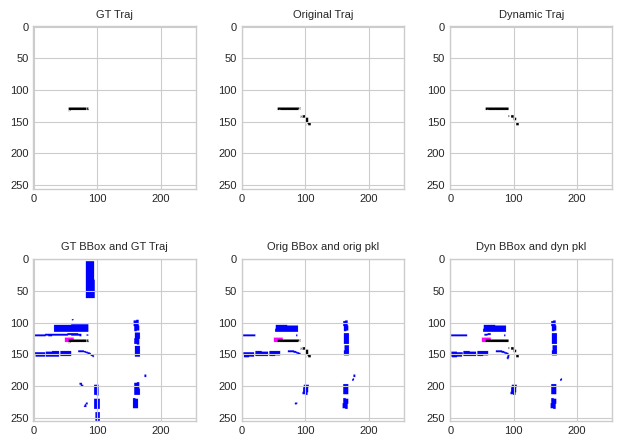

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

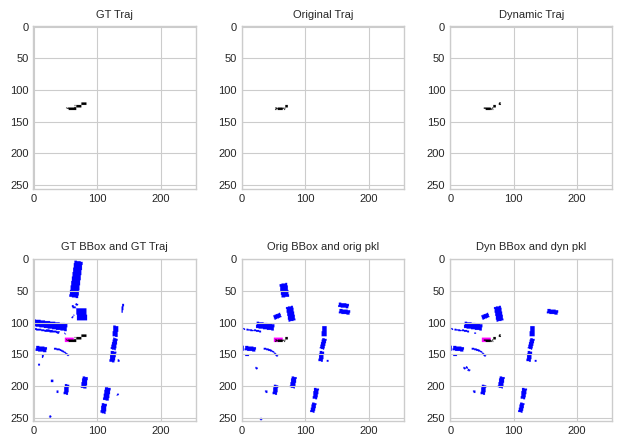

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

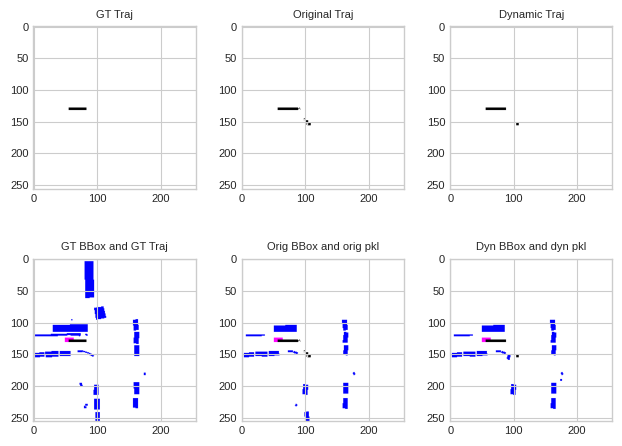

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

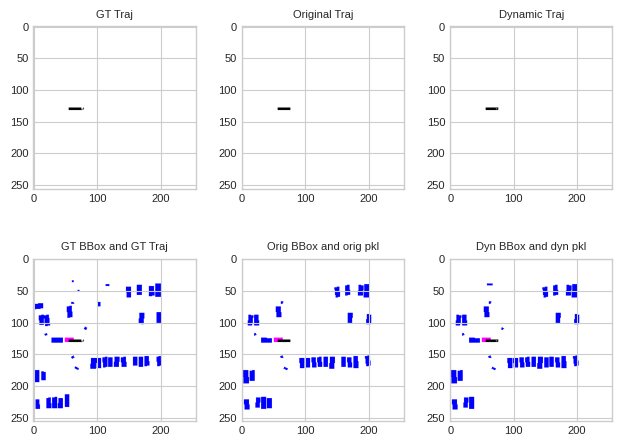

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

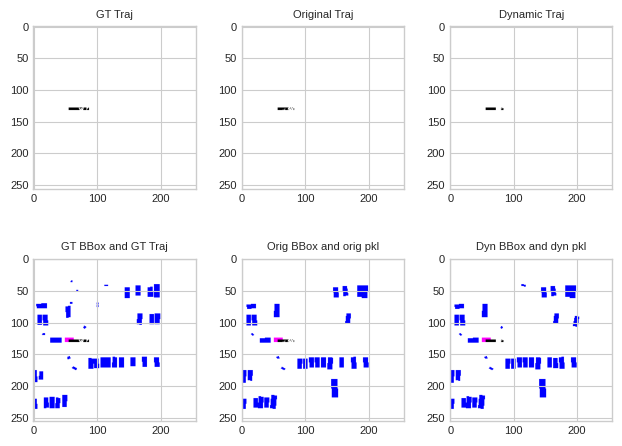

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

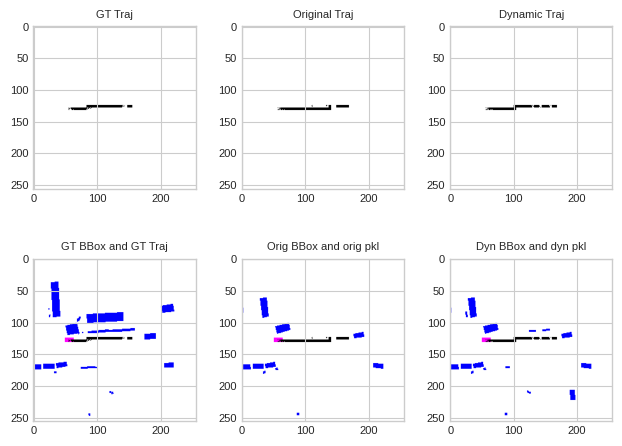

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

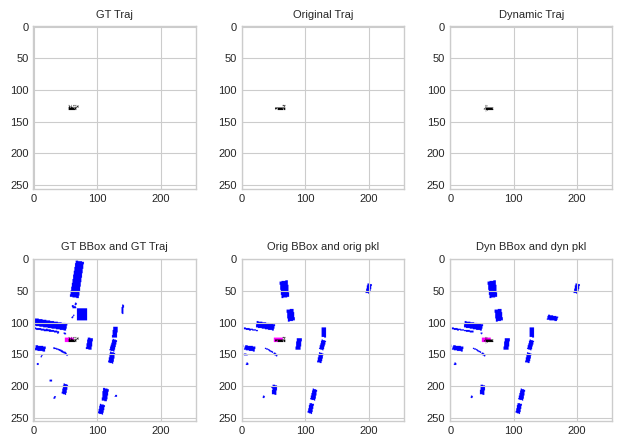

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

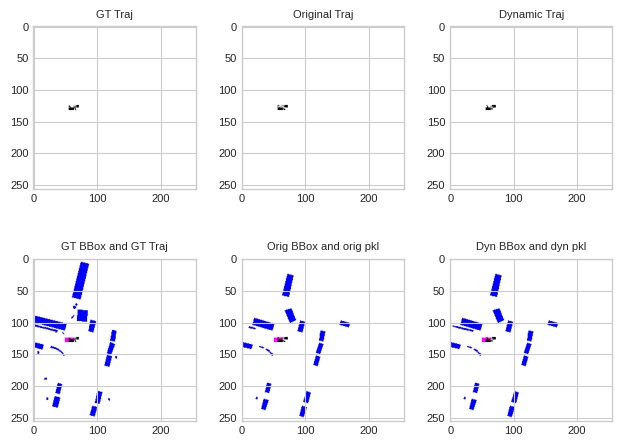

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

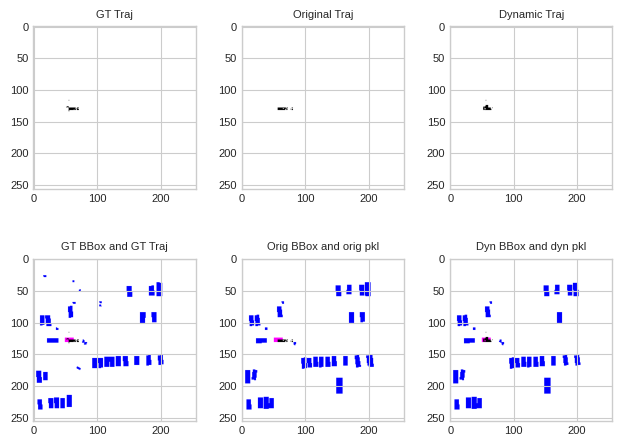

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

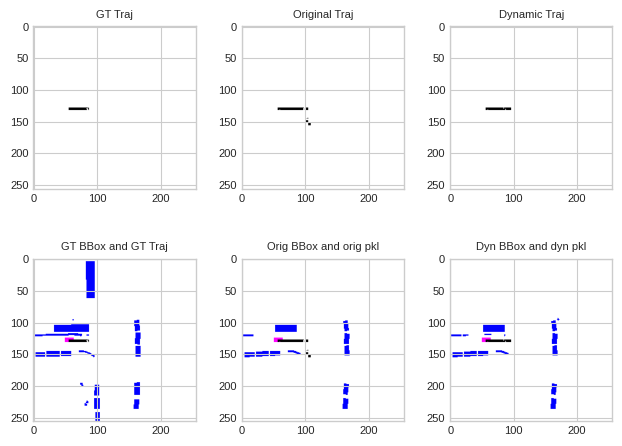

In [58]:
images_to_show=[item[0] for item in max_gain_d_over_o]

#first we consider worst cases with original pkl
pklfile_original, info_original, all_pkls_original, gtdist,preddist_original,gtxs, predxs_original, \
createdimages_original, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);

pklfile_dynamic, info_dynamic, all_pkls_dynamic, gtdist,preddist_dynamic,gtxs, predxs_dynamic, \
createdimages_dynamic, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=images_to_show,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(images_to_show),
                                     verbose=verbose);

%matplotlib inline
for token_original, token_dynamic in zip(createdimages_original, createdimages_dynamic):
    #get the ground truth bboxes
    sGT=token_original['heat_gt']
    ground_truths=token_original['gtx'].cpu().detach().numpy()[3]
    ego=token_original['gtx'].cpu().detach().numpy()[4]
    #ground_truths=np.swapaxes(ground_truths,0,1)
    
    #get the ground truth trajectory
    trajectory_gt=computetrajectory(sGT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_gt=np.swapaxes(trajectory_gt, 0,1)   
    
    #get the predicted original bboxes
    sPT=token_original['heat_pt']
    original_detections=token_original['ptx'].cpu().detach().numpy()[3]
    #original_detections=np.swapaxes(original_detections,0,1)
    
    #get the predicted original trajectories
    trajectory_pt=computetrajectory(sPT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_pt=np.swapaxes(trajectory_pt, 0,1)
    
    #get the predicted dynamic (our approach) bboxes
    sDT=token_dynamic['heat_pt']
    dynamic_detections=token_dynamic['ptx'].cpu().detach().numpy()[3]
    #dynamic_detections=np.swapaxes(dynamic_detections,0,1)

    #get the predicted dynamic (our approach) trajectories
    trajectory_dt=computetrajectory(sDT.copy(), number_of_trajectory_poses, TRAJ_POINTS)
    #trajectory_dt=np.swapaxes(trajectory_dt, 0,1)

    plt.clf()
    printfigure3x2(font,#font
                   trajectory_gt,#trajectory ground truth
                   trajectory_pt,#trajectory predicted by original pkl
                   trajectory_dt,#trajectory predicted by our approach to pkl
                   ground_truths,#ground truth position of objects
                   original_detections,#position of objects detected by original approach
                   dynamic_detections,#position of objects detected by our approach (threshold filtering)
                   ego
                  )


**Understand if there are safety violations**

We want to plot "up to 4 seconds": we do not apply on the 20 seconds length, but only on the first 12 seconds of each sequence.

We see if the projected position of the ego vehicle in 4 seconds will lead to an overlap with the ground truth objects.

- For the ground truth pkl
- the pkl using the bbox predicted with the original function.
- the pkl using the bbox predicted with our modified function.

In [59]:
seconds=4

we first compute pkls for all val set considered

In [60]:
len(alltoken)

403

In [61]:
'''pklfile_original, info_original, all_pkls_original, gtdist,preddist_original,gtxs, predxs_original, \
createdimages_original, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=alltoken,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(alltoken),
                                     verbose=verbose);

pklfile_dynamic, info_dynamic, all_pkls_dynamic, gtdist,preddist_dynamic,gtxs, predxs_dynamic, \
createdimages_dynamic, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=alltoken,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(alltoken),
                                     verbose=verbose);
''';

we retrieve the nuscene scenes of interest

In [62]:
#retrieve initial token of each nuscene scene in val
#Elements as:
#{'token': '41fde20fedcd4d22ab26811688612870',
#  'log_token': 'd31dc715d1c34b99bd5afb0e3aea26ed',
#  'nbr_samples': 40,
#  'first_sample_token': 'b9c60cfaf1814c8bb363037dec7abd35',
#  'last_sample_token': '51f7ea7d3e4e42dfaf183dbe9996f1fb',
#  'name': 'scene-0013',
#  'description': 'Follow bus, parked cars, trash cans, parked bicycles, nature'},

nuscenes_sequences=[]

for i in nuscenes.scene:
    if (i['name'] in val):
        nuscenes_sequences.append(i)    

for each token, we compute the successive 8 and we perform the "do_computation" that does essentially everything

In [63]:
#get the samples that follows my_selected_sample, for the defined seconds
def get_following_tokens(seconds, initial_token, sample):
    to_retrieve=seconds*2
    sequence_tokens=[] #list of tokens in sequences

    sequence_tokens.append(initial_token)
    for i in range(0, to_retrieve):
        following_token=sample['next']
        sequence_tokens.append(following_token)
        sample = nuscenes.get('sample', following_token)
    return sequence_tokens

#computes and overlaps all the bboxes
#list of tokens and info complete as from the createdimages_original
def getbboxes(tokens, info):
    return None


In [64]:
def samp2ego(samp, nusc):
    egopose = nusc.get('ego_pose', nusc.get('sample_data',
                                            samp['data']['LIDAR_TOP'])
                       ['ego_pose_token'])
    rot = Quaternion(egopose['rotation']).rotation_matrix
    rot = np.arctan2(rot[1, 0], rot[0, 0])
    return {
                'x': egopose['translation'][0],
                'y': egopose['translation'][1],
                'hcos': np.cos(rot),
                'hsin': np.sin(rot),
                'l': 4.084,
                'w': 1.73,
            }

#example output:
#samp2ego(nusc.get('sample', listtoken[1]), nusc)

#{'x': 1663.7830538752974,
# 'y': 1254.2029068912966,
# 'hcos': 0.4754610435577135,
# 'hsin': 0.8797367765752492,
# 'l': 4.084, #ego dimensions
# 'w': 1.73} #ego dimensions


In [65]:
#return the sum of all ground truth positions in the considered tokens, with respect to ego
def collect_x_gt(sample_tokens, #here put all the X tokens that we need to consider,
                 #the token with ego is the first token
              ego,            
              nusc,
              gt_boxes,
              nusc_maps,
              stretch=120,
              layer_names=['road_segment', 'lane'],
              line_names=['road_divider', 'lane_divider'],
              nx=256, ny=256, 
              bx=np.array([-16.85, -38.35]),
              dx=np.array([0.3, 0.3])):
    
    samp = nusc.get('sample', sample_tokens[0])
    # local map
    map_name = samp2mapname(samp, nusc)
    lmap = get_local_map(nusc_maps[map_name],
                             [ego['x'], ego['y'], ego['hcos'], ego['hsin']],
                             stretch, layer_names, line_names)    
    
    gtlobjs=np.empty((10000,4))
    gtlws=np.empty((10000, 2))
    counter=0
    for i in sample_tokens:
        sample_token=i
        samp = nusc.get('sample', sample_token)

        # ground truths bboxes
        gtlobjs_tmp, gtlws_tmp = get_other_objs(gt_boxes[sample_token],
                                        np.array([ego['x'], ego['y'],
                                                  ego['hcos'], ego['hsin']]))
        
        length=gtlobjs_tmp.shape[0]
        
        gtlobjs[counter:(counter+length)]=gtlobjs_tmp
        gtlws[counter:(counter+length)]=gtlws_tmp
        counter=counter+length

    gtlobjs=gtlobjs[0:counter]
    gtlws=gtlws[0:counter]
    # render
    gtx = raster_render(lmap, [ego['l'], ego['w']], gtlobjs, gtlws,
                            nx, ny, layer_names, line_names,
                            bx, dx)

    return gtx

#true if there are overlaps between the black area in a and b
#very simple:black zones becomes equal to 10
#if there is a 20, it means there is an overlap between images
def compute_overlaps(a, b):
    image=np.add(a, b)
    if(np.max(np.unique(image))==2):
        return True, image

    return False, image


#a = sum of ground truth
#b = trajectory computed 
def save_results(a, b, token, string):
    a[a==1]=0.5
    image=np.add(a, b)#ground truth light grey, trajectory in black
    with open(RESULTS_PATH+"/"+selected_detector+"/"+str(token)+"_"+str(string)+'.npy', 'wb') as f:
        np.save(f, image)


In [66]:
#tokens is the list of "seconds*2" consecutive frames
#(should be 8 frames from nuscenes)
#computes overlaps in 1-seconds slots
def do_computation(tokens,
                   info_original,
                   all_original,
                   info_dynamic,
                   all_dynamic,
                   dx, bx, nx, ny, stretch, nusc, nusc_maps, gt_boxes
                  ):
    
    #get ego
    samp = nusc.get('sample', tokens[0])
    ego = samp2ego(samp, nusc)

    #get pkl score of the first token
    pkl_measured_original=info_original['full'][tokens[0]]
    pkl_measured_dynamic=info_dynamic['full'][tokens[0]]

    
    #get the ground truth trajectory
    sGT=all_original[0]['heat_gt']
    
    trajectory_pt=computetrajectory(sGT, number_of_trajectory_poses, TRAJ_POINTS)
    
    #get trajectory original
    sPT=all_original[0]['heat_pt']
    trajectory_pt=computetrajectory(sPT, number_of_trajectory_poses, TRAJ_POINTS)

    #get trajectory dynamic
    sDT=all_dynamic[0]['heat_pt']
    trajectory_pt=computetrajectory(sDT, number_of_trajectory_poses, TRAJ_POINTS)
    
    #get the ground_truths bboxes of each token, with respect to ego, and overlap trajectories
    for i in range(0, 9):#frames of nuscenes tokens list
        if(len(tokens)<i+3):#if we are at the end of the nuscene sequence, we do not have 1 second of observation
            break
        j=2*i-1 #the 16 frames of the trajectory planner

        gt_with_respect_to_ego=collect_x_gt(tokens[i:i+3], #1 seconds
                                            ego, nusc, gt_boxes, nusc_maps,
                                            stretch=stretch, 
                                            layer_names=layer_names,
                                            line_names=line_names,
                                            nx=nx, ny=ny, bx=bx, dx=dx)[3]
    
        #gt trajectory and gt bboxes
        trajectory_next_second=computetrajectory_min_max(sGT, minimum=j,
                                                         maximum=j+5, #1 seconds
                                                         number_of_trajectory_poses=16,
                                                         TRAJ_POINTS=TRAJ_POINTS)

        overlap_gt, resulting_image=compute_overlaps(gt_with_respect_to_ego.copy(),
                                                        trajectory_next_second.copy())
    
        if(overlap_gt==True):
            print("overlap is "+str(overlap_gt)+" for token "+str(tokens[0])+ " at iteration i="+str(i))
            save_results(gt_with_respect_to_ego.copy(), trajectory_next_second.copy(), token, "GT BBoxes and GT trajectory")
    
        printfigure4x1(font, overlap_gt, gt_with_respect_to_ego, \
                       trajectory_next_second, resulting_image, all_original, i)

        #original trajectory and gt bboxes
        trajectory_next_second=computetrajectory_min_max(sPT, minimum=j,
                                                         maximum=j+5, #1 seconds
                                                         number_of_trajectory_poses=16,
                                                         TRAJ_POINTS=TRAJ_POINTS)

        overlap_pt, resulting_image=compute_overlaps(gt_with_respect_to_ego.copy(),
                                                        trajectory_next_second.copy())
    
        if(overlap_pt==True):
            print("overlap is "+str(overlap_pt)+" for token "+str(tokens[0])+ " at iteration i="+str(i))
            save_results(gt_with_respect_to_ego.copy(), trajectory_next_second.copy(), token, "GT BBoxes and original PT trajectory")

        printfigure4x1(font, overlap_pt, gt_with_respect_to_ego, \
                       trajectory_next_second, resulting_image, all_original, i)

            
        #dynamic trajectory and gt bboxes
        trajectory_next_second=computetrajectory_min_max(sDT, minimum=j,
                                                         maximum=j+5, #1 seconds
                                                         number_of_trajectory_poses=16,
                                                         TRAJ_POINTS=TRAJ_POINTS)

        overlap_dt, resulting_image=compute_overlaps(gt_with_respect_to_ego.copy(),
                                                        trajectory_next_second.copy())
    
        if(overlap_dt==True):
            print("overlap is "+str(overlap_pt)+" for token "+str(tokens[0])+ " at iteration i="+str(i))
            save_results(gt_with_respect_to_ego.copy(), trajectory_next_second.copy(), token, "GT BBoxes and dynamic DT trajectory")

        printfigure4x1(font, overlap_dt, gt_with_respect_to_ego,trajectory_next_second, \
                       resulting_image, all_original, i)

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

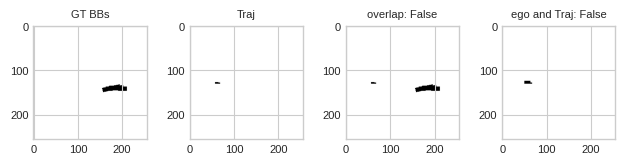

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

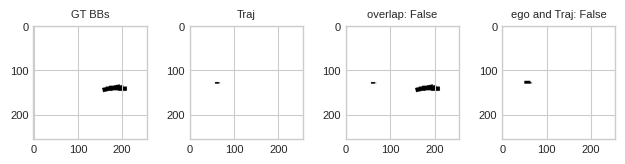

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

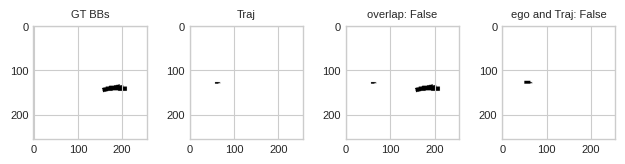

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

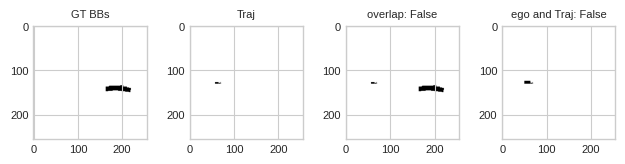

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

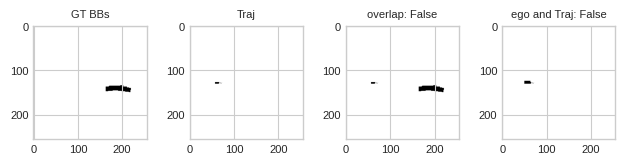

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

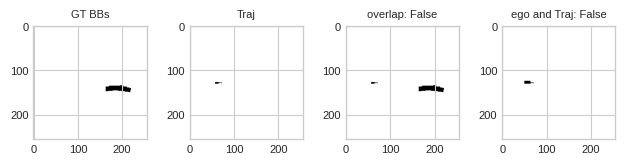

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

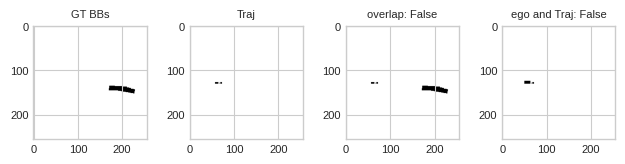

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

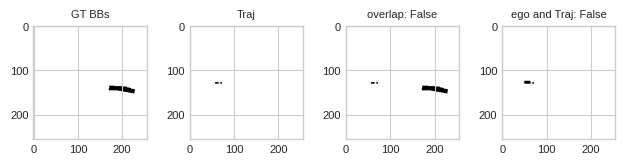

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

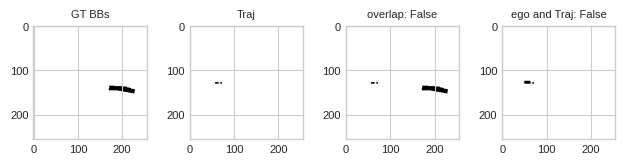

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

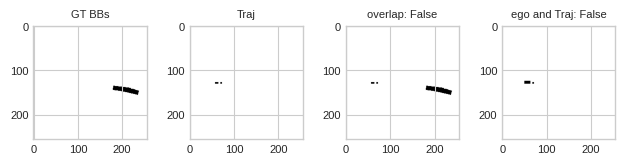

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

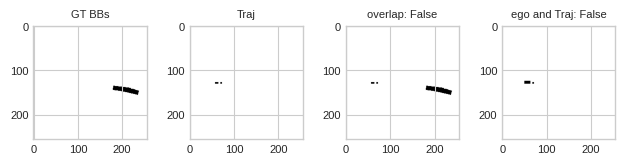

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

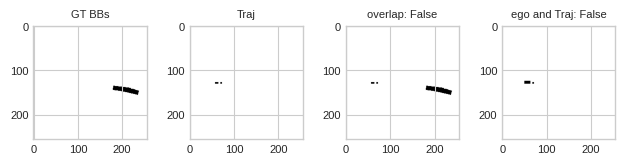

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

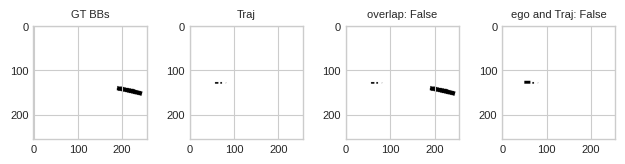

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

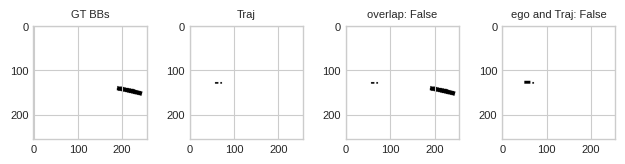

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

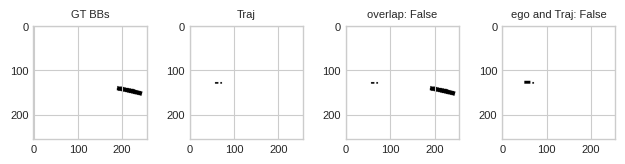

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

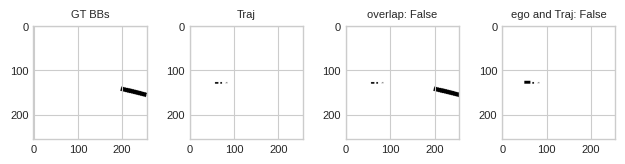

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

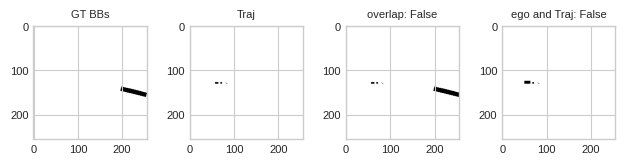

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

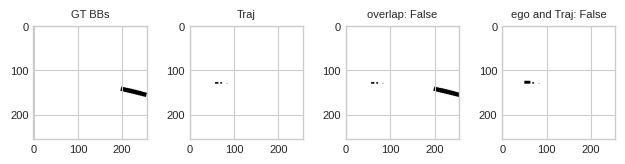

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

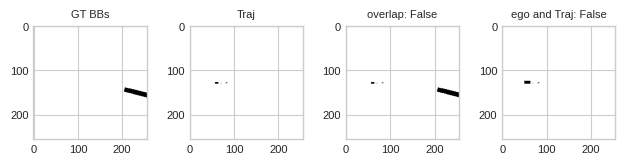

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

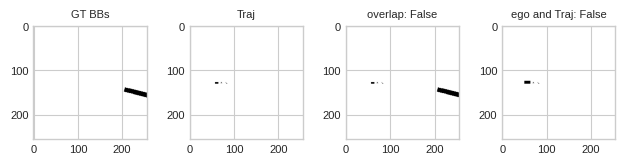

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

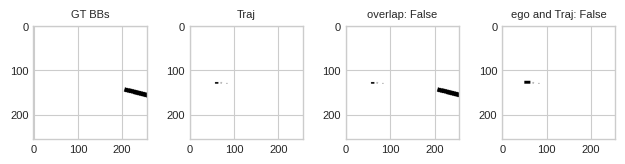

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

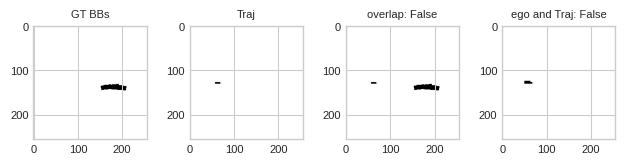

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

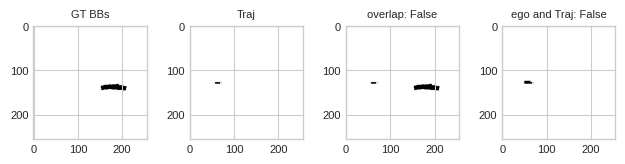

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

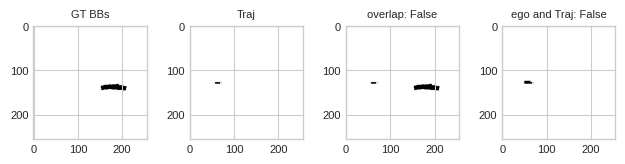

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

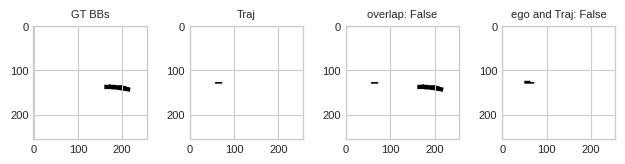

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

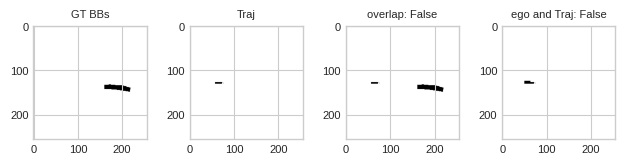

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

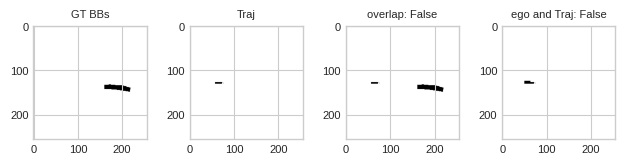

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

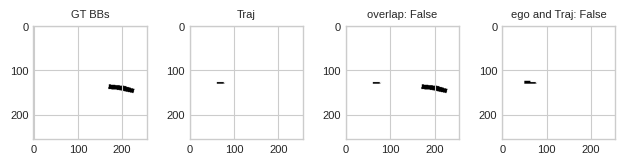

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

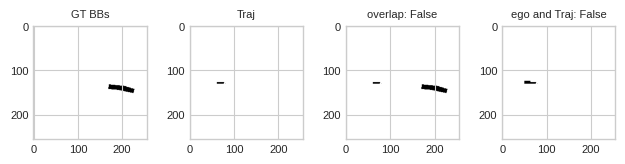

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

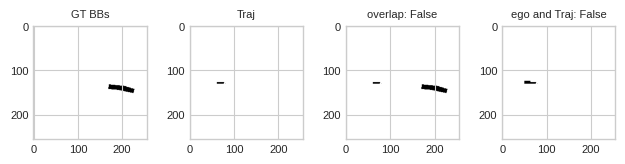

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

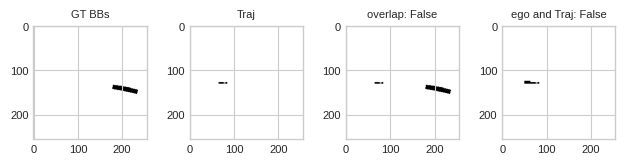

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

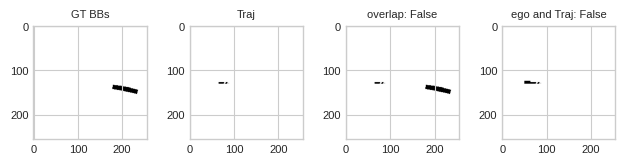

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

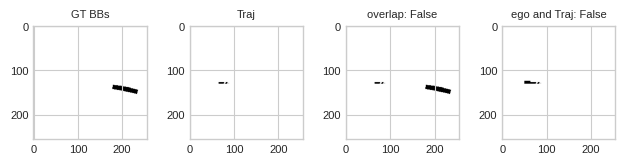

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

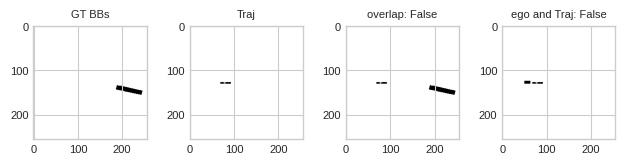

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

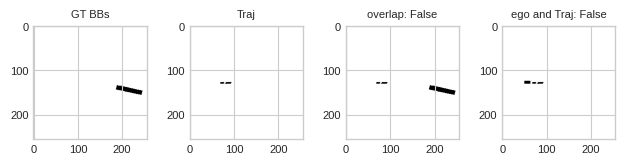

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

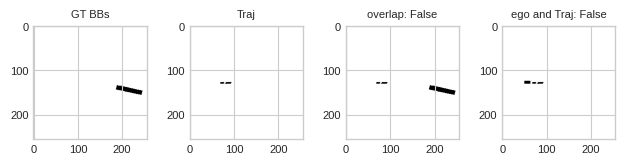

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

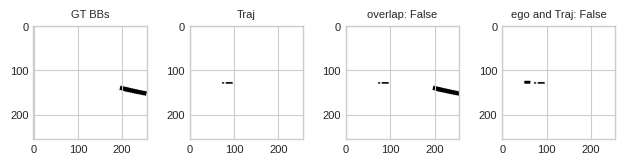

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

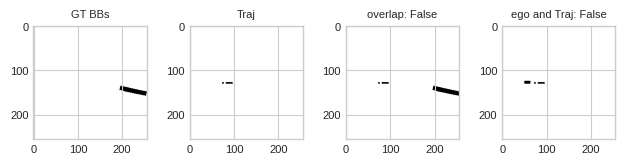

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

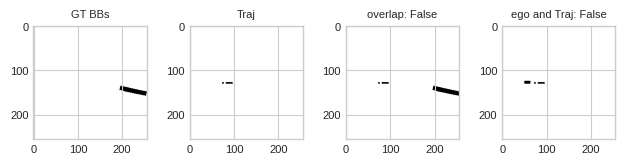

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

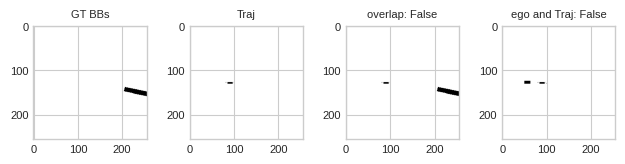

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

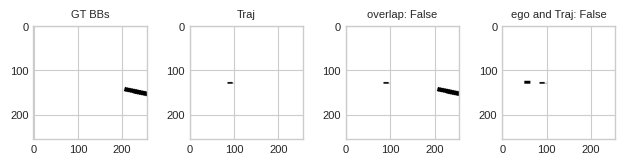

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

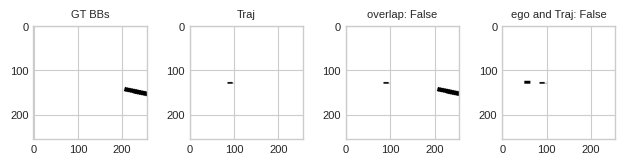

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

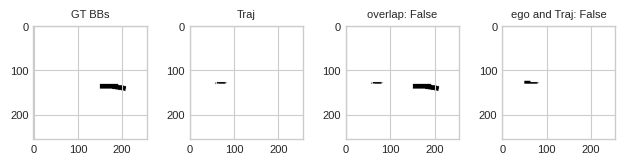

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

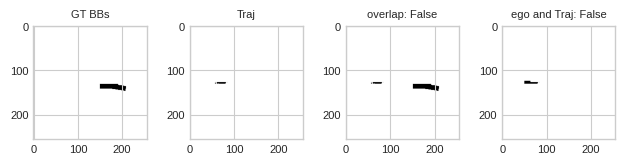

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

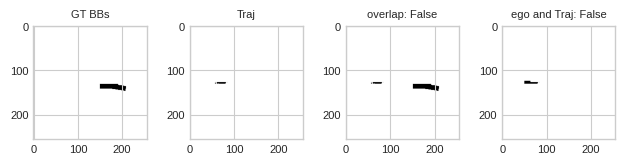

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

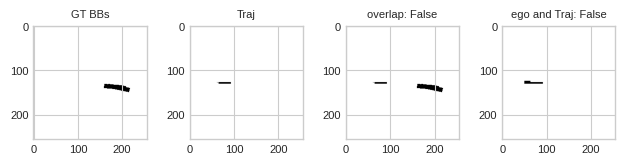

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

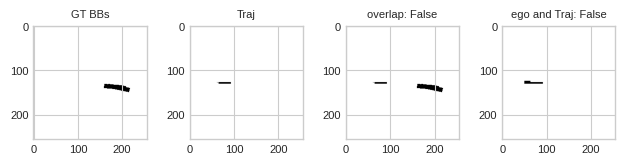

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

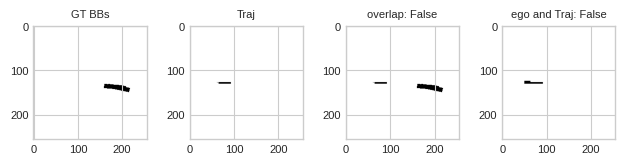

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

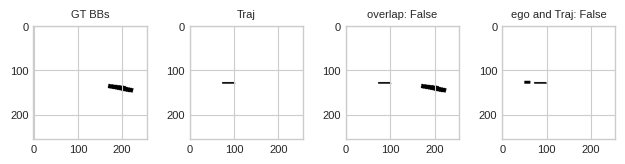

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

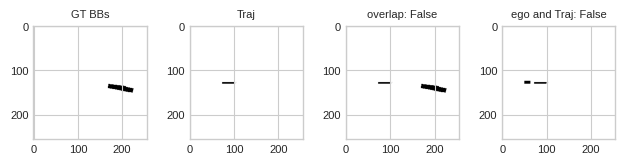

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

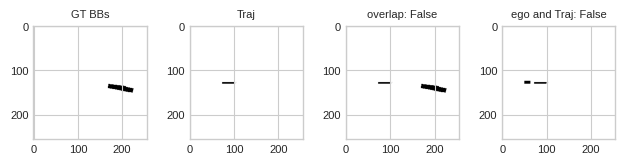

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

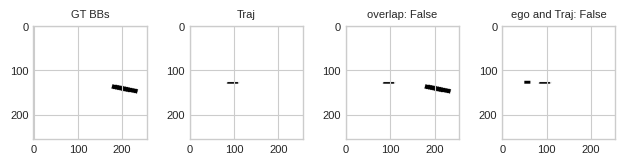

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

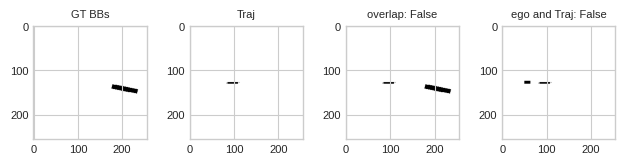

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

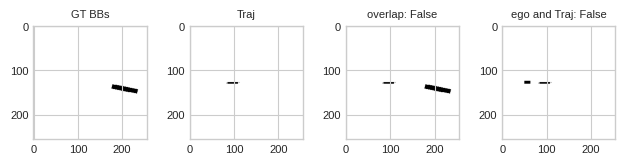

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

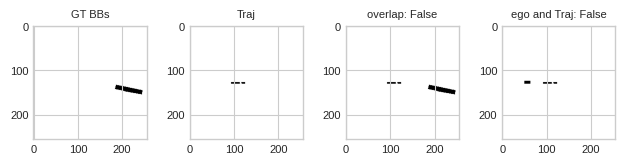

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

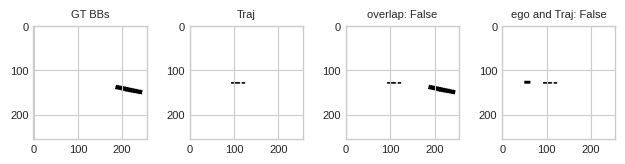

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

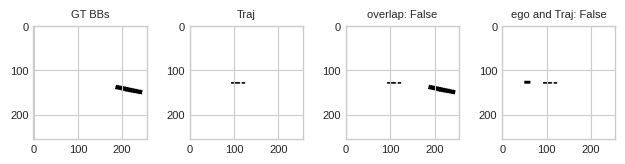

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

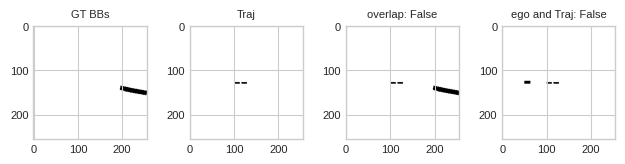

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

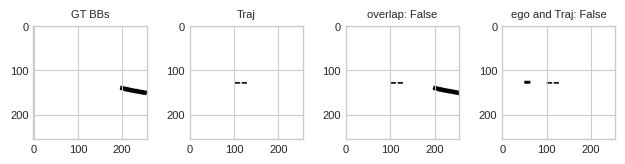

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

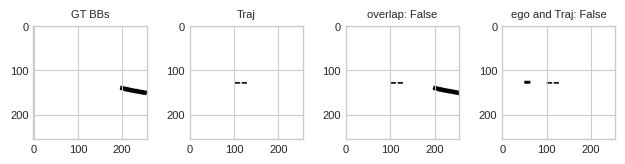

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

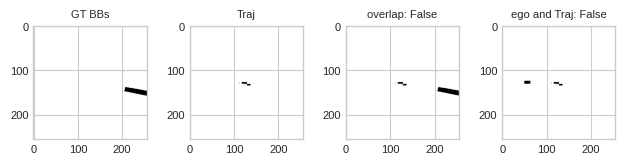

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

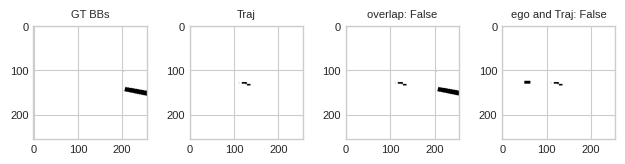

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

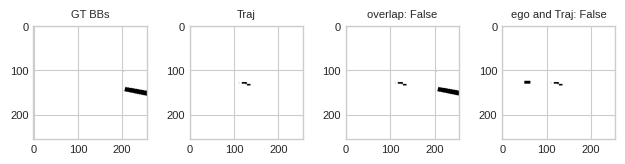

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

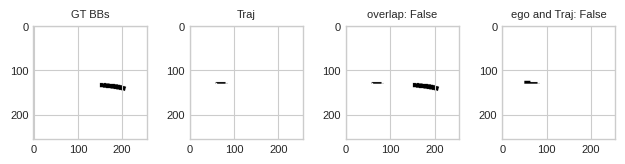

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

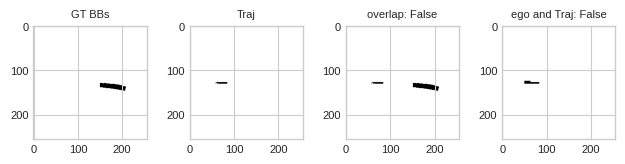

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

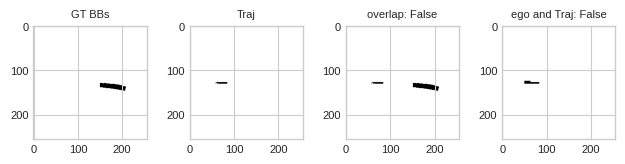

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

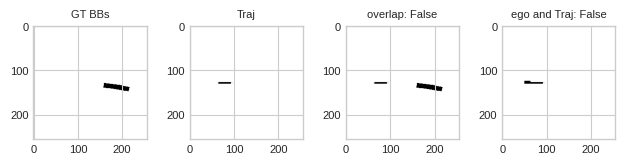

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

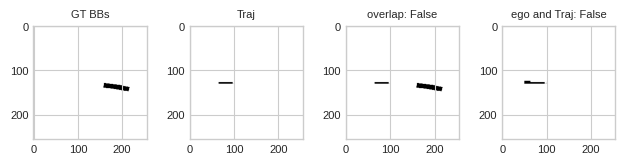

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

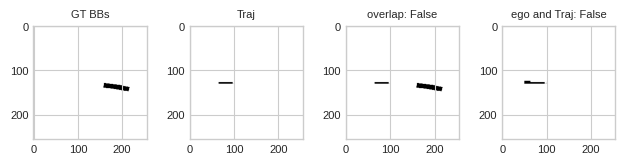

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

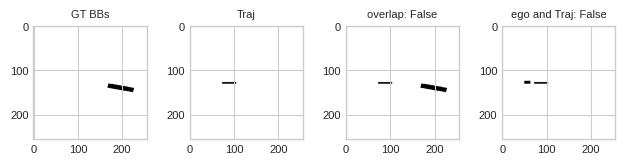

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

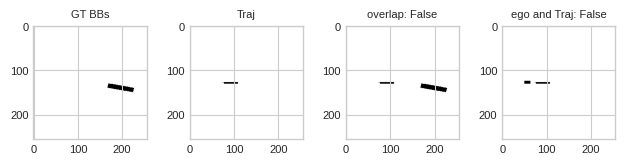

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

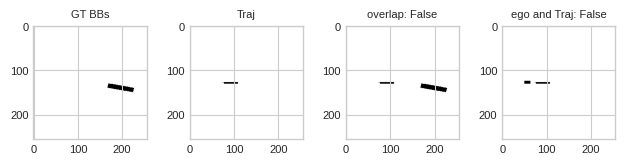

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

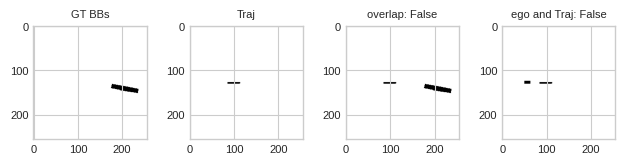

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

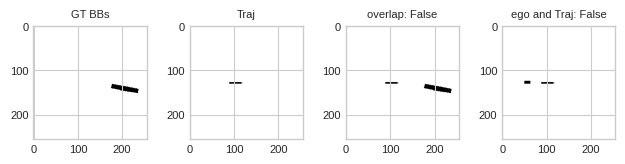

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

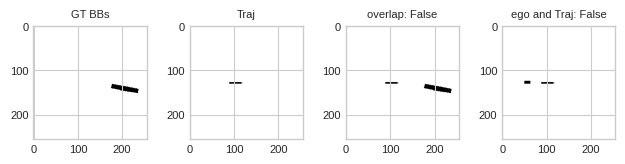

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

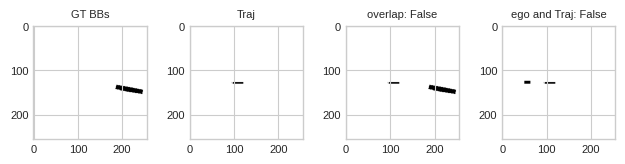

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

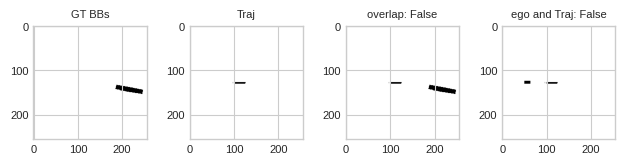

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

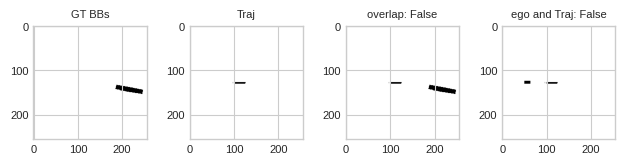

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

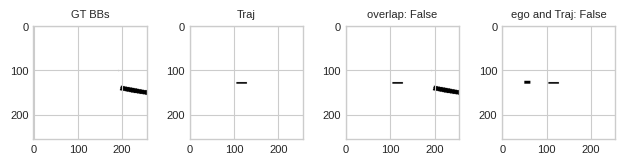

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

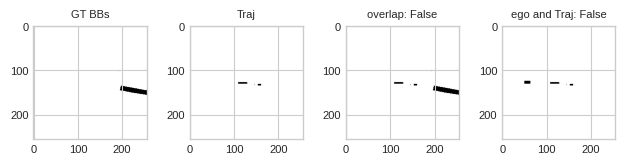

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

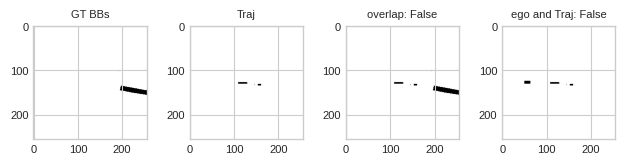

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

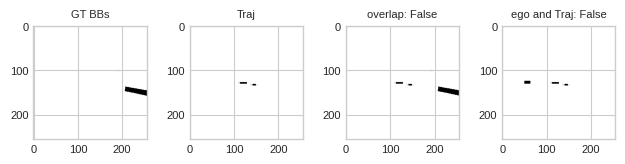

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

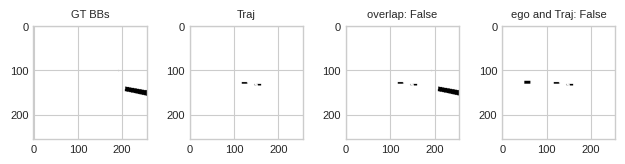

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

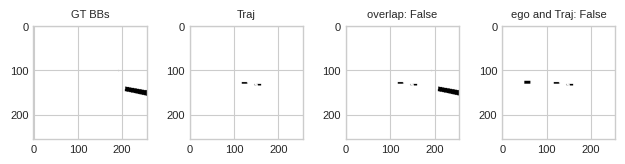

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

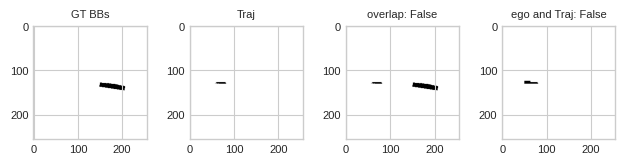

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

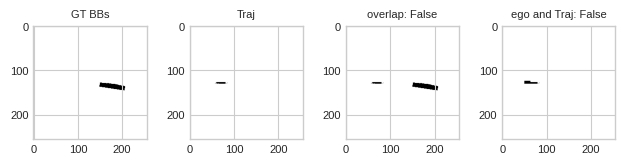

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

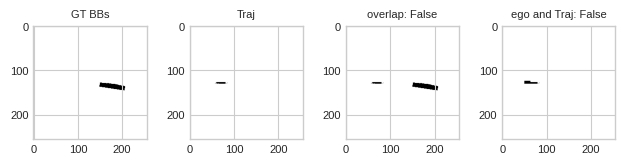

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

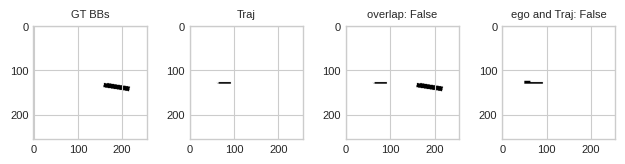

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

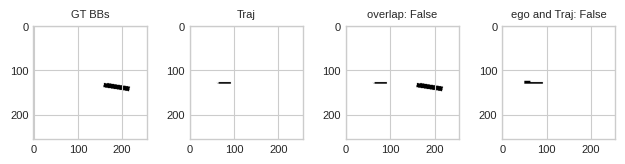

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

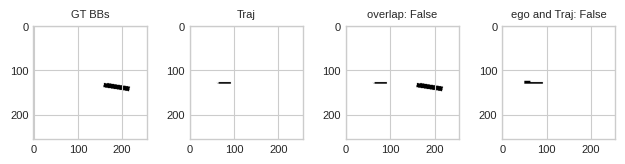

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

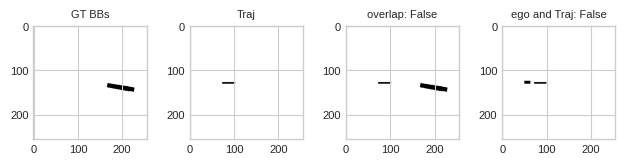

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

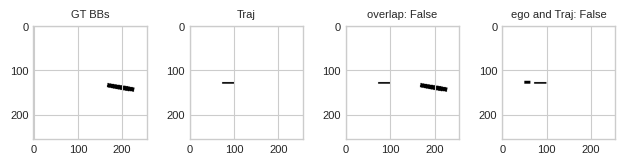

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

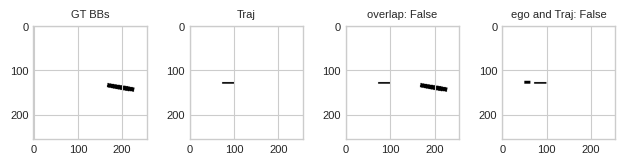

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

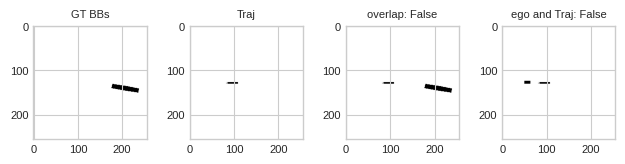

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

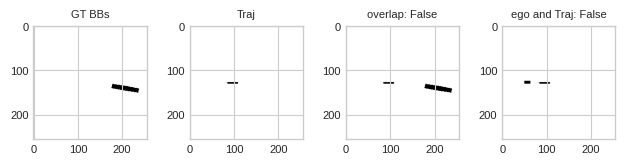

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

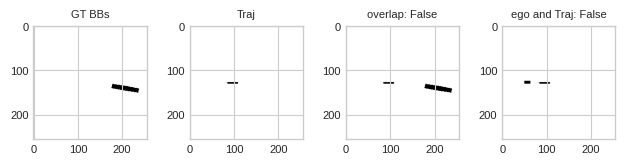

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

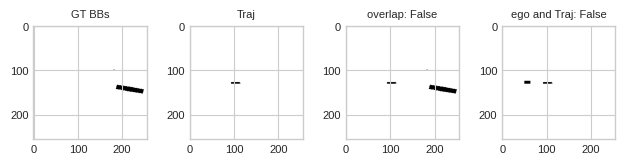

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

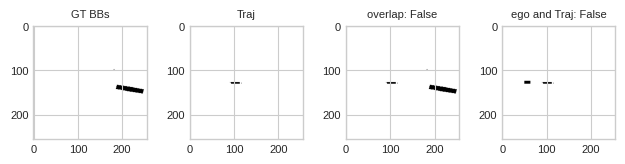

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

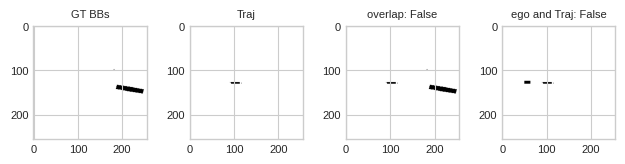

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

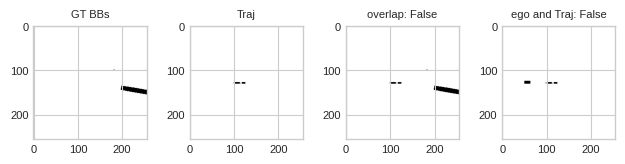

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

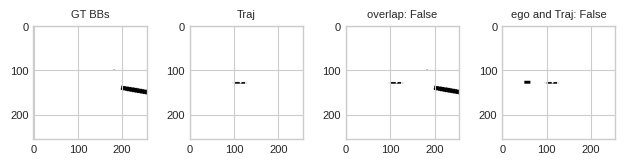

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

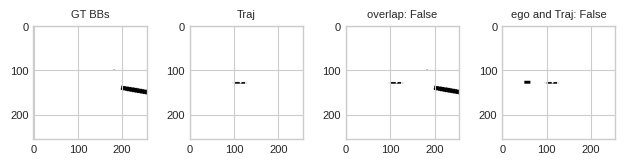

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

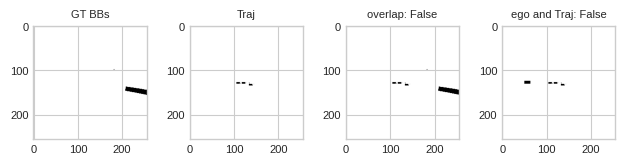

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

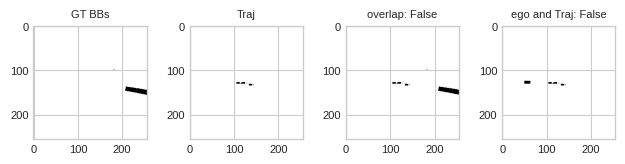

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

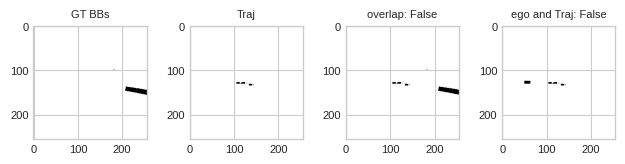

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

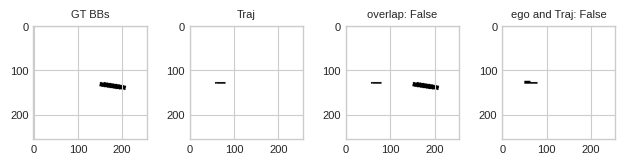

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

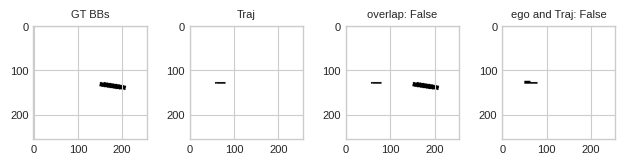

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

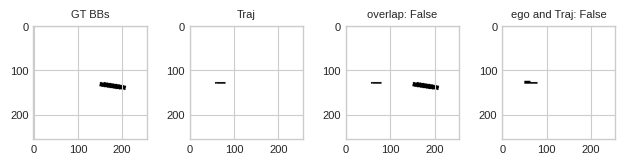

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

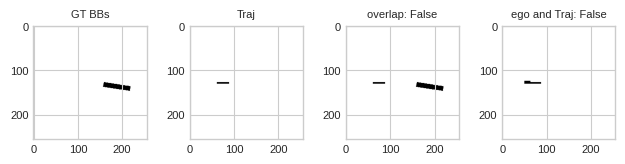

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

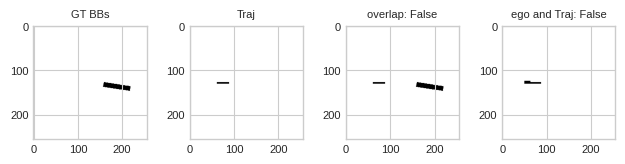

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

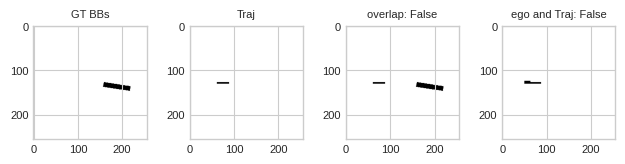

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

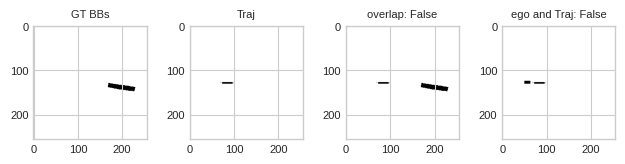

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

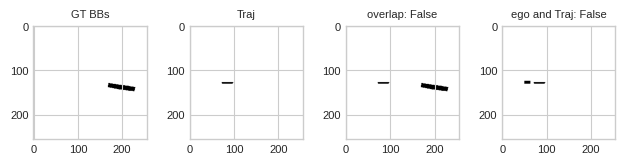

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

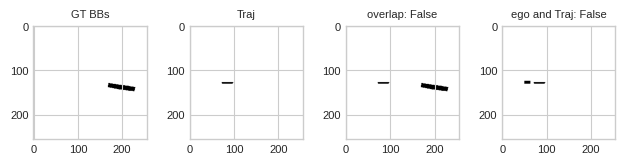

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

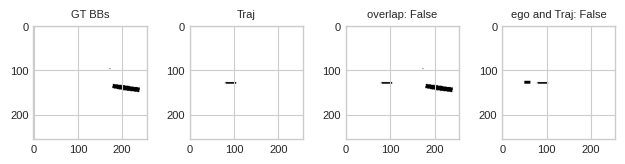

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

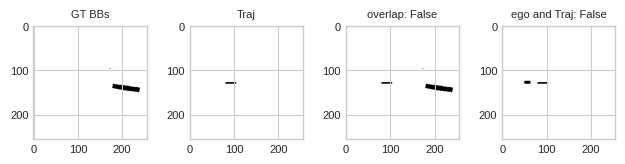

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

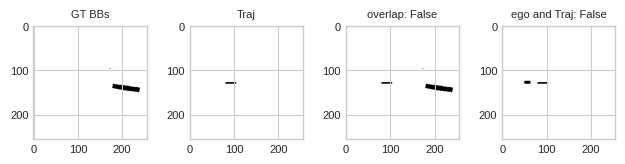

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

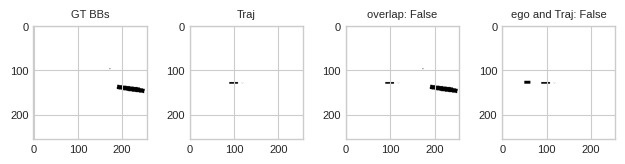

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

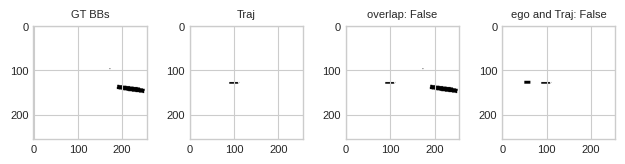

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

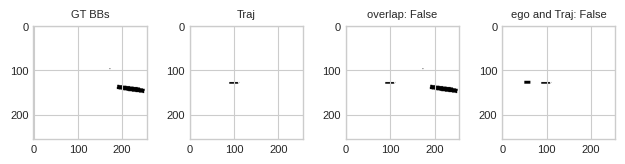

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

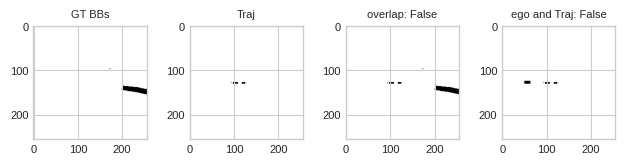

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

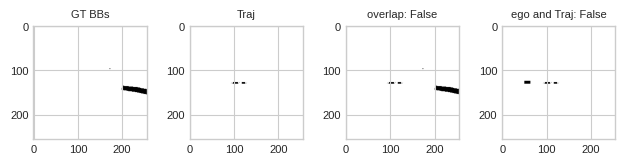

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

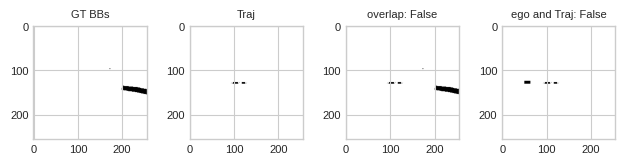

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

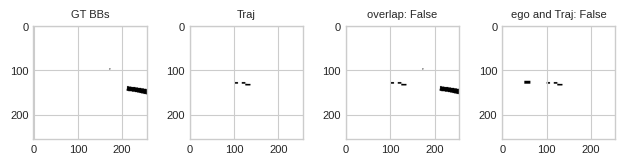

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

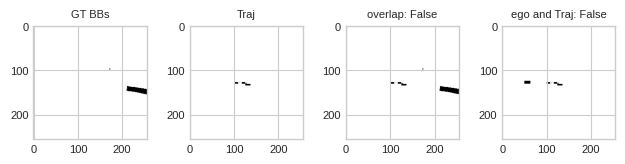

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

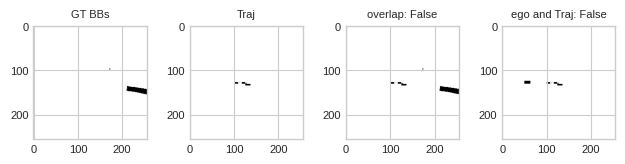

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

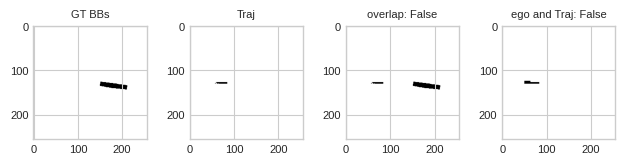

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

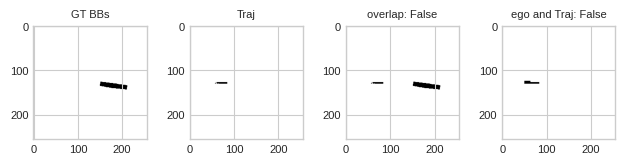

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

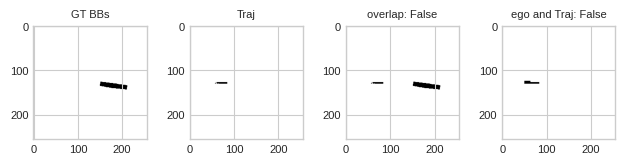

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

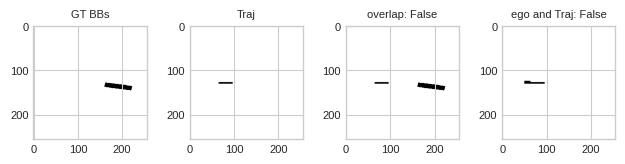

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

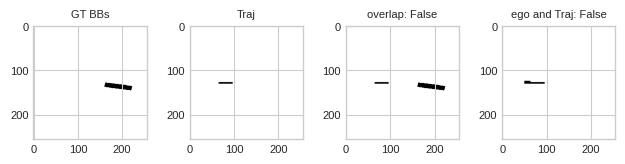

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

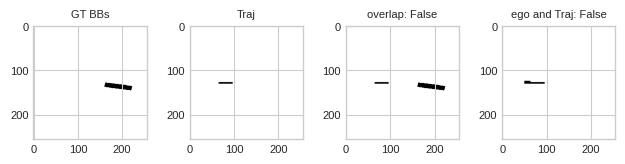

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

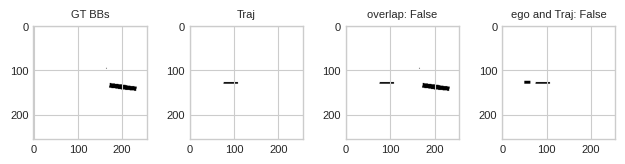

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

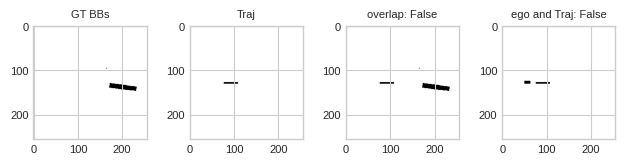

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

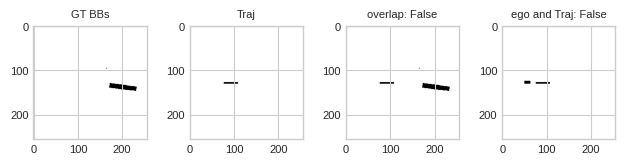

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

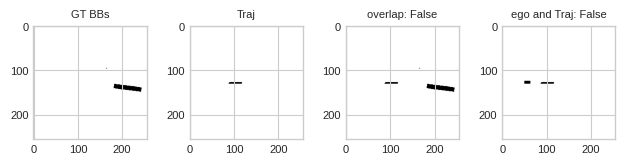

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

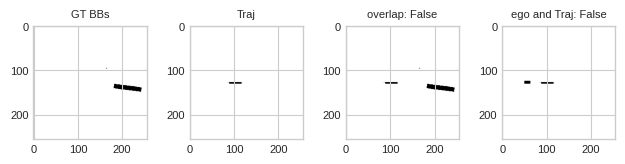

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

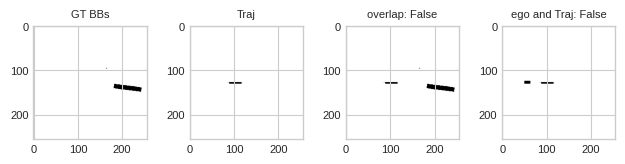

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

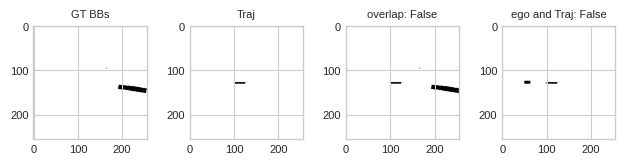

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

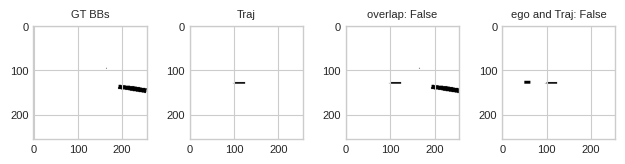

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

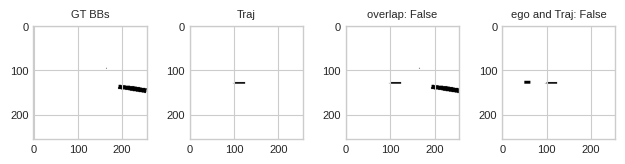

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

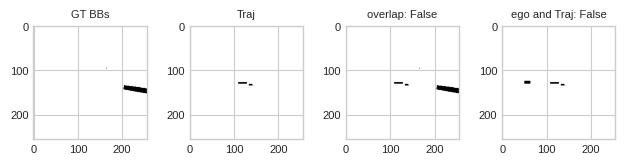

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

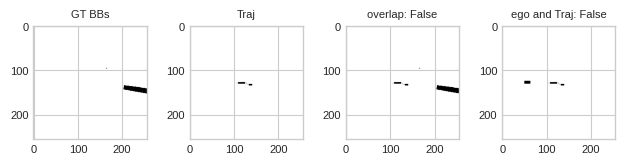

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

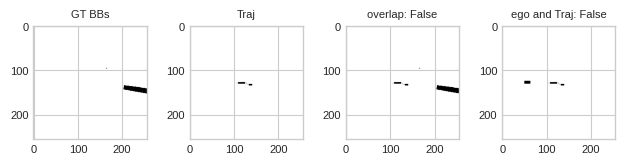

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

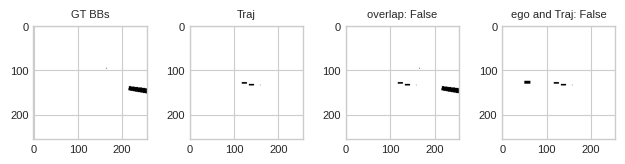

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

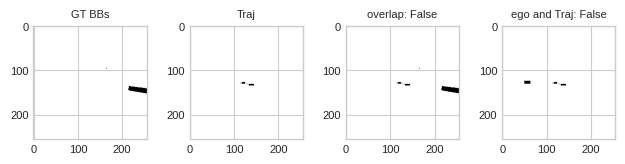

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

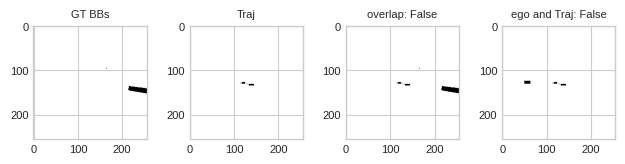

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

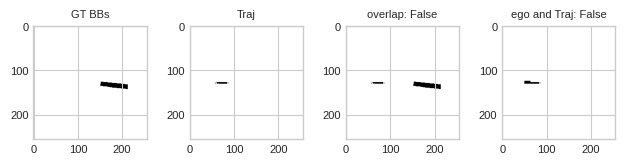

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

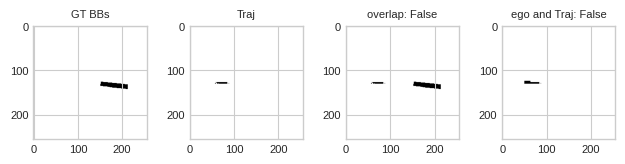

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

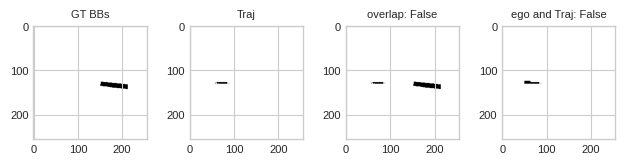

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

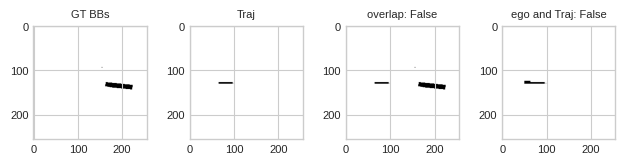

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

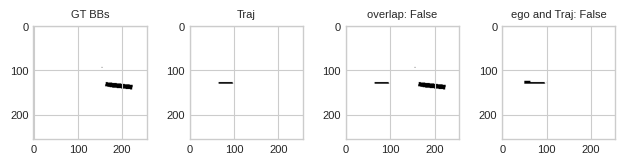

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

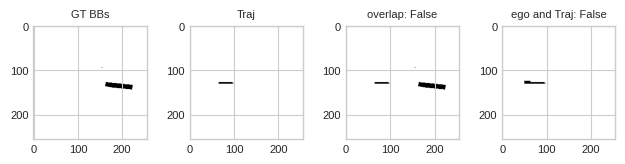

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

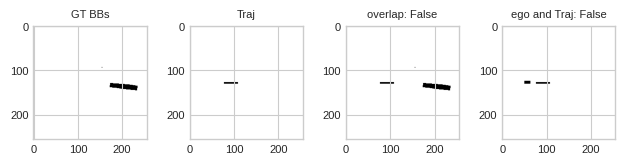

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

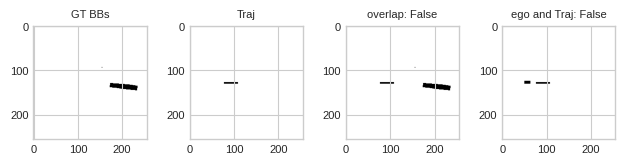

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

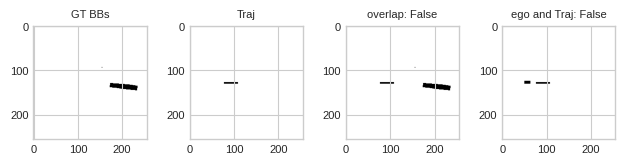

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

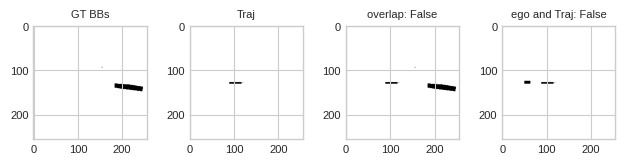

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

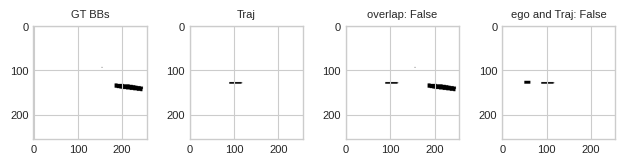

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

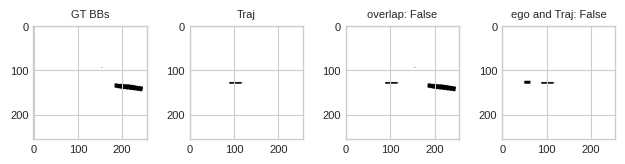

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

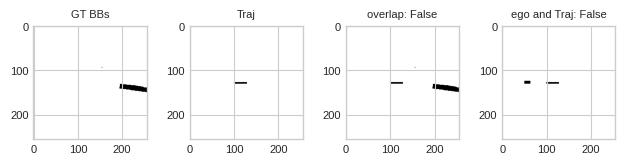

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

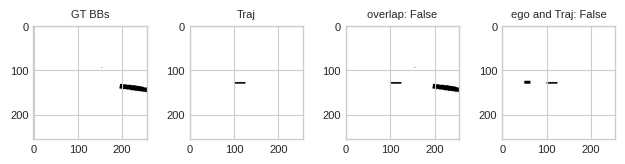

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

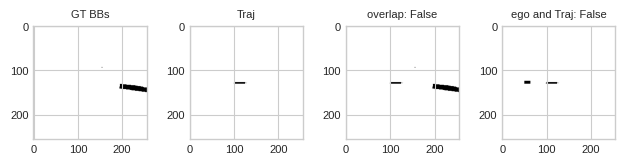

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

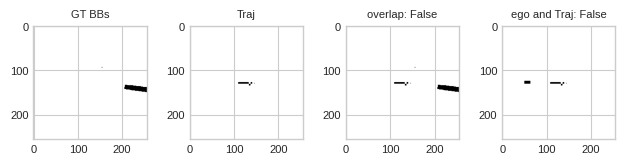

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

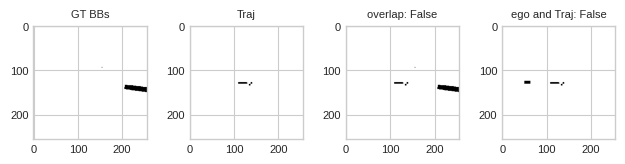

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

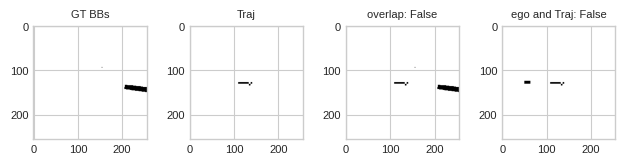

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

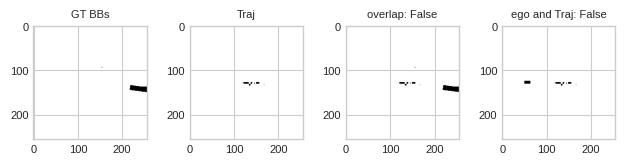

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

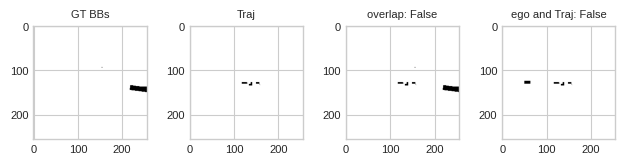

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

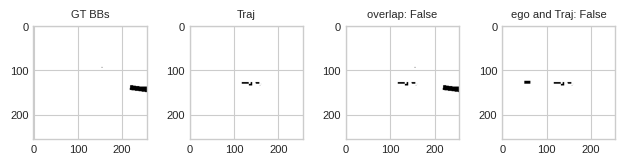

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

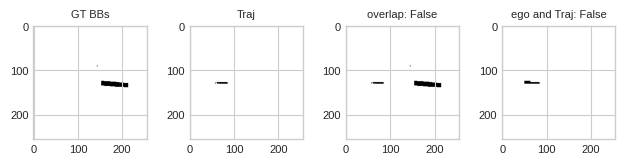

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

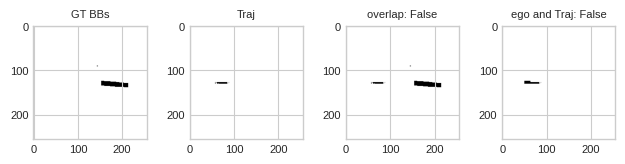

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

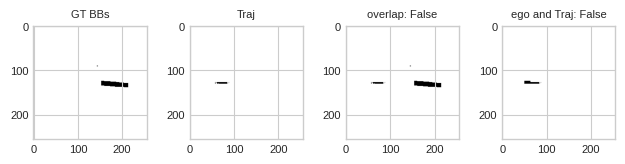

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

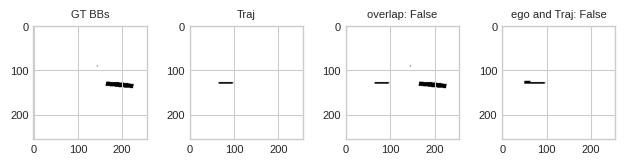

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

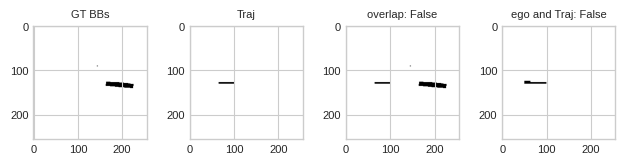

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

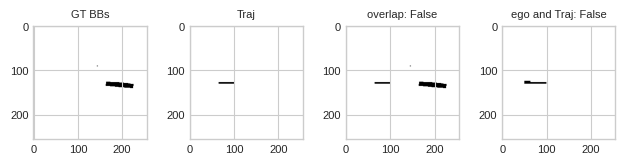

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

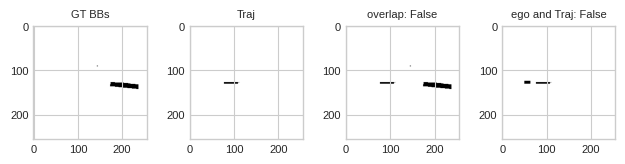

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

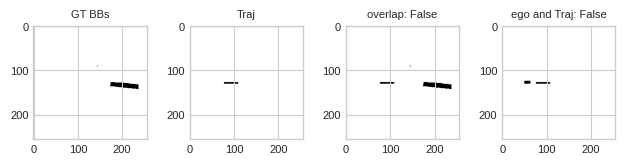

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

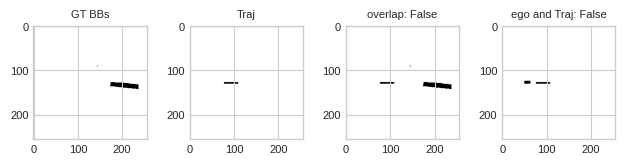

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

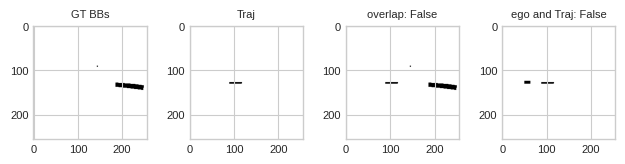

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

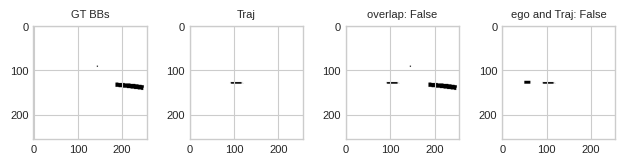

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

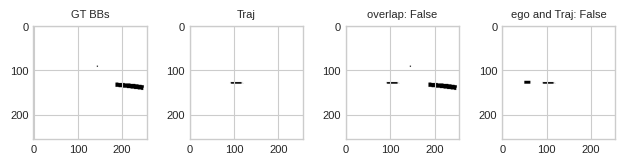

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

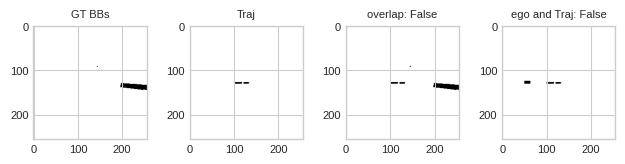

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

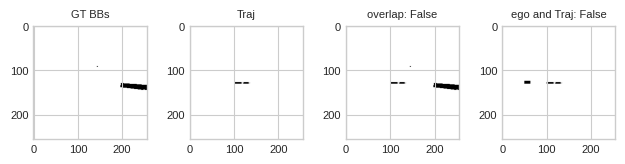

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

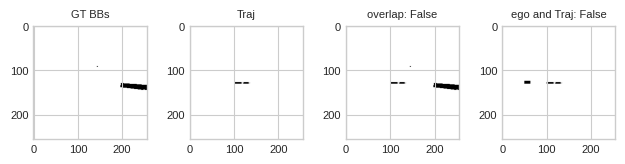

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

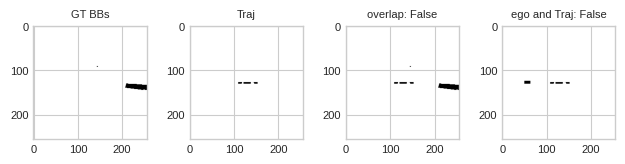

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

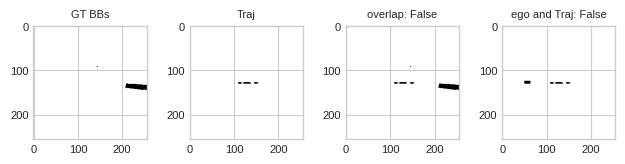

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

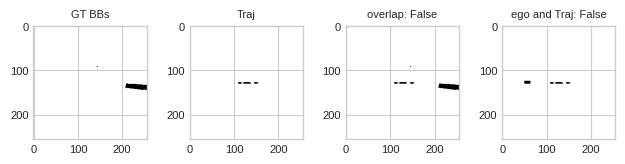

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

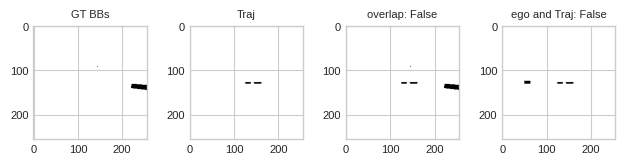

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

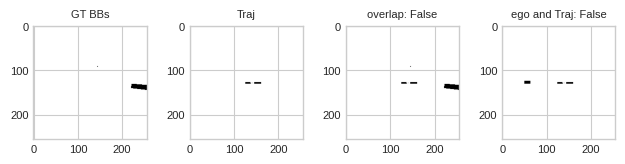

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

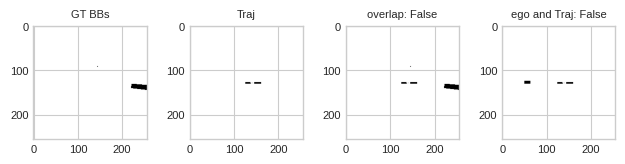

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

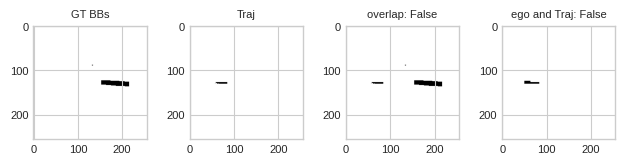

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

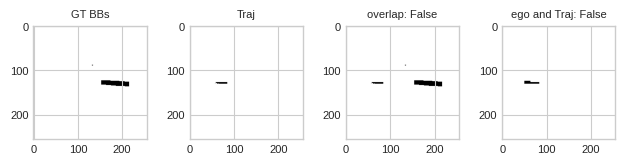

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

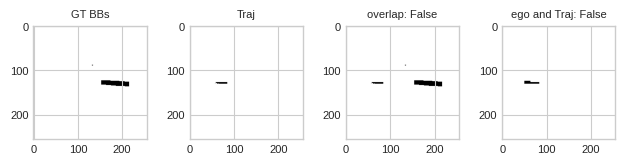

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

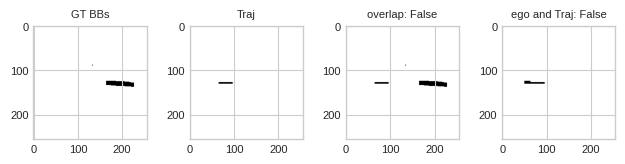

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

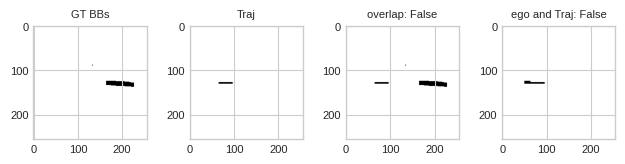

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

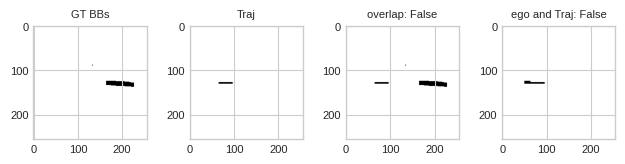

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

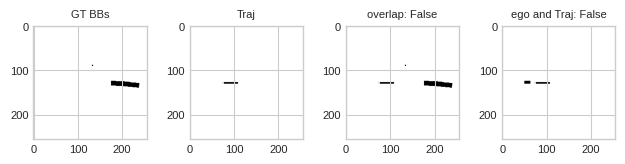

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

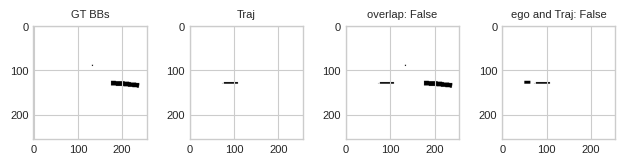

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

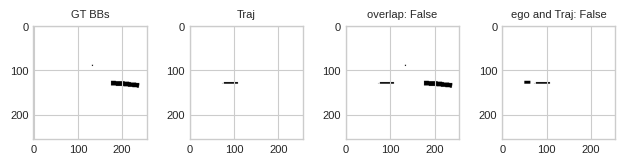

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

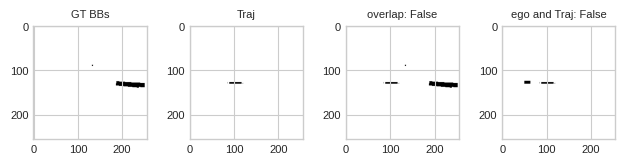

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

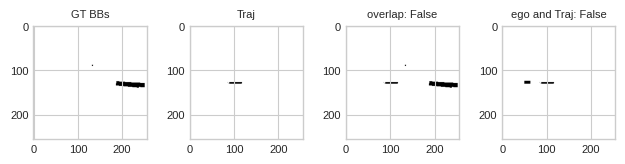

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

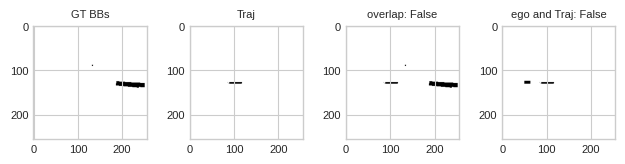

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

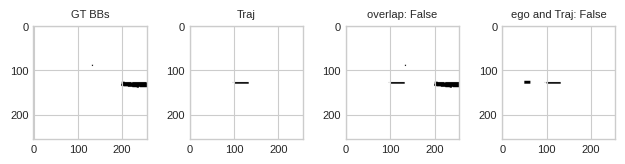

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

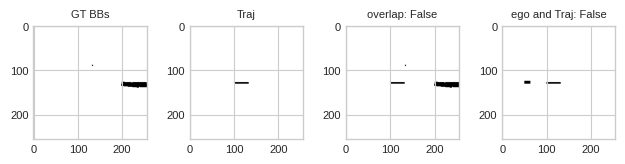

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

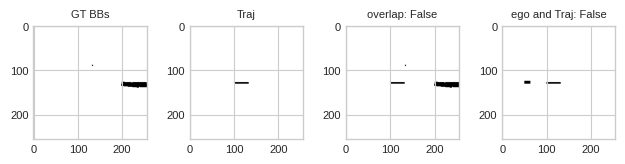

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

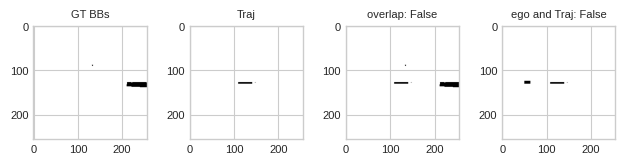

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

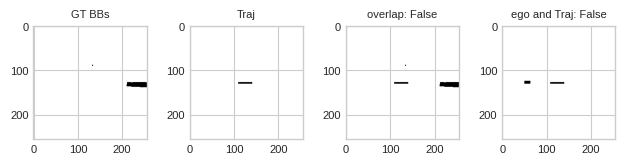

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

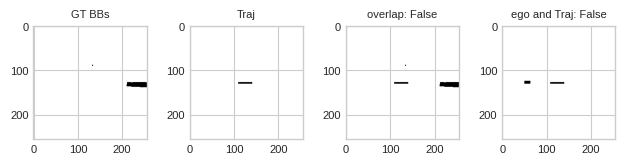

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

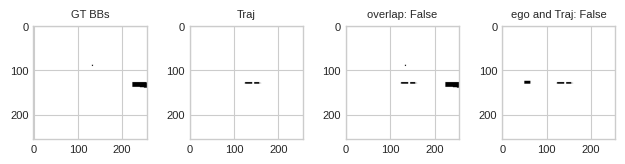

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

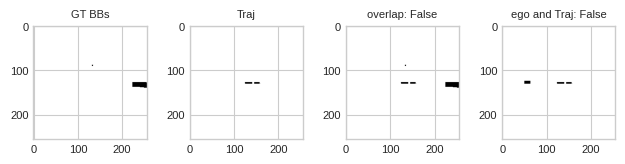

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

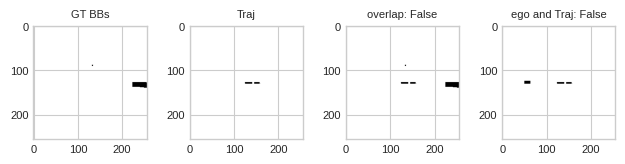

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

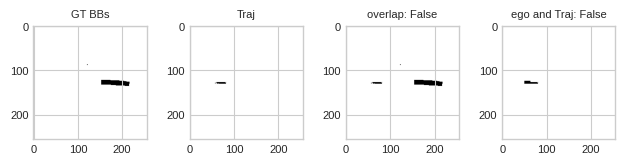

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

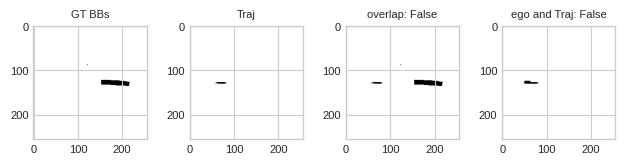

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

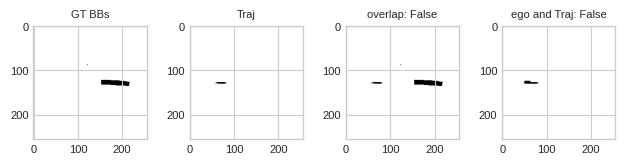

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

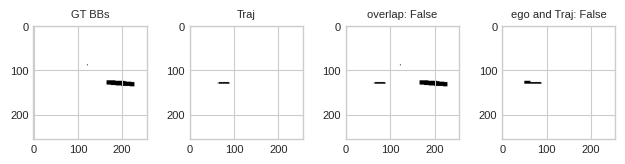

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

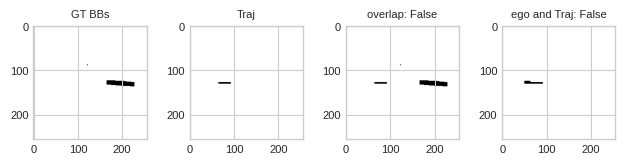

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

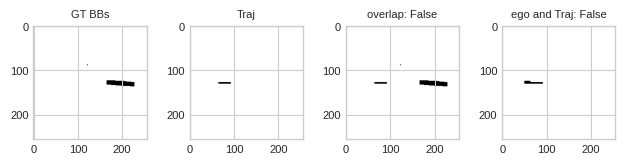

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

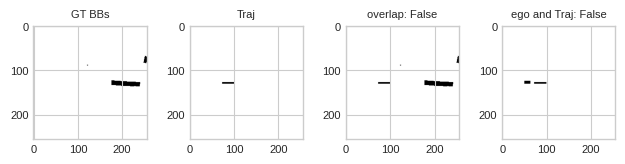

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

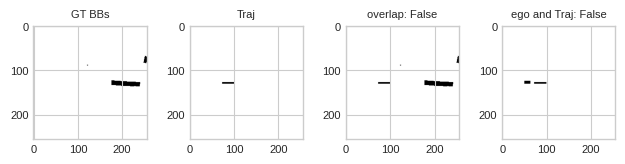

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

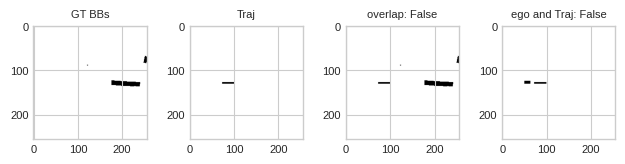

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

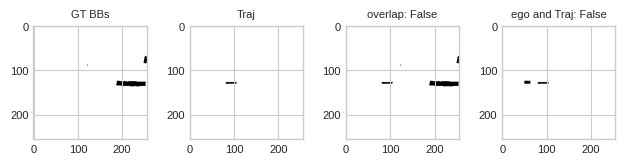

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

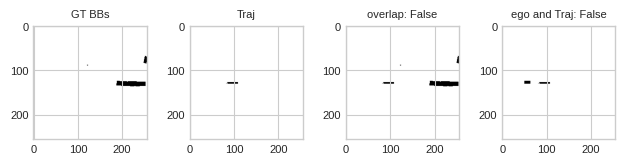

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

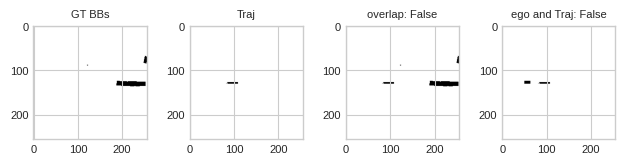

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

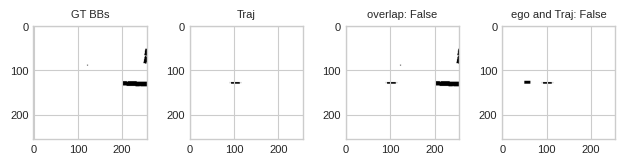

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

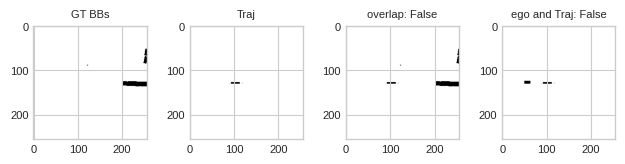

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

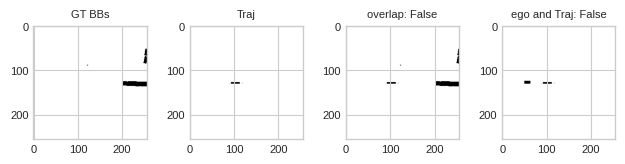

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

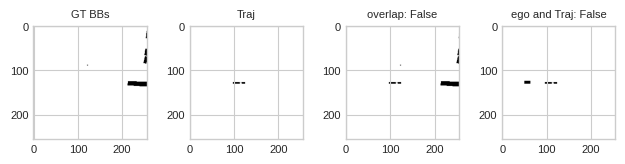

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

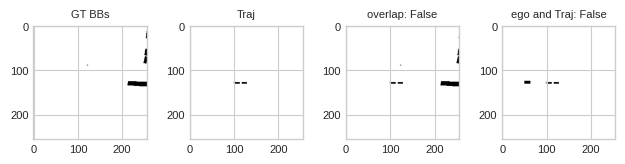

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

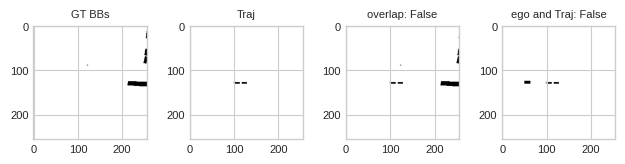

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

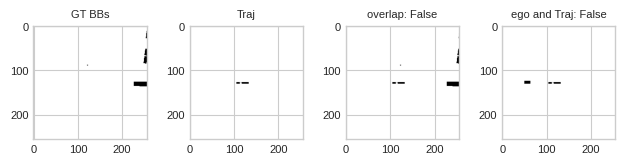

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

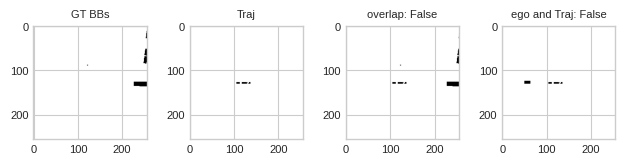

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

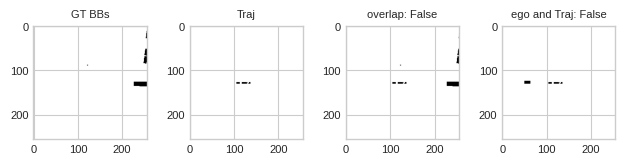

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

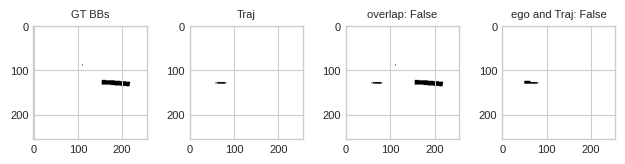

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

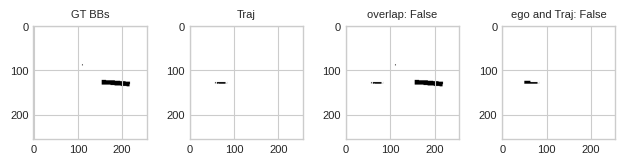

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

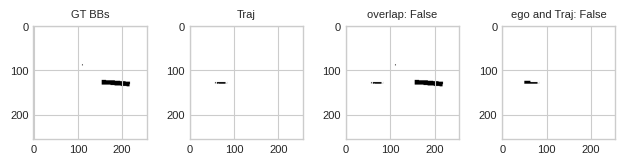

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

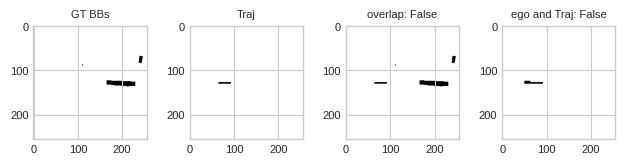

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

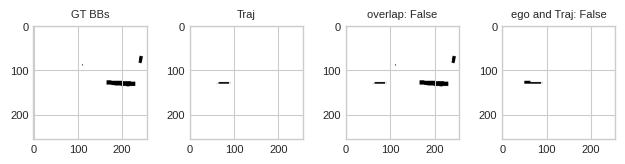

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

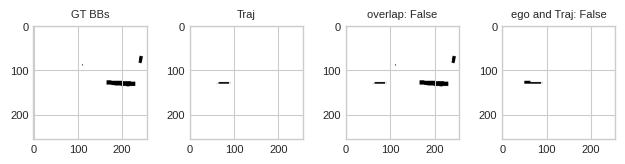

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

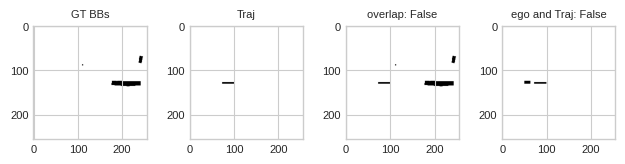

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

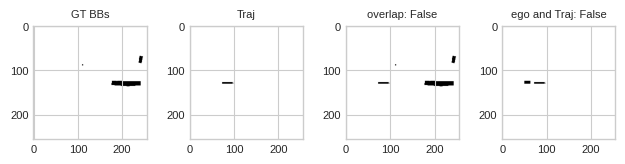

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

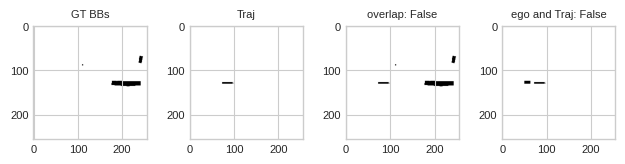

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

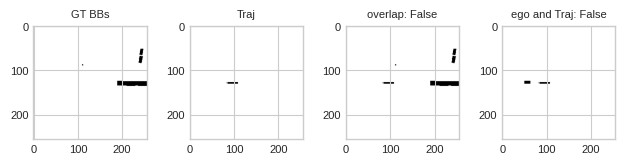

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

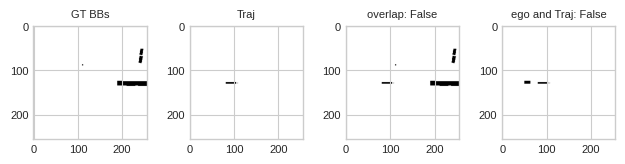

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

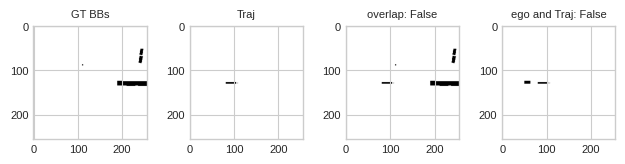

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

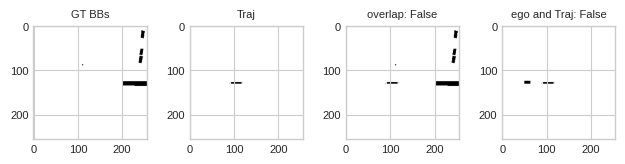

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

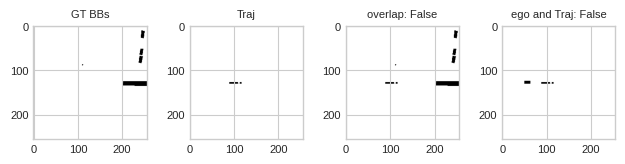

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

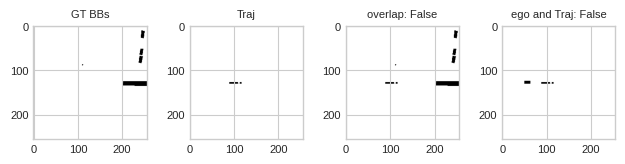

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

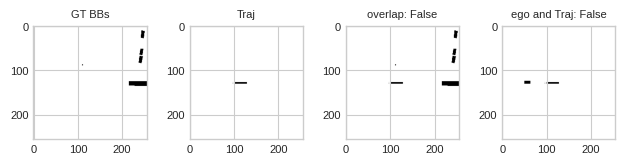

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

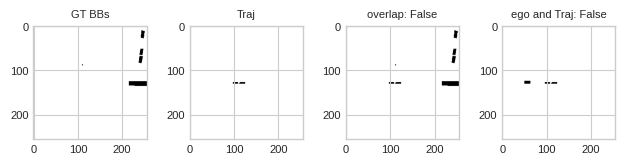

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

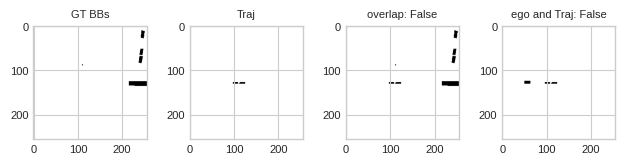

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

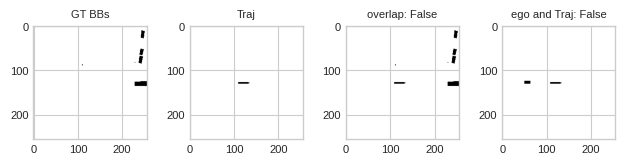

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

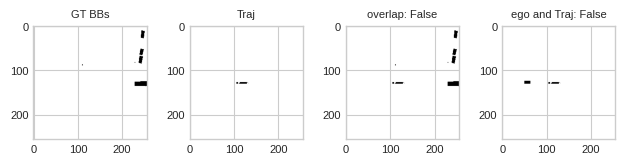

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

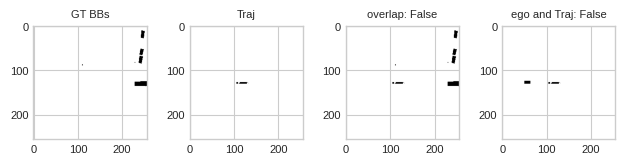

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

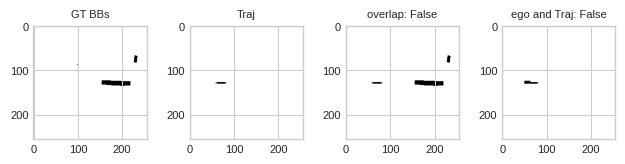

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

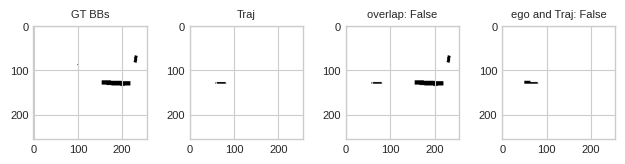

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

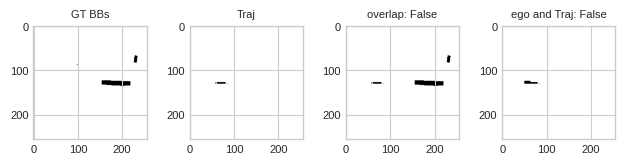

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

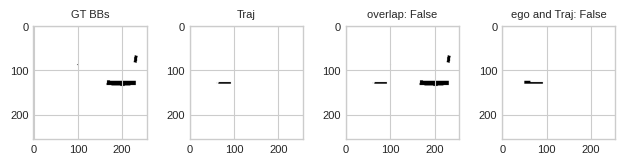

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

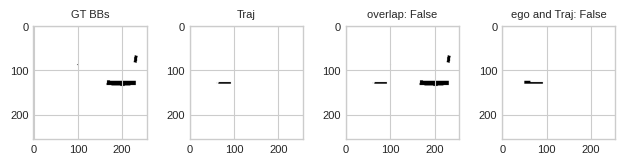

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

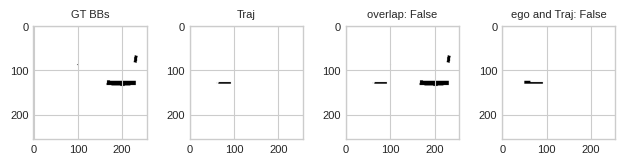

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

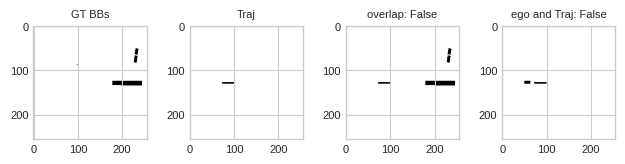

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

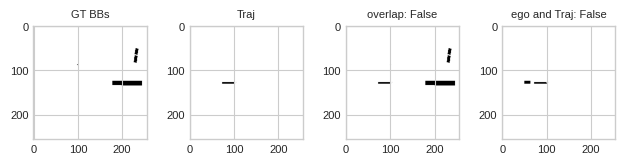

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

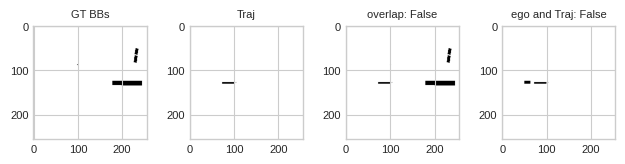

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

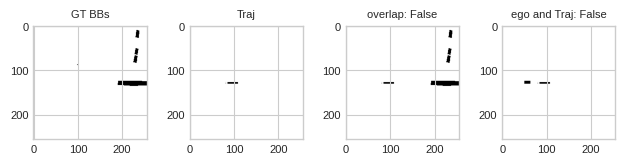

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

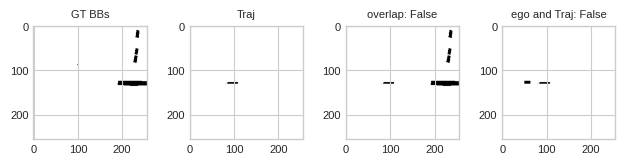

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

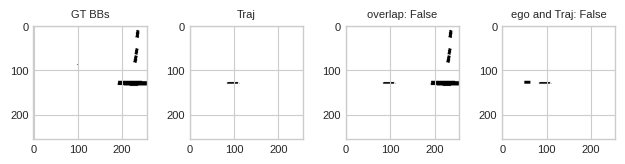

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

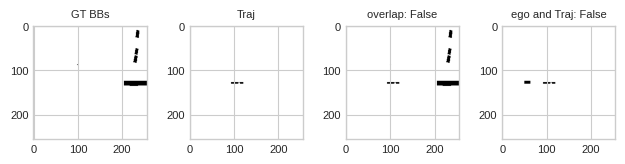

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

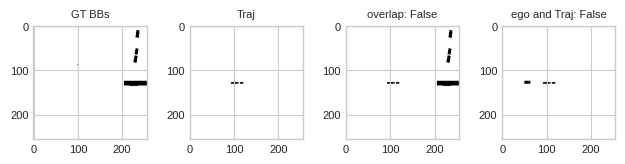

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

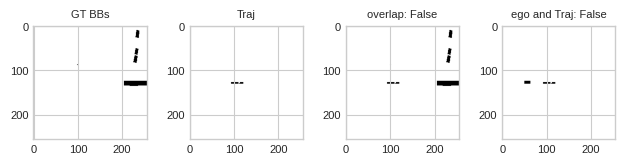

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

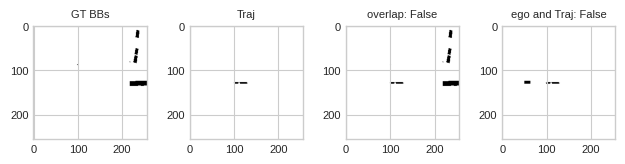

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

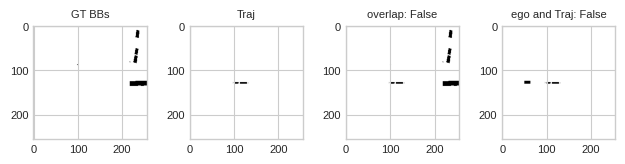

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

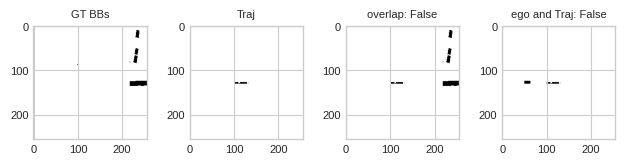

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

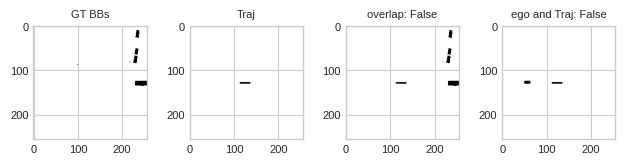

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

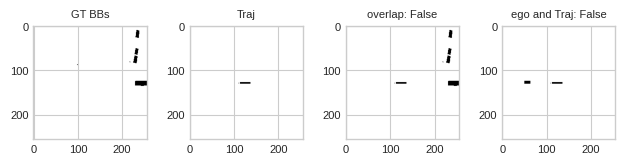

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

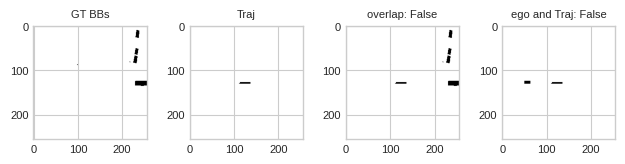

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

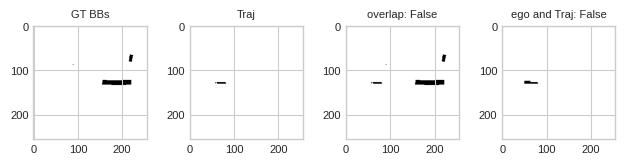

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

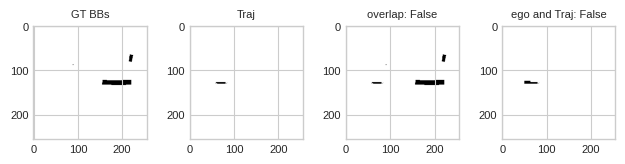

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

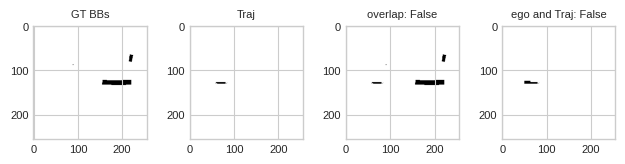

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

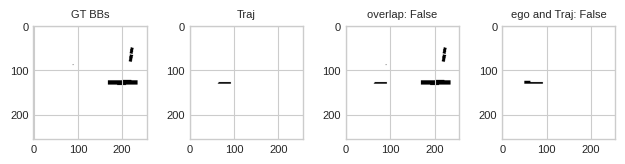

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

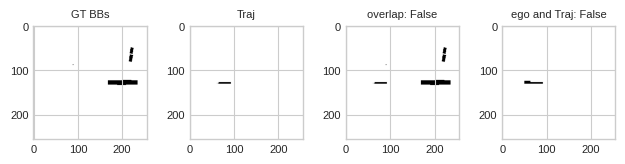

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

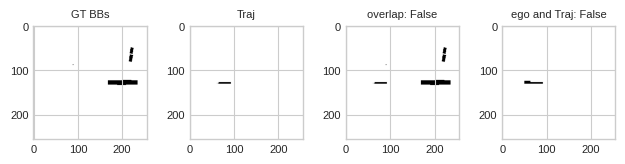

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

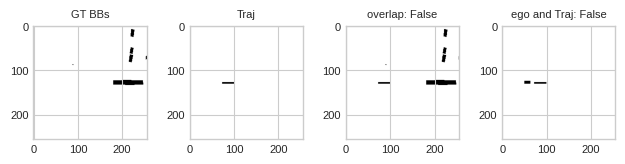

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

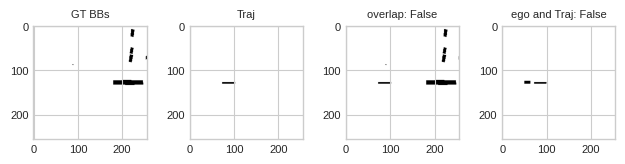

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

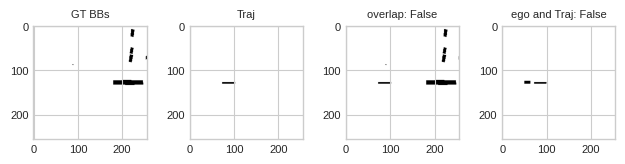

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

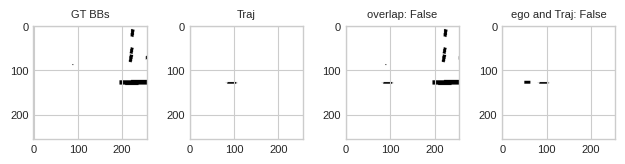

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

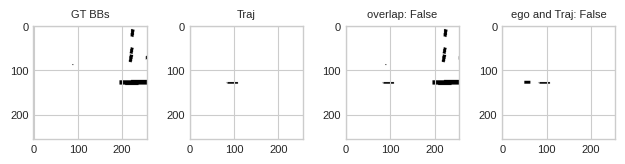

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

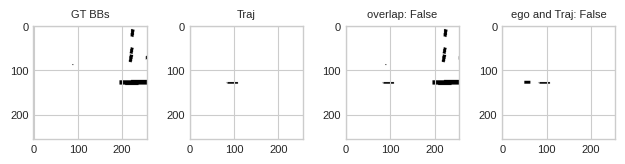

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

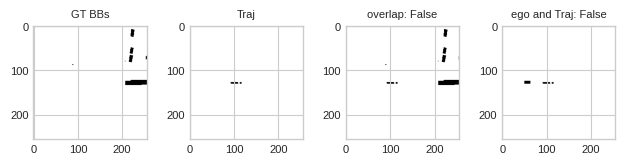

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

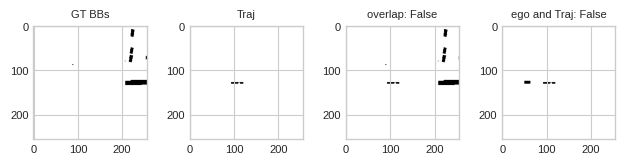

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

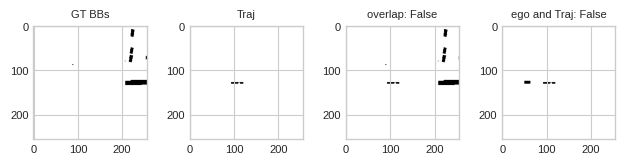

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

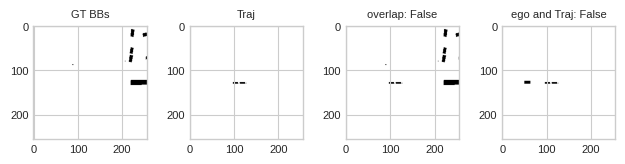

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

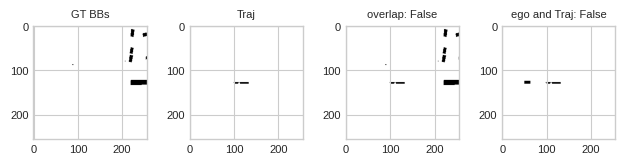

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

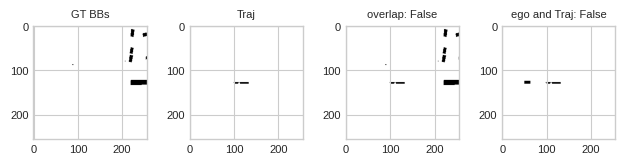

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

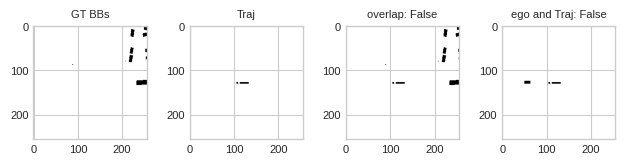

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

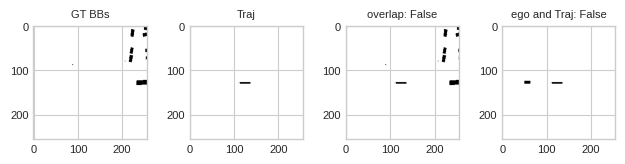

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

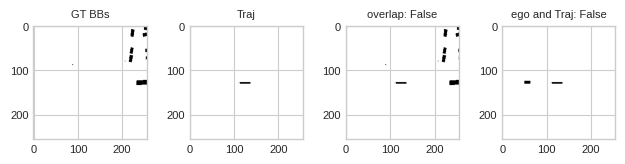

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

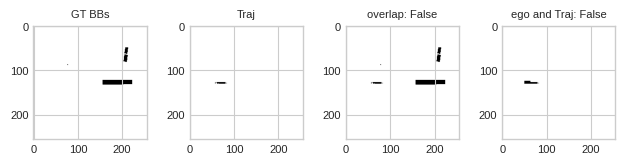

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

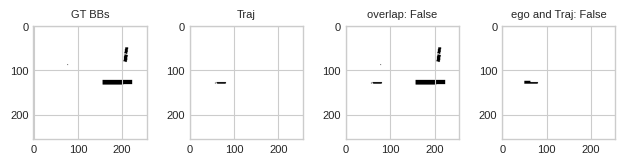

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

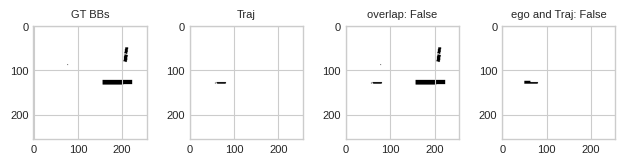

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

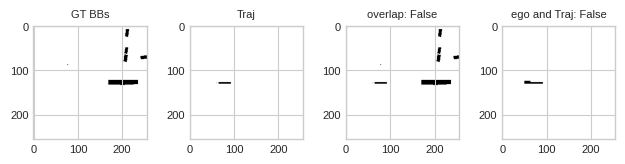

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

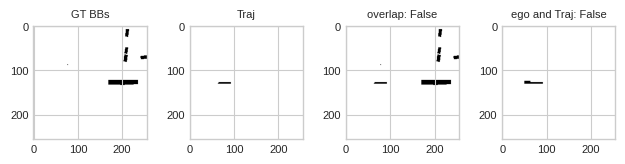

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

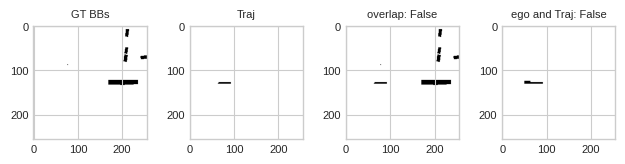

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

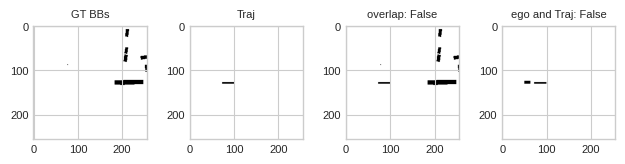

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

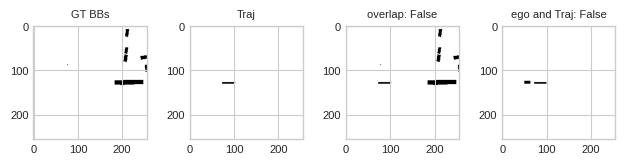

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

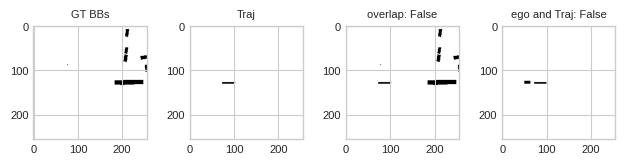

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

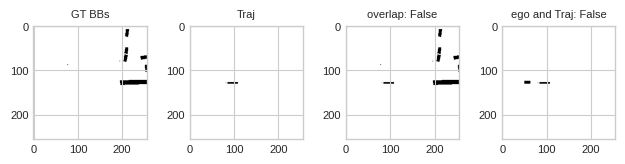

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

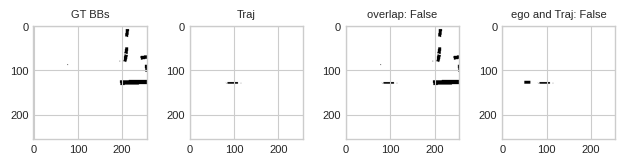

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

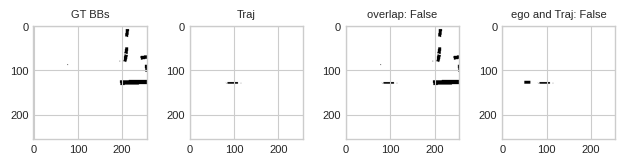

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

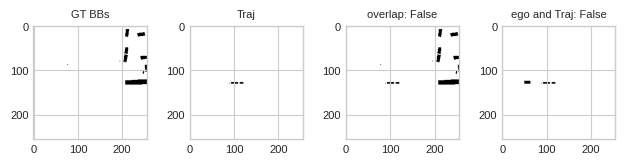

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

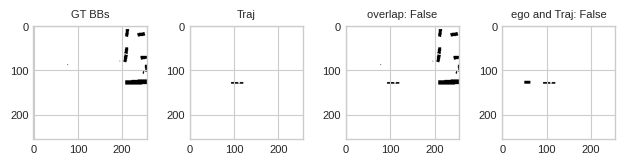

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

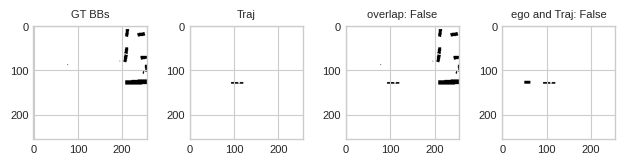

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

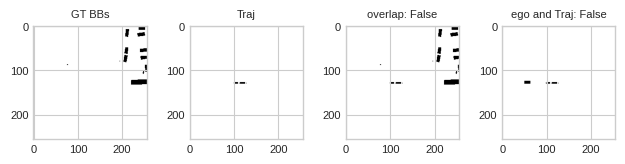

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

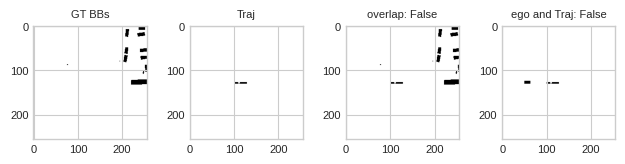

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

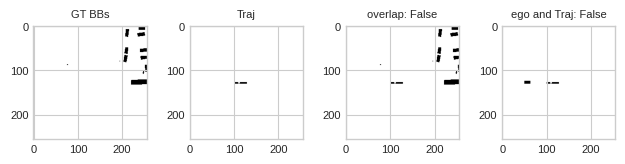

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

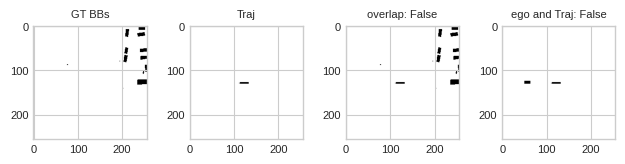

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

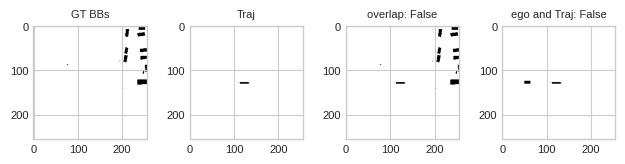

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

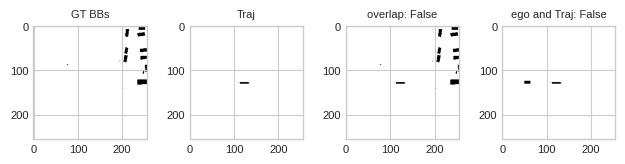

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

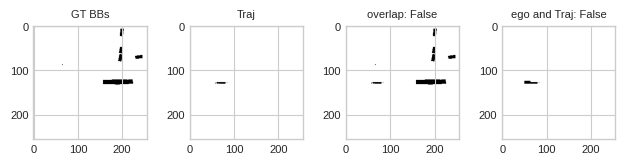

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

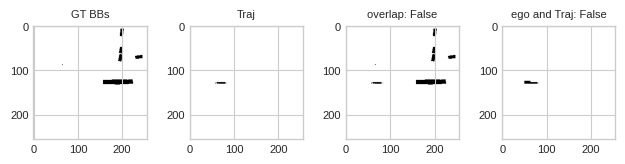

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

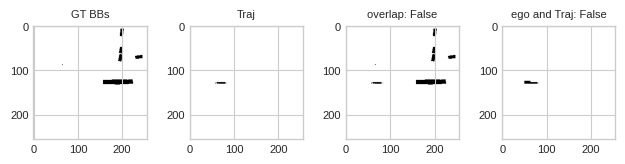

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

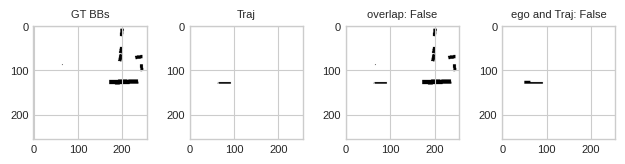

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

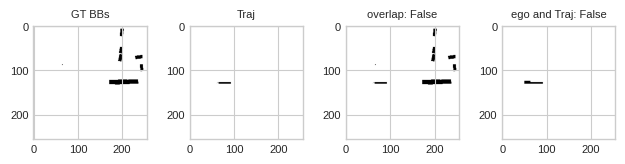

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

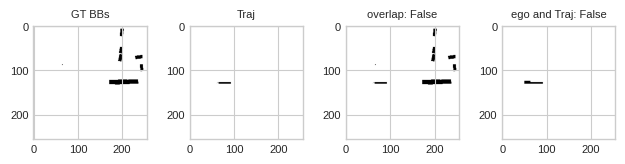

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

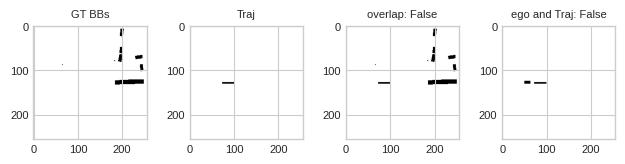

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

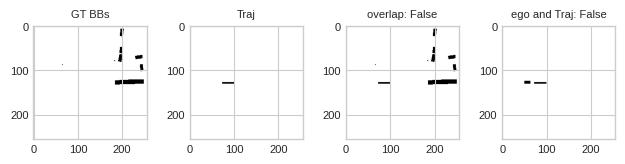

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

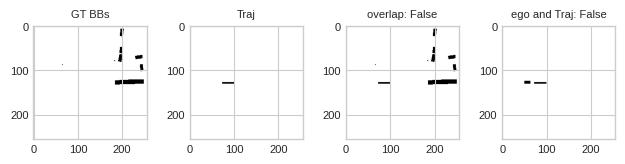

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

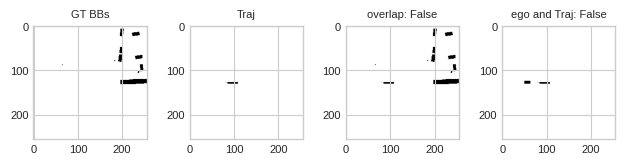

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

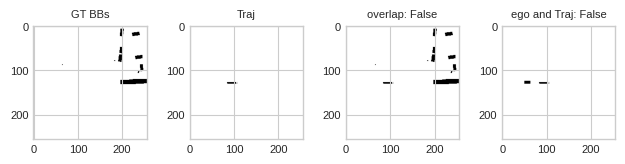

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

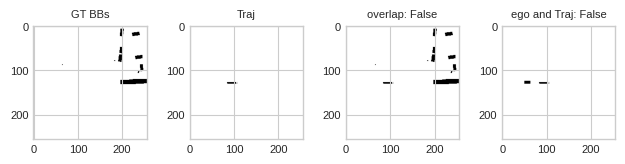

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

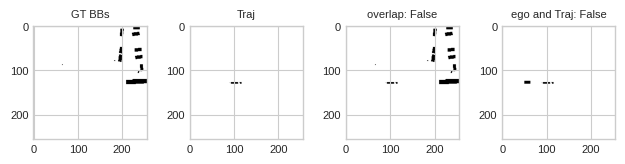

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

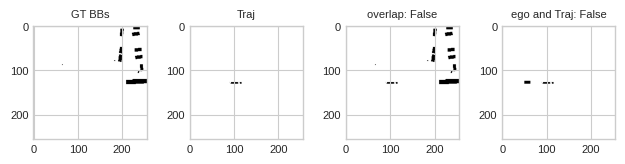

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

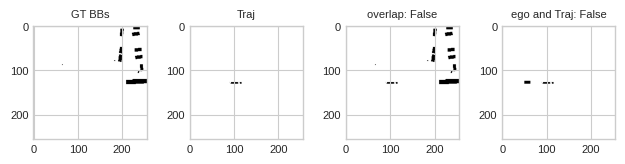

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

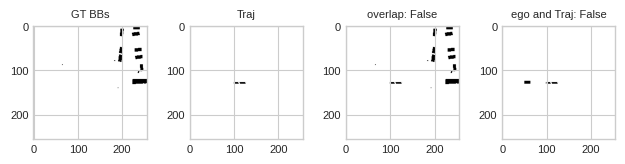

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

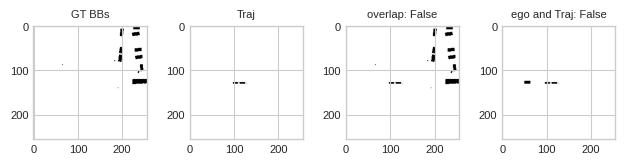

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

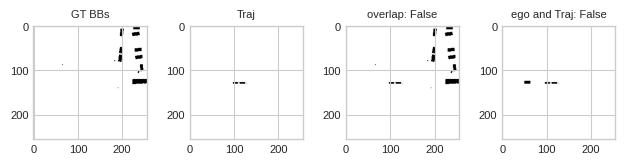

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

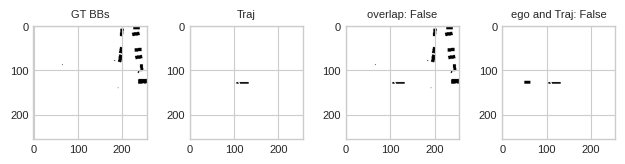

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

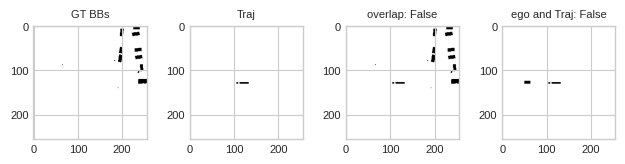

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

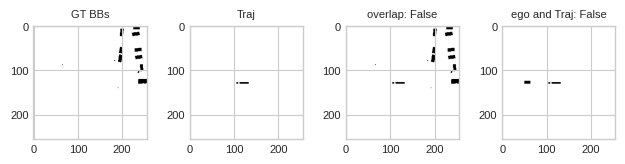

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

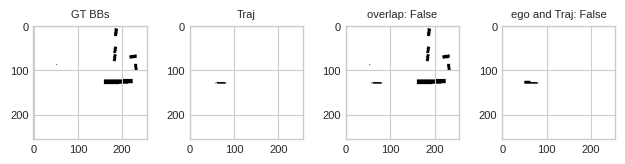

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

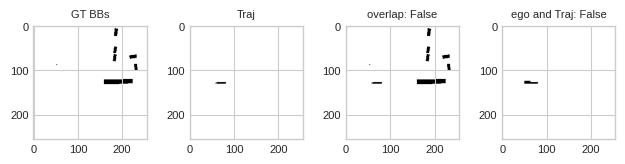

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

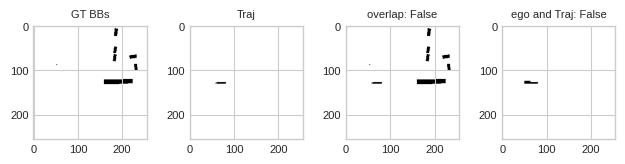

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

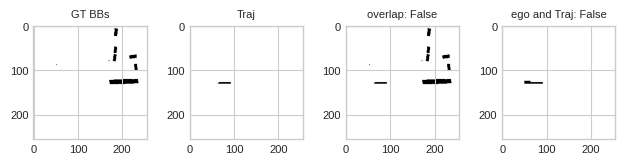

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

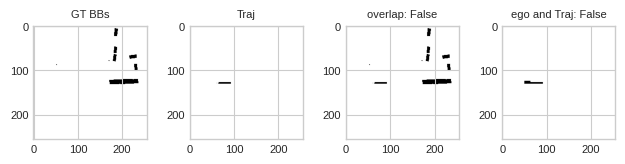

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

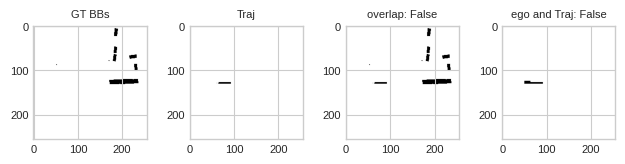

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

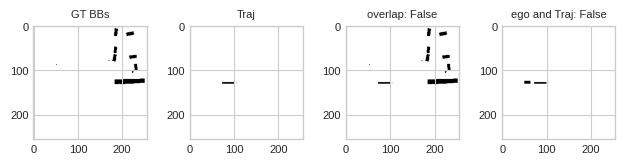

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

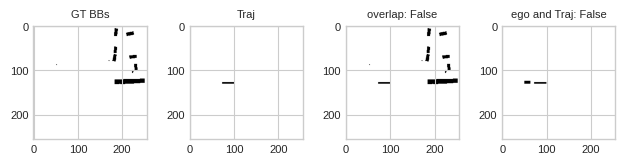

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

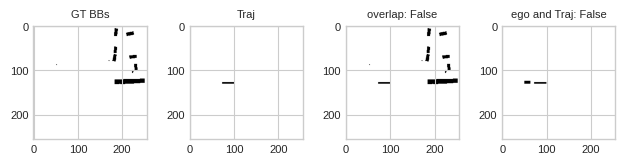

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

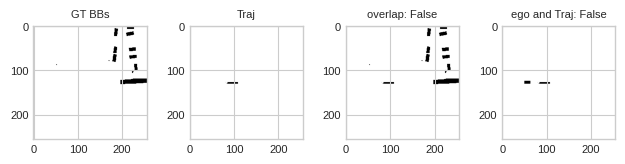

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

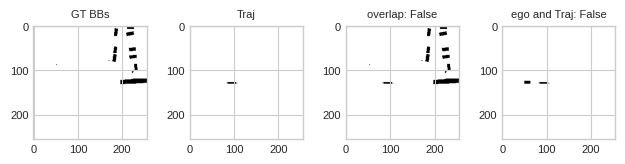

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

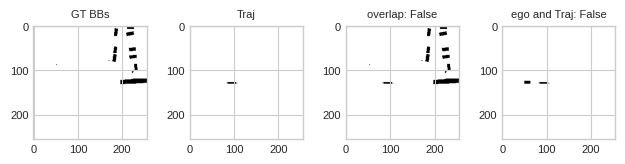

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

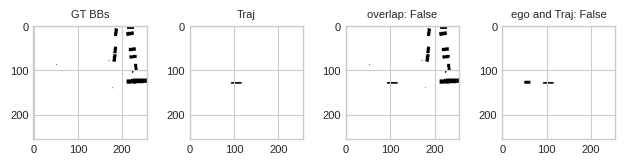

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

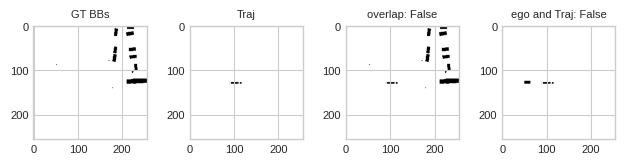

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

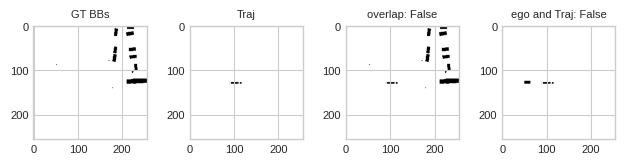

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

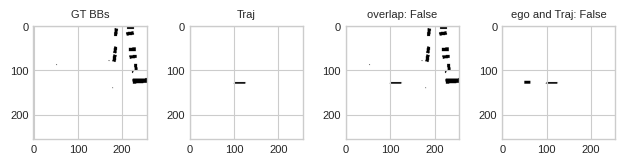

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

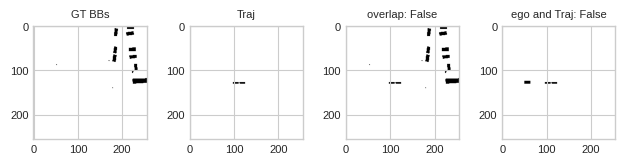

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

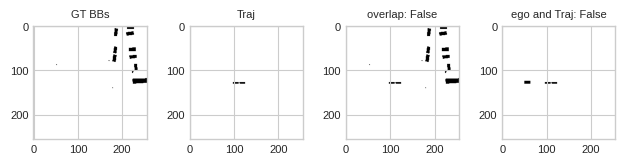

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

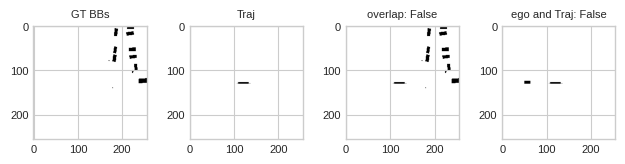

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

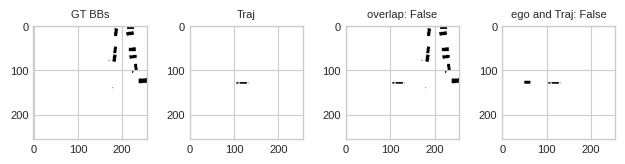

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

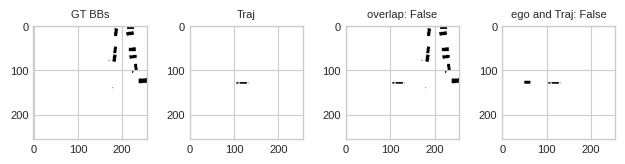

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

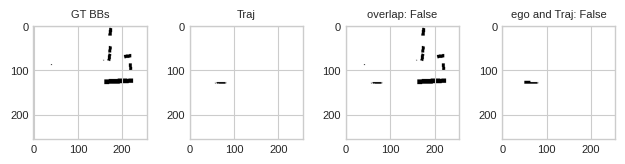

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

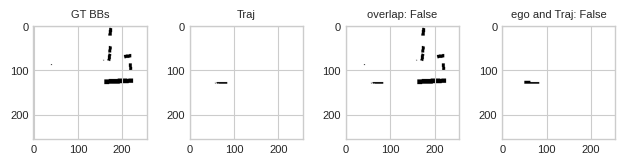

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

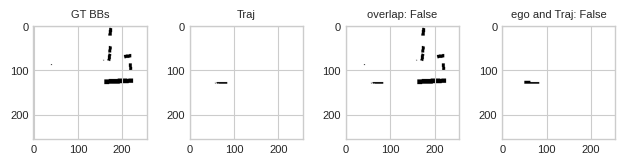

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

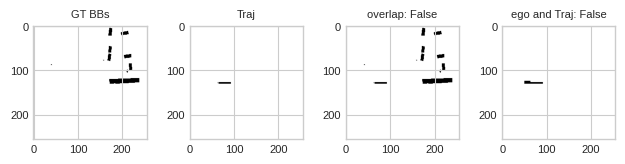

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

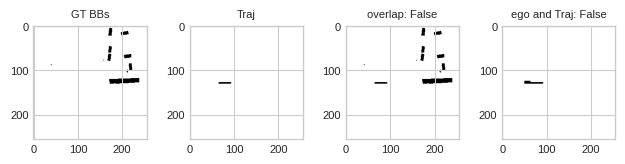

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

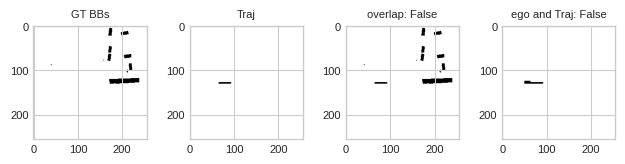

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

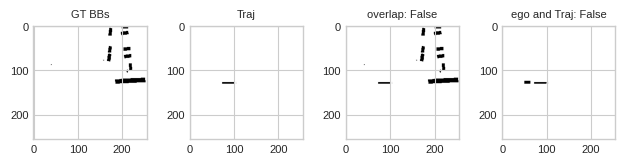

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

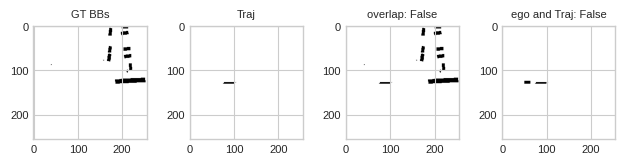

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

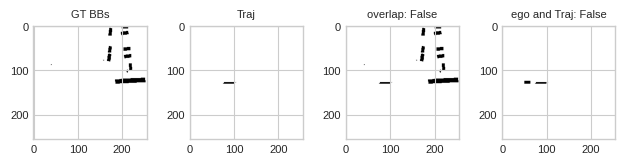

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

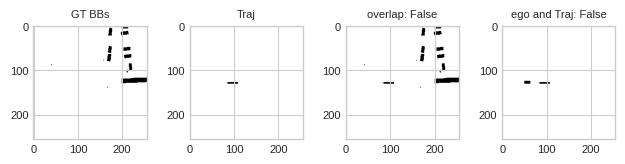

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

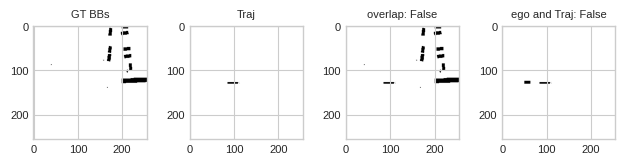

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

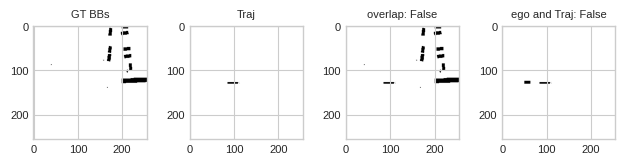

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

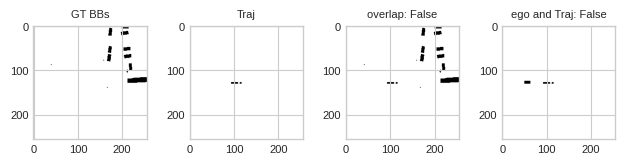

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

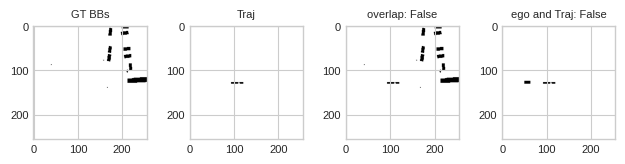

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

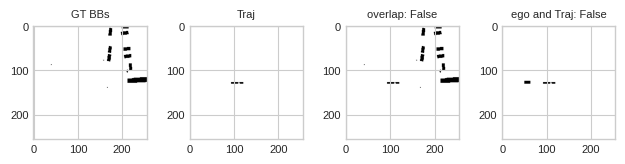

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

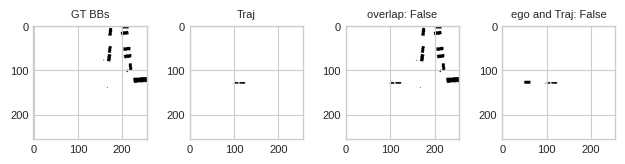

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

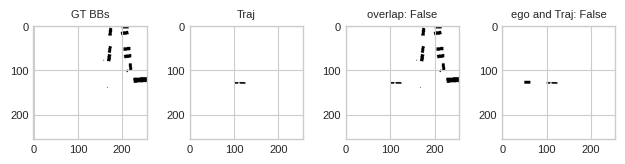

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

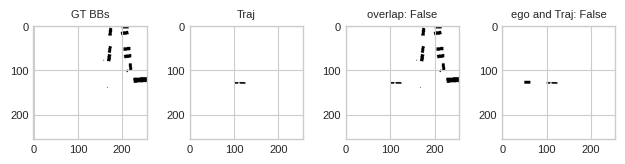

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

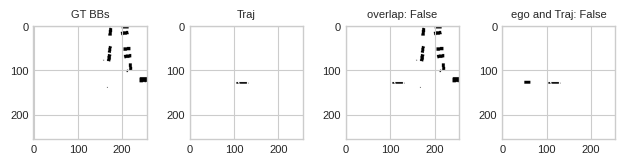

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

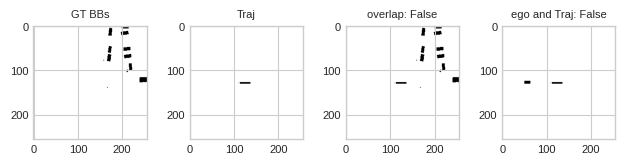

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

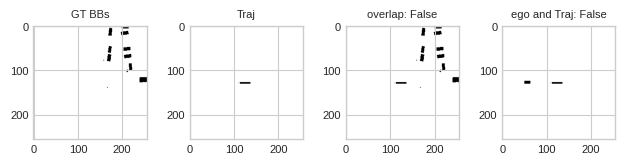

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

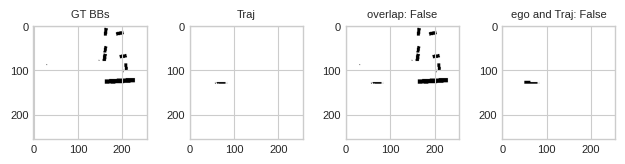

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

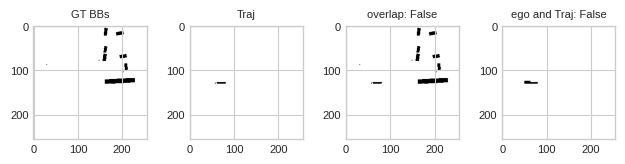

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

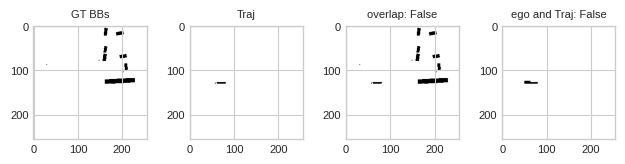

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

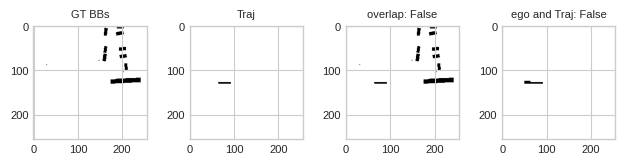

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

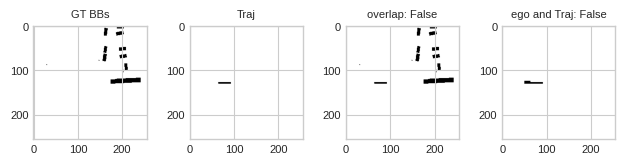

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

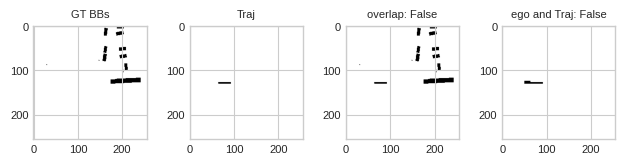

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

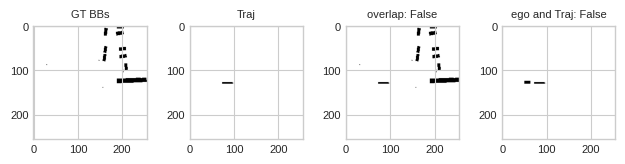

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

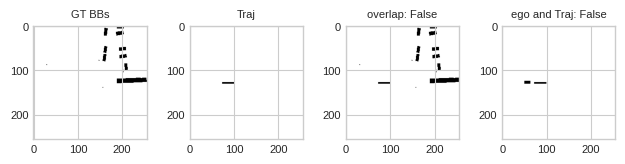

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

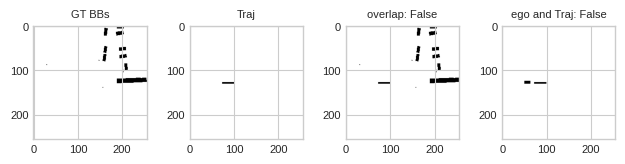

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

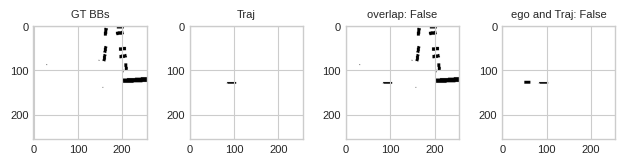

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

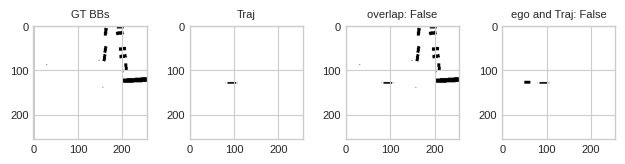

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

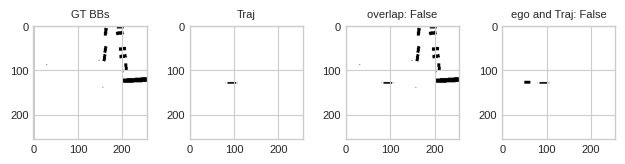

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

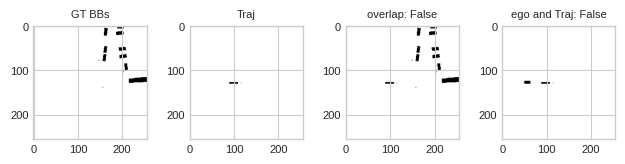

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

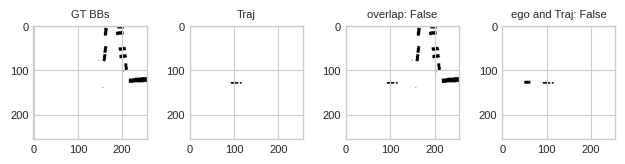

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

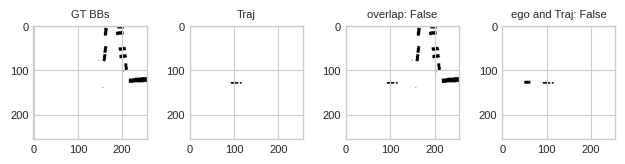

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

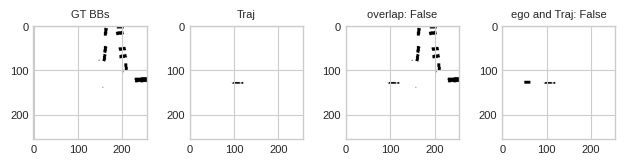

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

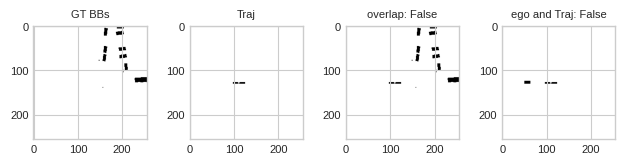

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

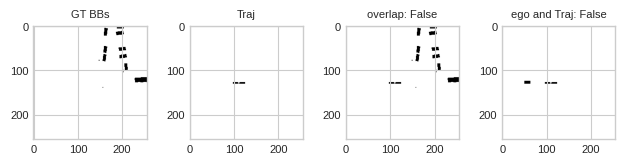

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

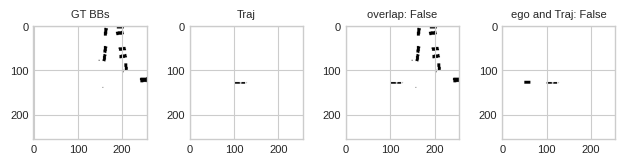

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

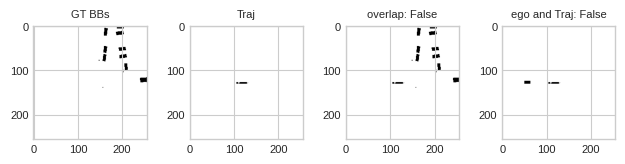

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

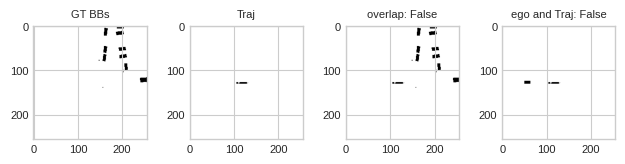

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

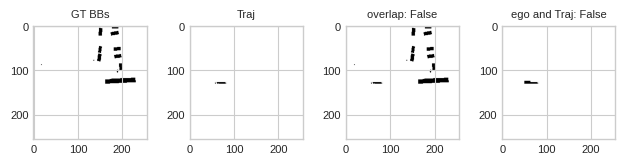

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

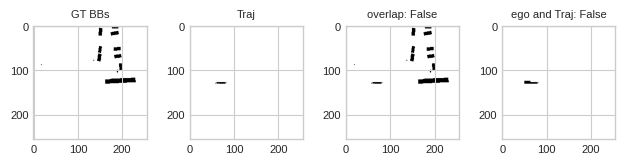

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

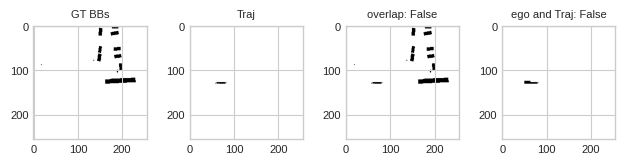

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

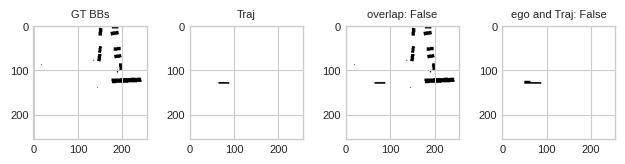

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

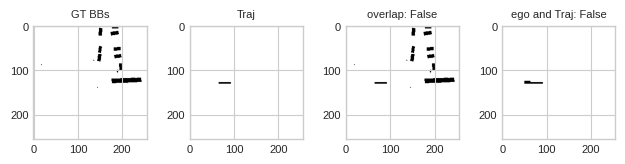

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

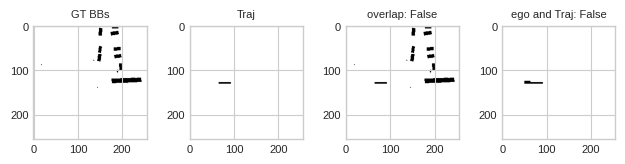

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

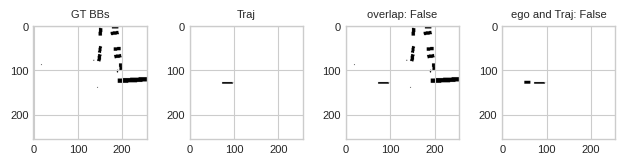

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

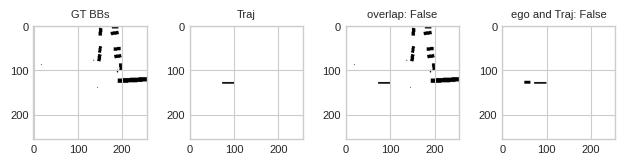

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

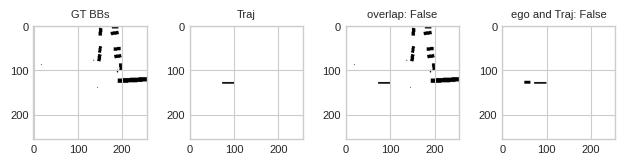

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

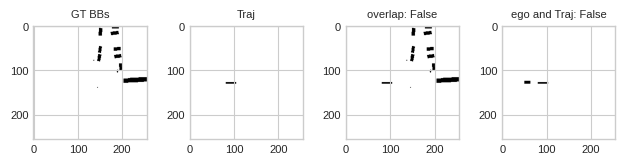

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

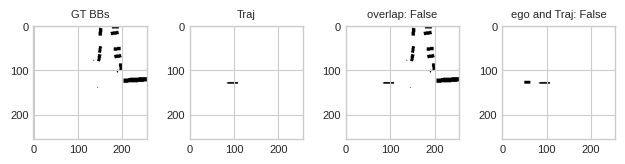

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

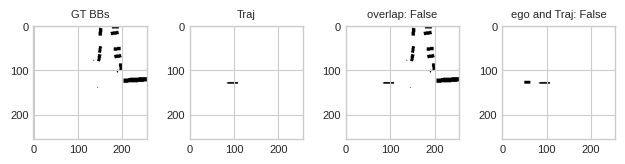

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

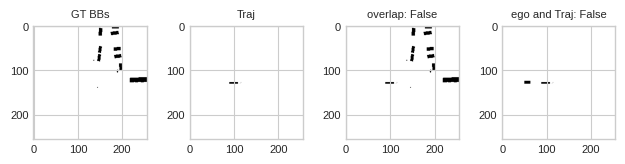

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

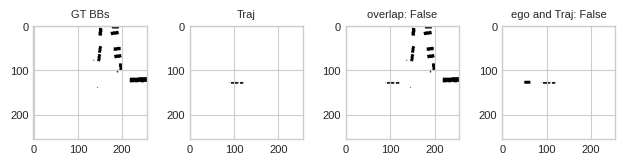

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

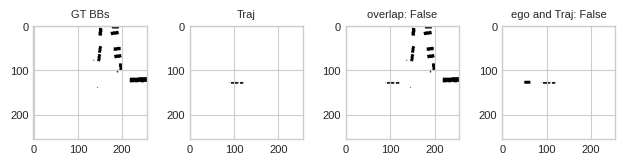

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

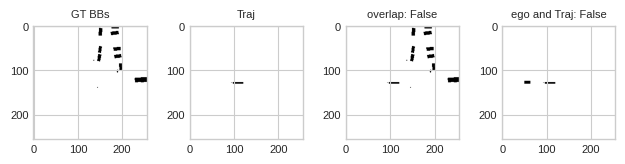

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

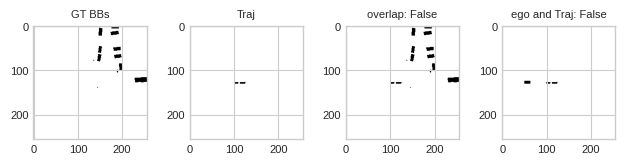

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

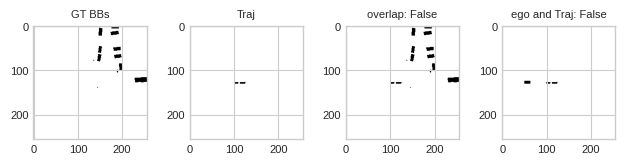

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

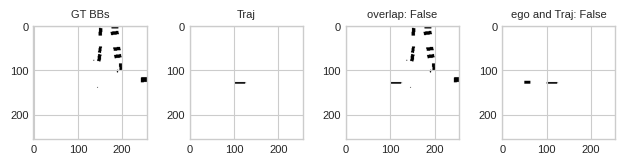

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

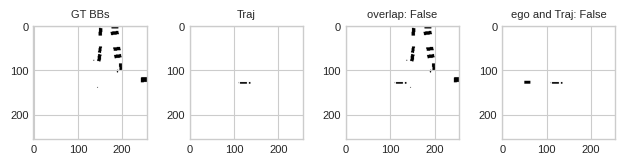

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

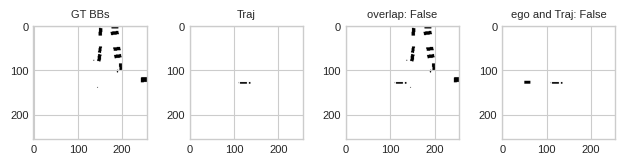

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

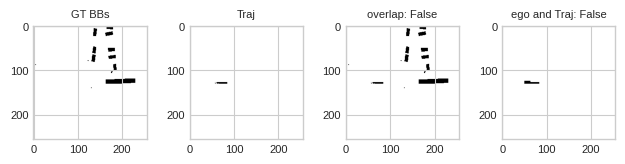

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

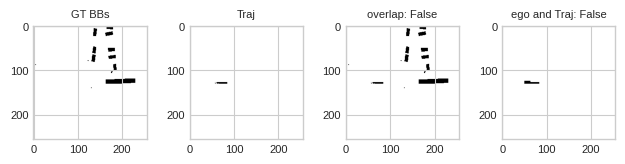

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

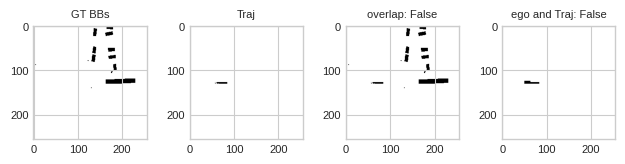

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

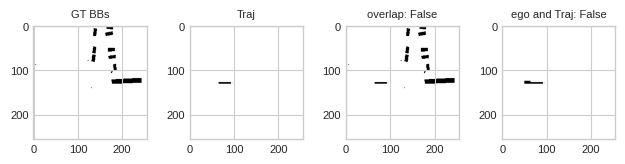

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

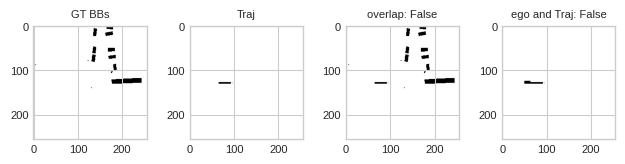

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

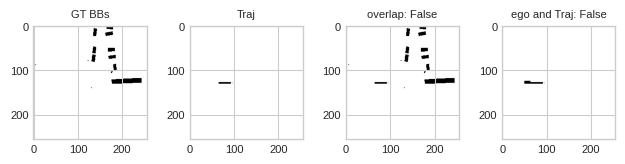

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

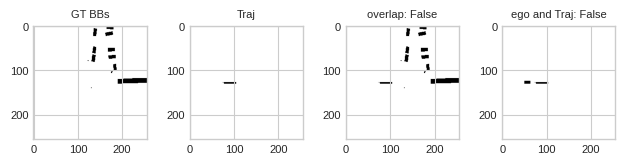

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

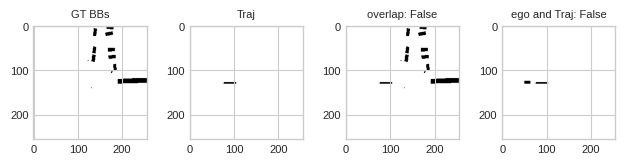

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

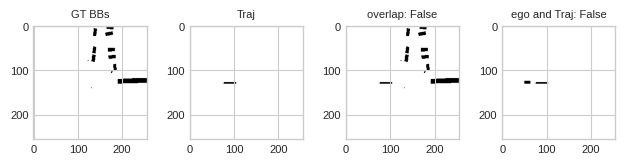

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

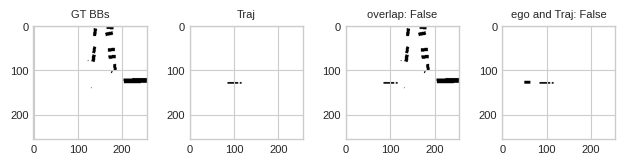

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

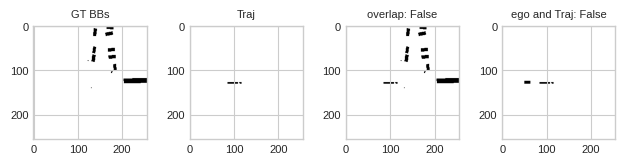

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

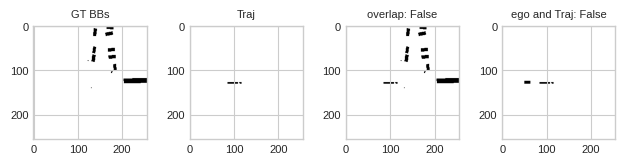

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

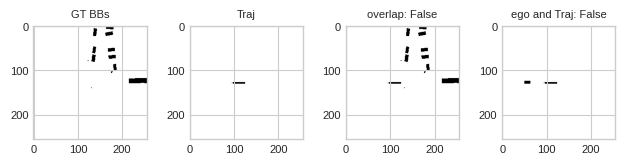

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

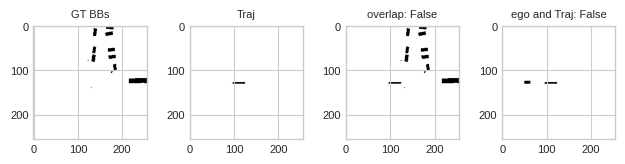

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

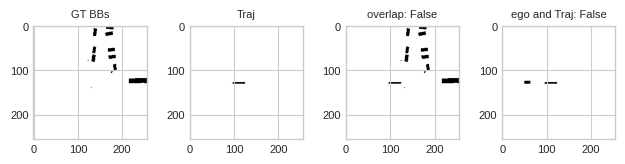

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

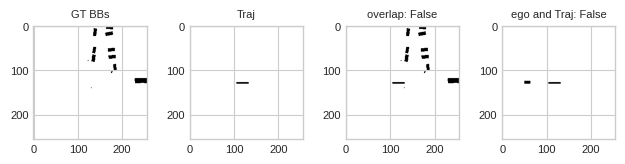

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

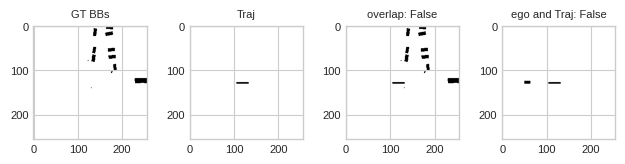

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

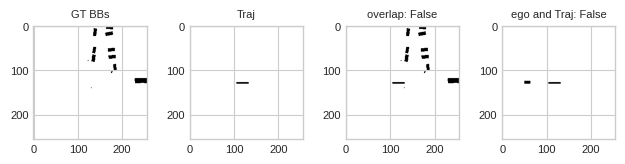

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

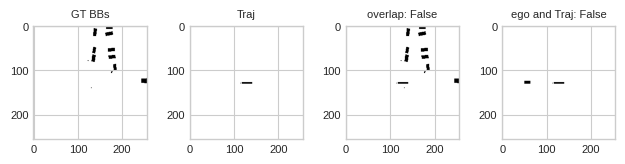

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

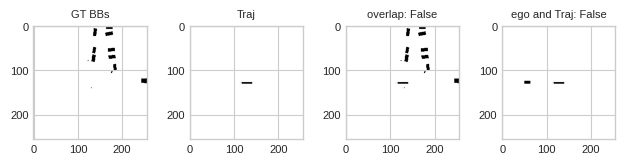

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

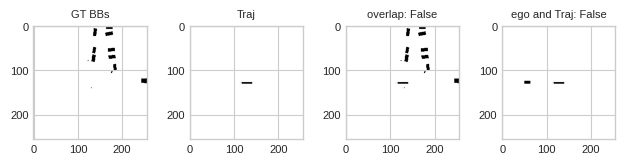

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

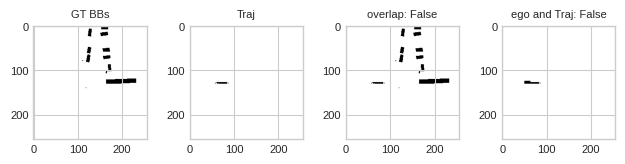

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

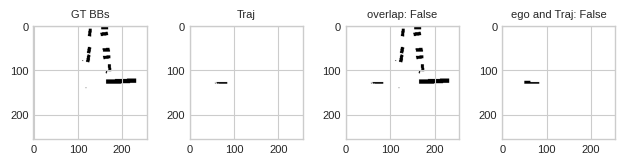

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

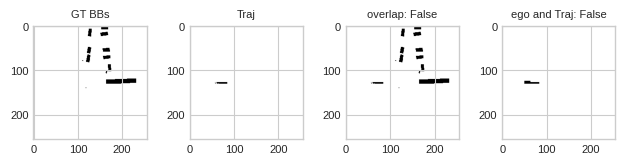

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

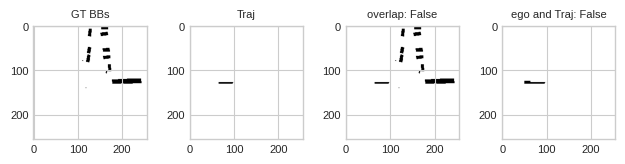

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

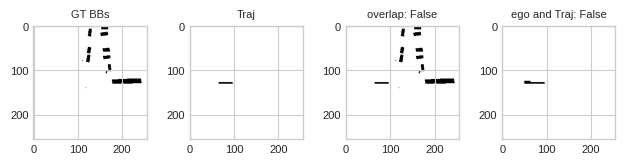

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

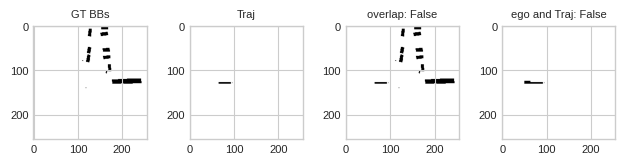

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

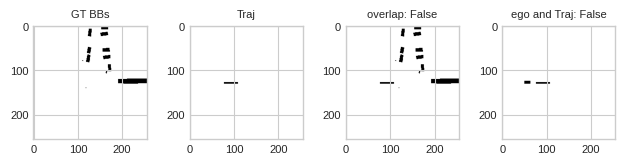

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

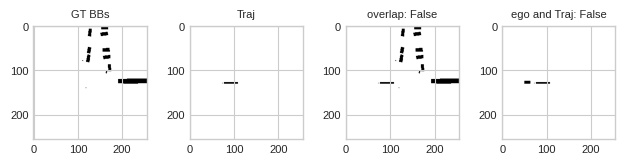

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

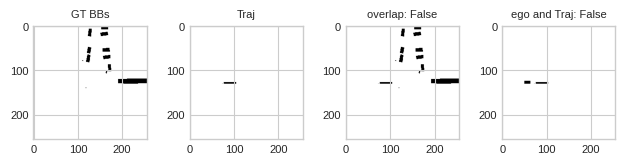

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

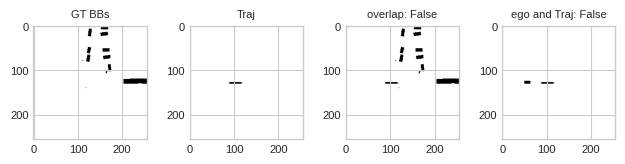

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

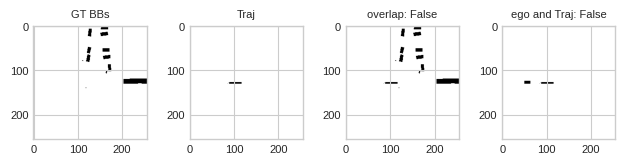

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

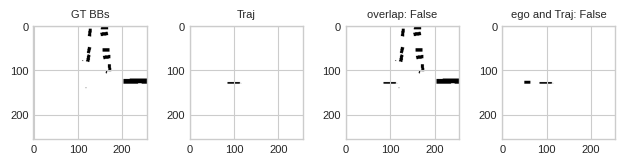

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

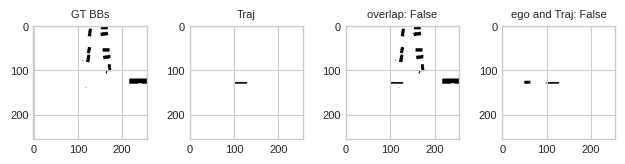

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

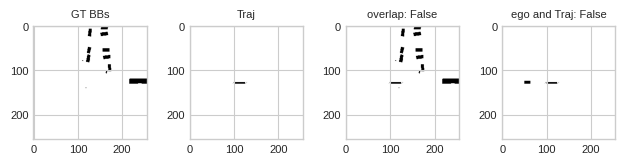

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

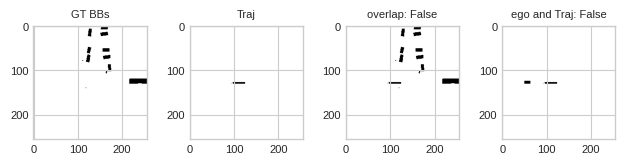

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

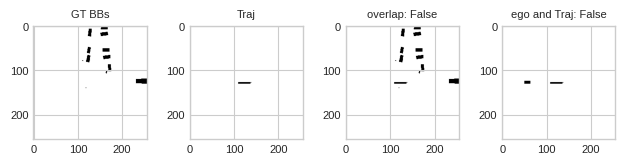

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

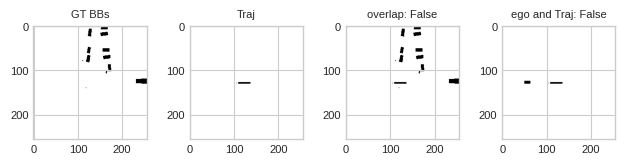

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

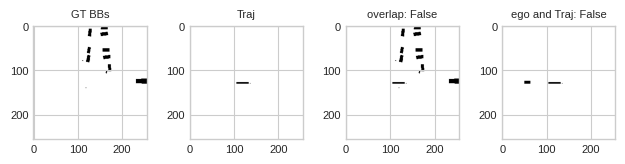

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

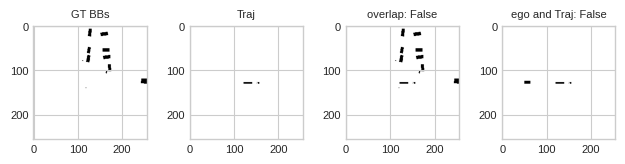

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

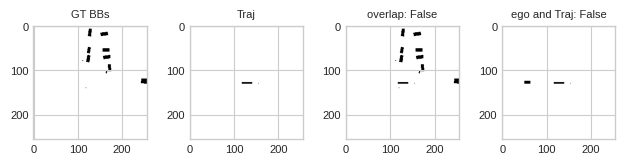

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

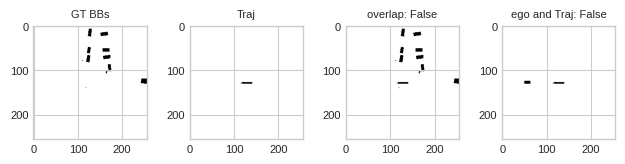

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

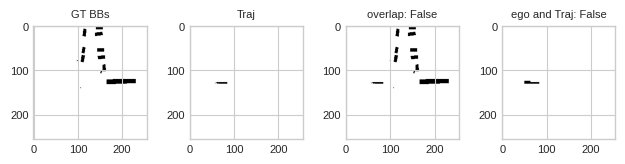

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

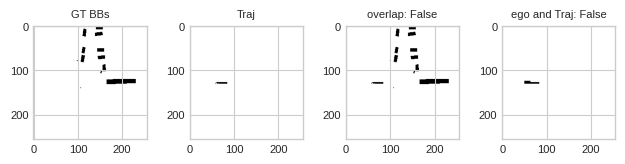

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

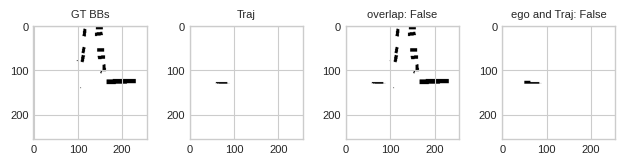

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

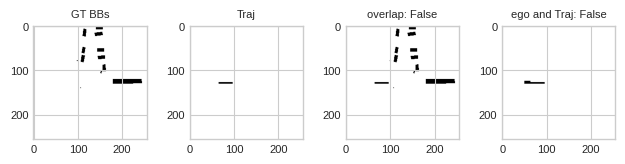

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

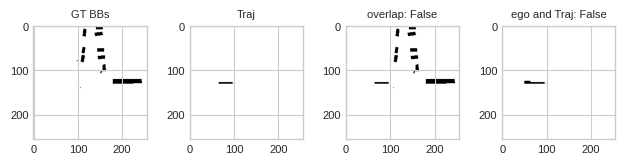

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

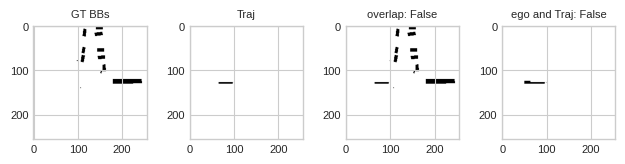

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

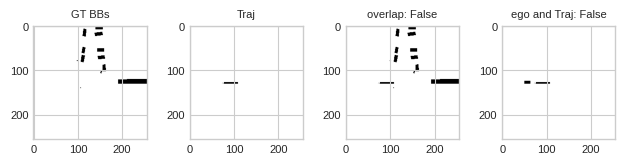

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

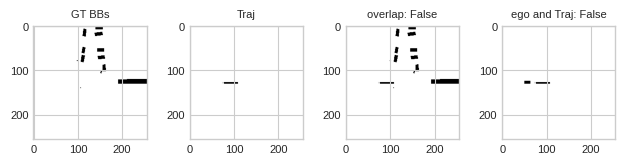

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

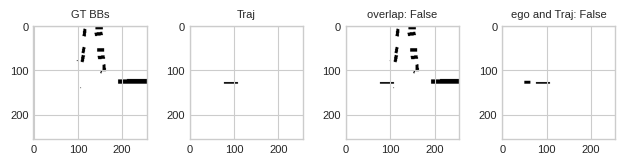

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

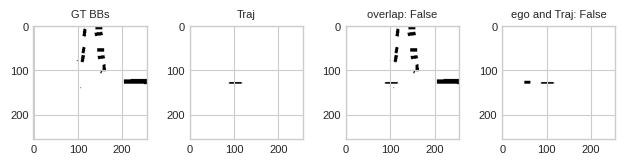

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

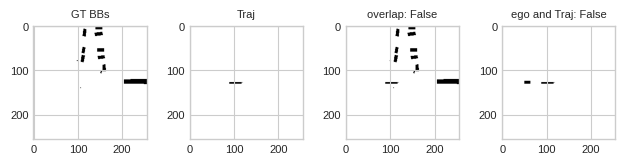

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

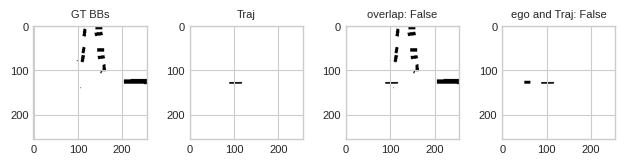

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

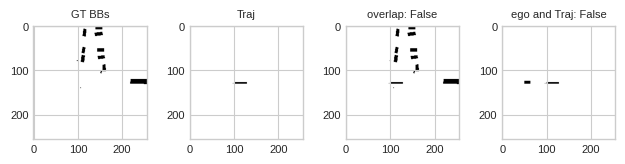

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

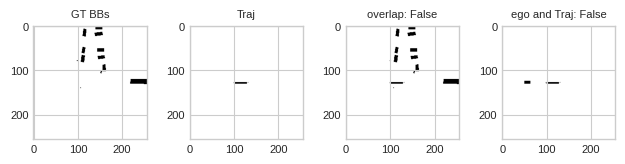

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

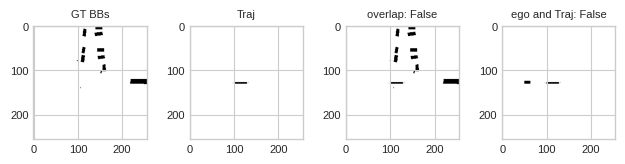

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

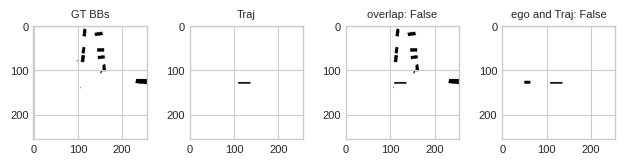

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

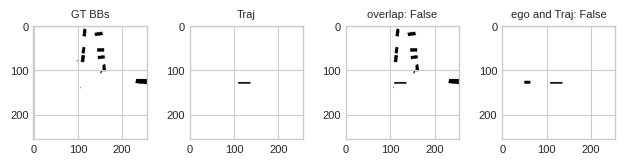

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

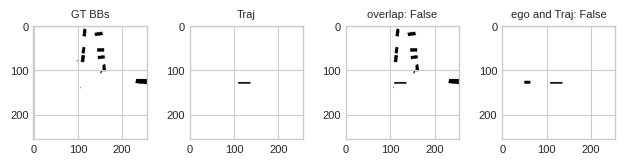

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

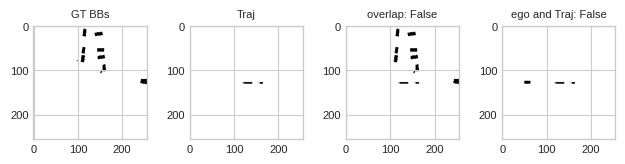

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

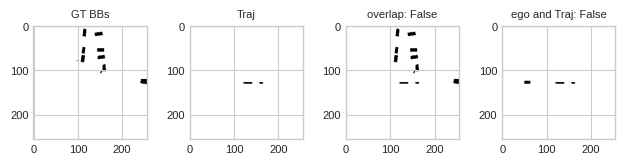

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

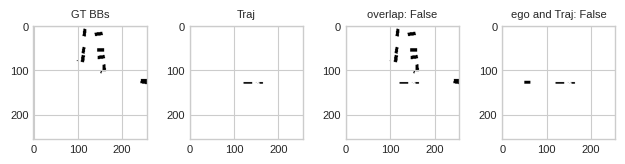

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

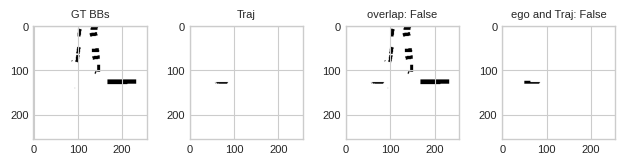

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

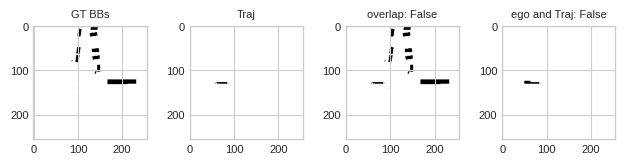

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

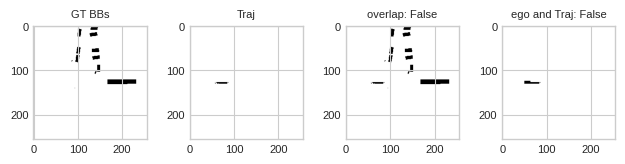

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

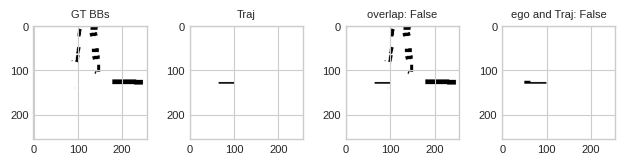

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

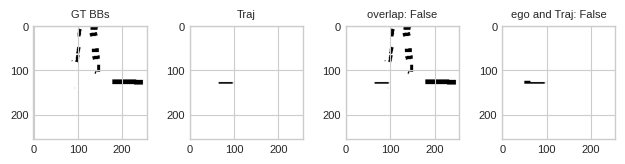

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

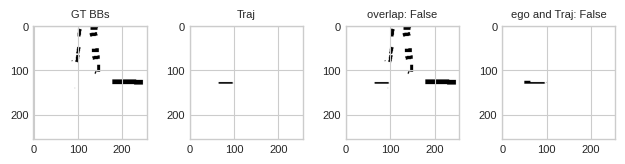

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

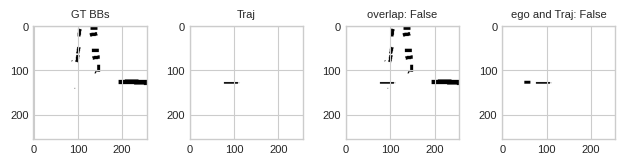

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

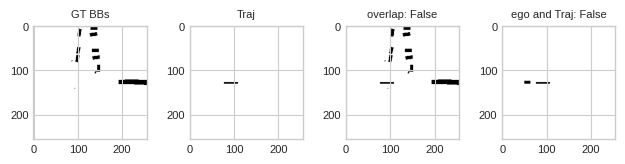

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

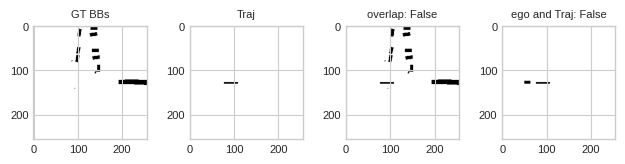

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

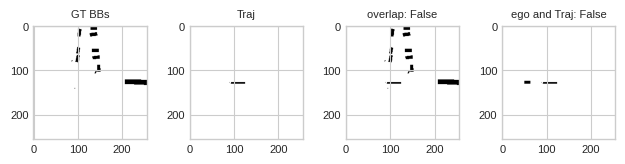

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

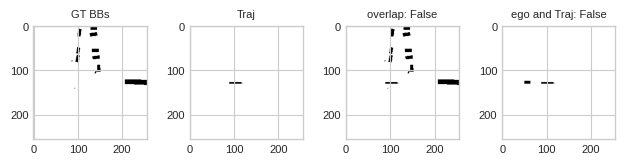

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

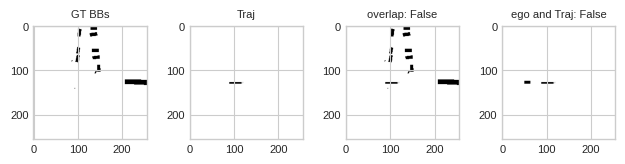

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

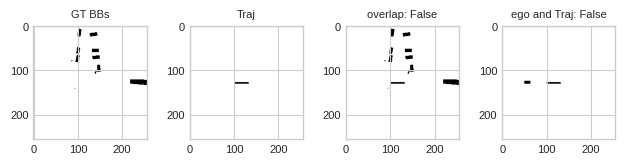

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

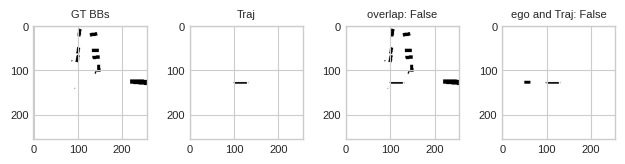

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

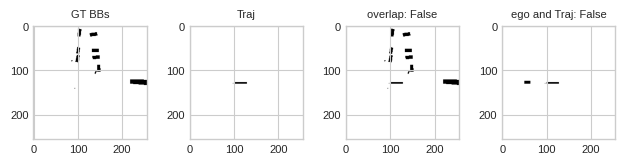

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

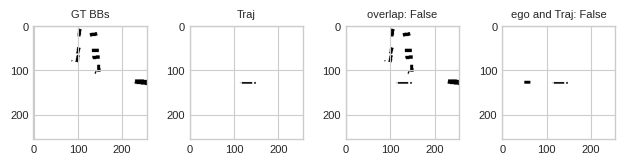

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

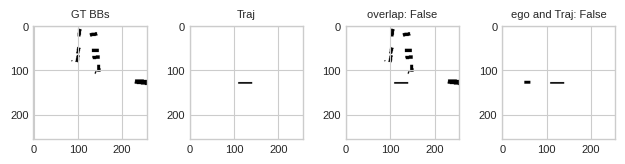

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

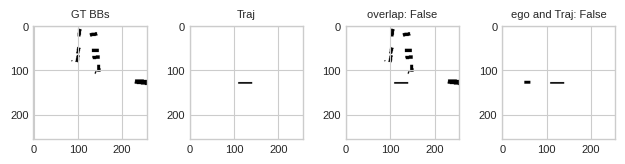

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

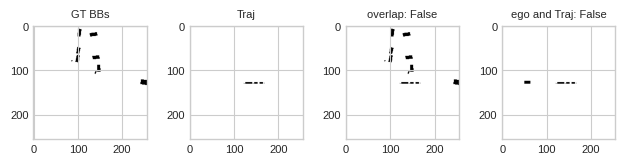

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

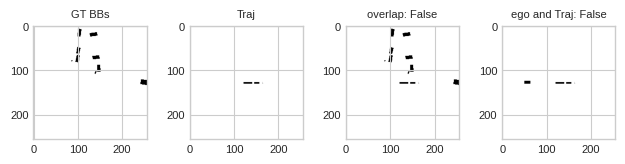

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

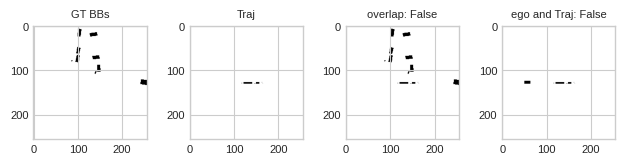

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

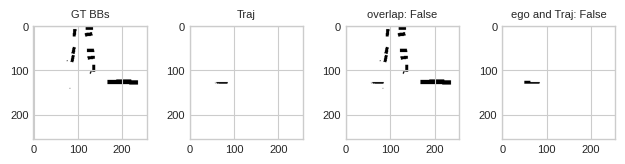

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

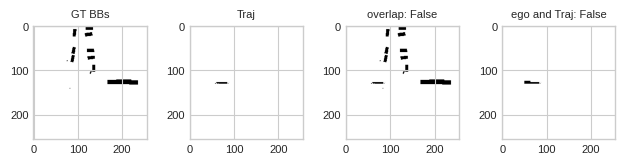

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

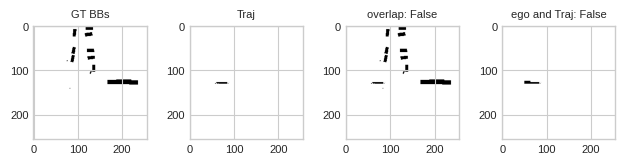

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

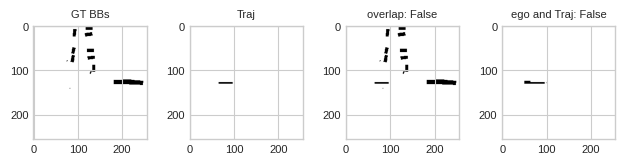

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

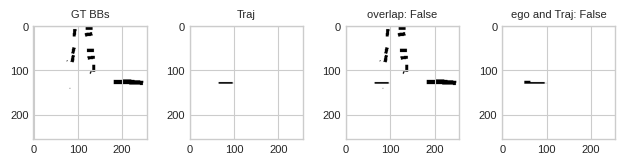

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

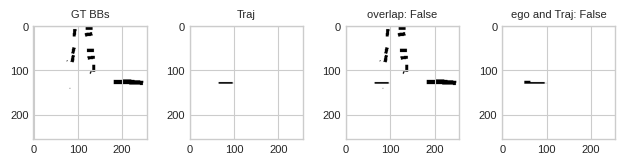

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

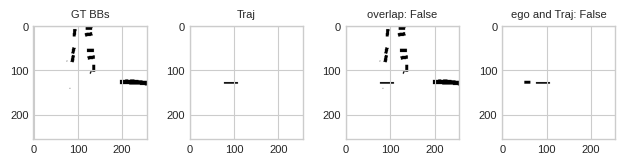

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

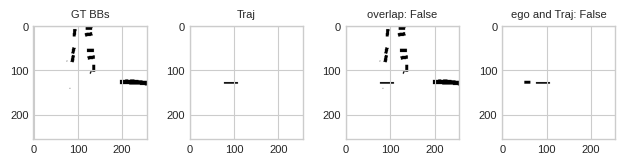

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

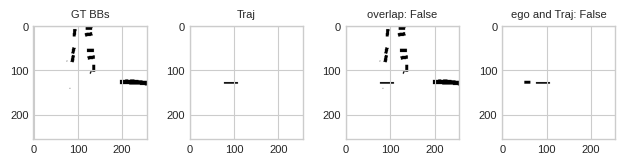

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

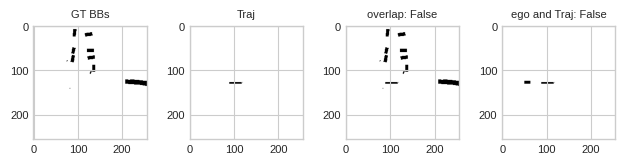

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

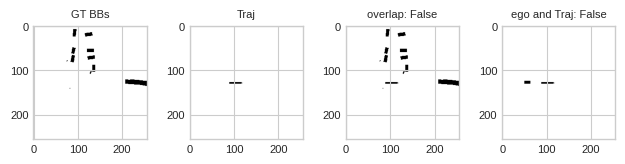

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

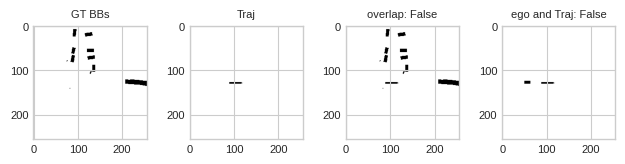

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

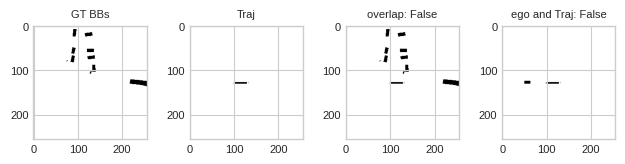

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

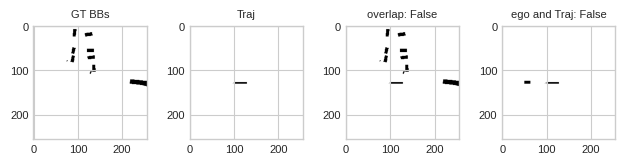

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

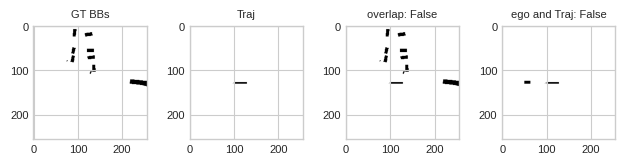

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

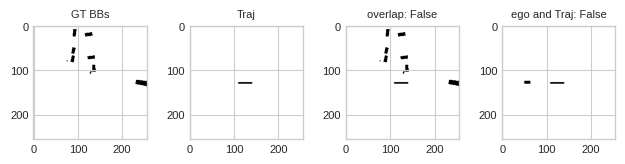

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

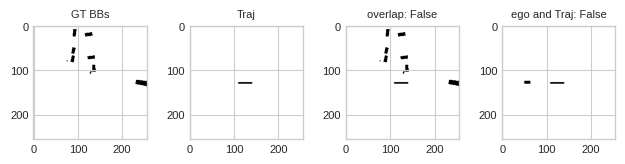

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

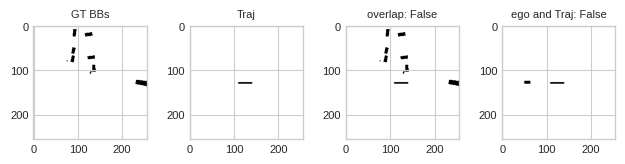

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

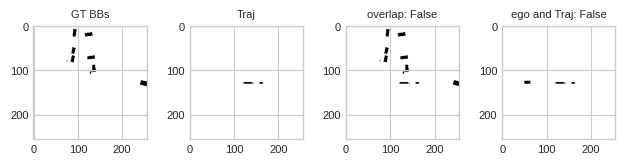

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

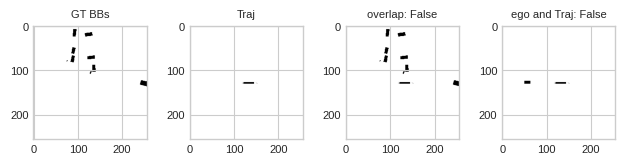

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

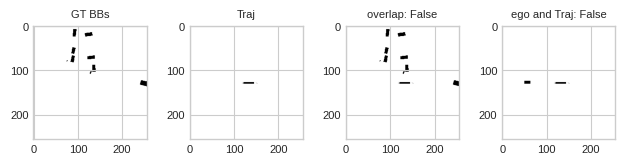

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

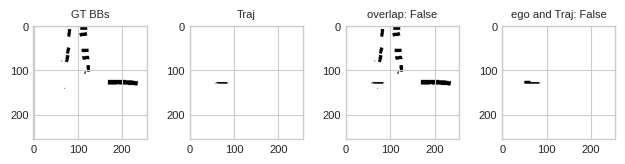

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

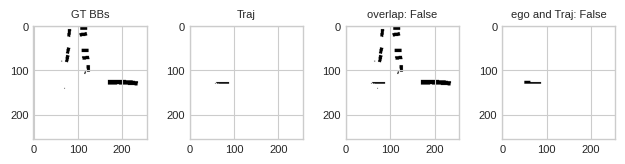

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

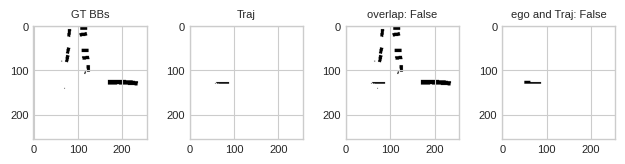

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

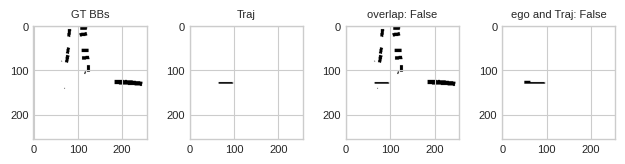

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

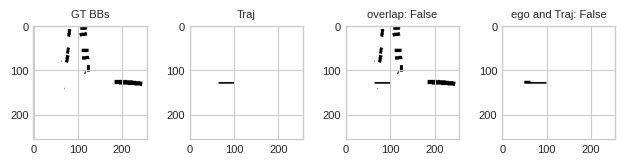

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

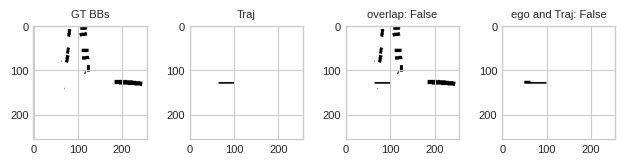

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

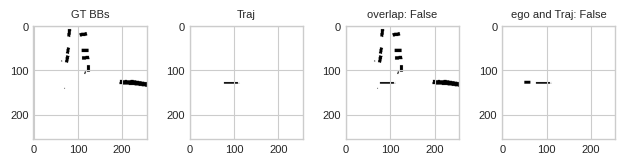

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

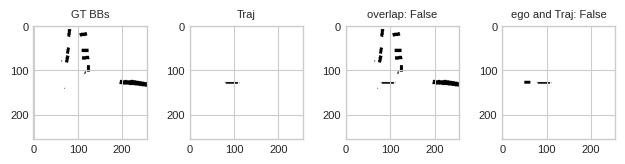

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

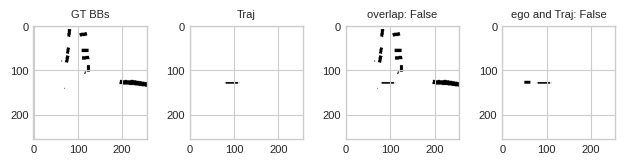

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

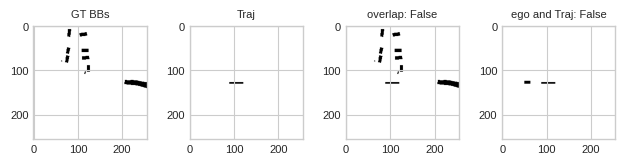

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

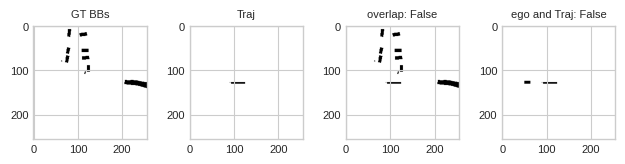

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

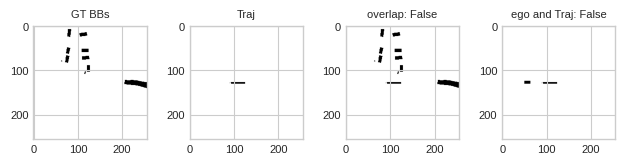

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

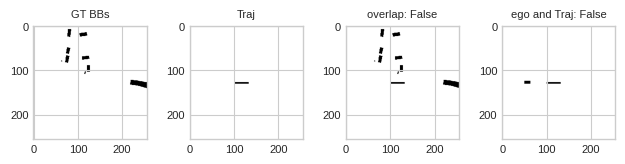

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

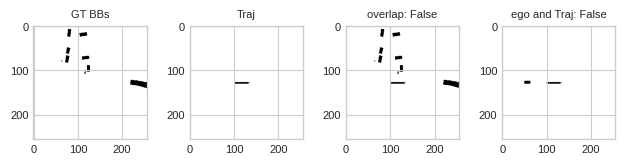

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

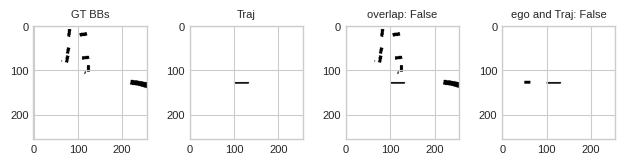

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

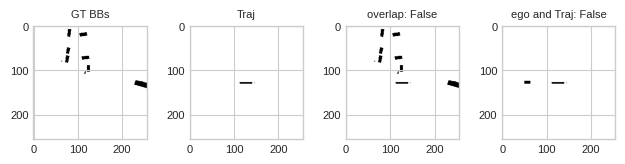

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

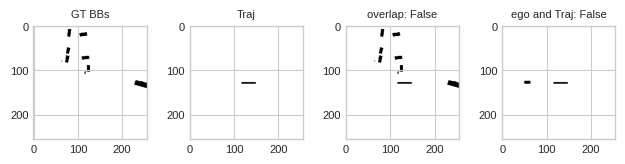

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

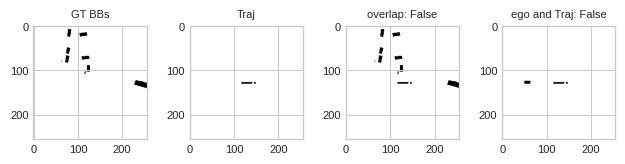

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

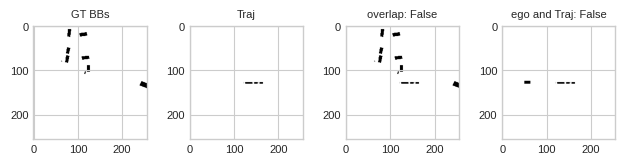

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

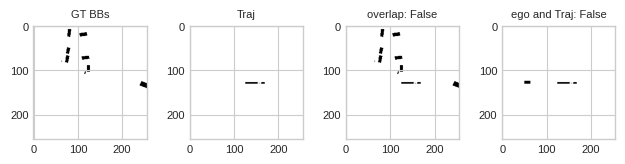

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

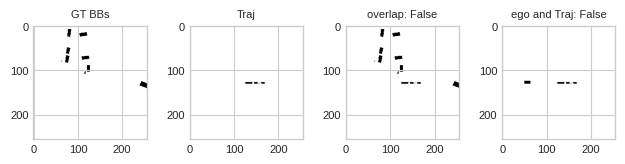

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

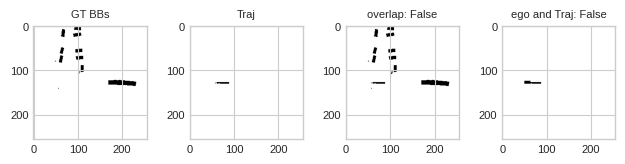

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

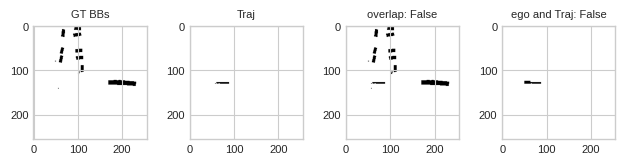

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

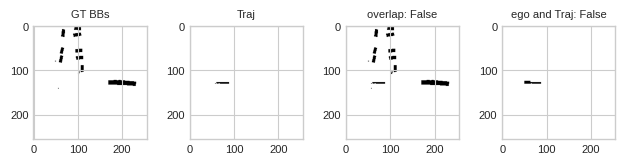

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

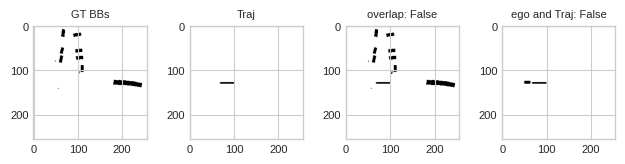

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

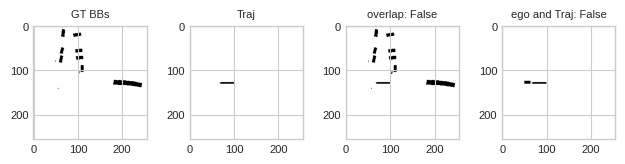

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

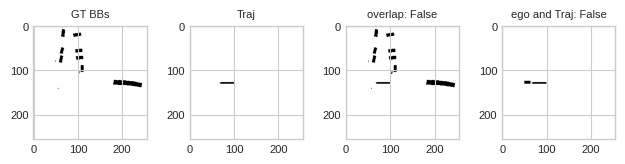

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

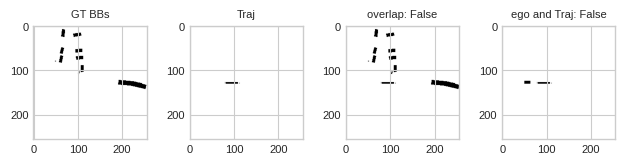

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

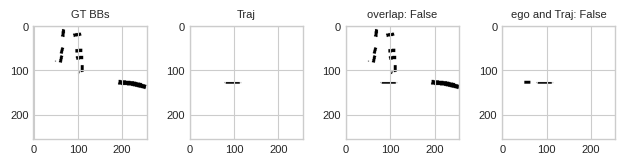

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

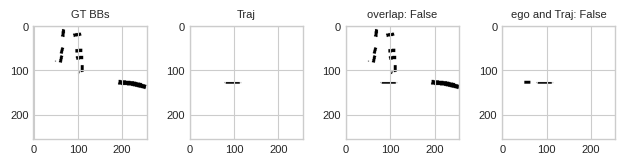

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

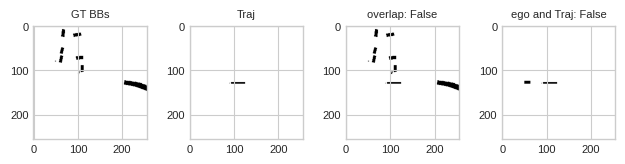

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

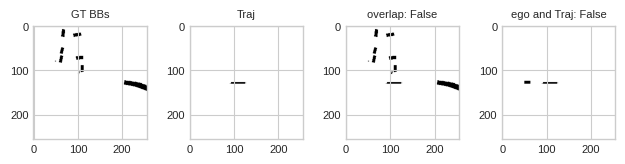

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

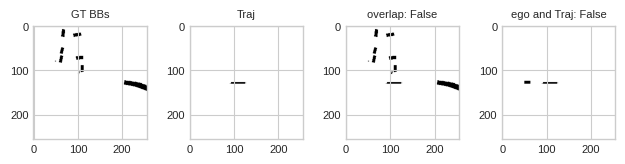

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

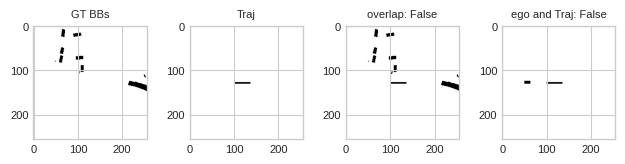

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

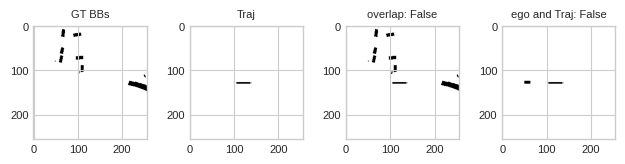

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

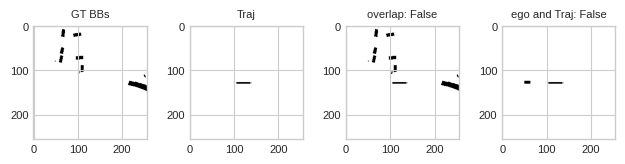

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

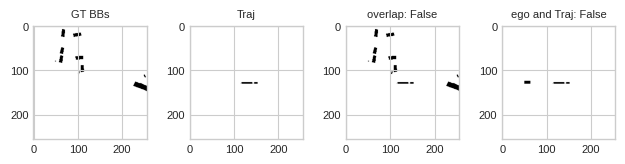

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

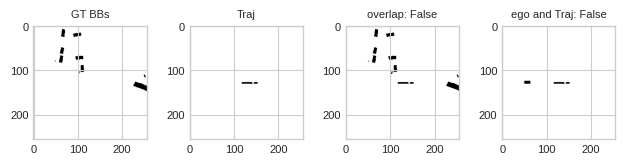

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

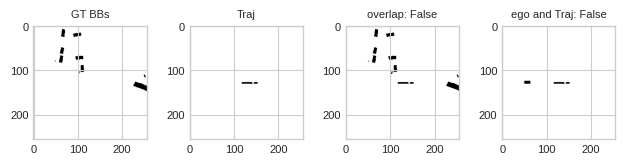

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

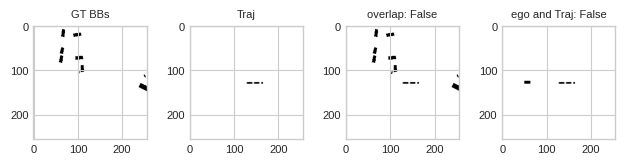

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

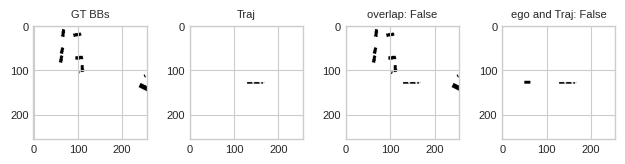

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

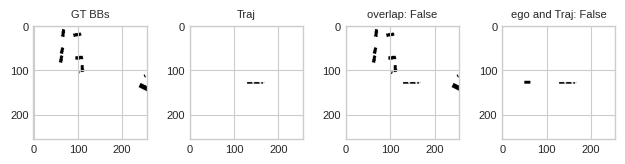

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

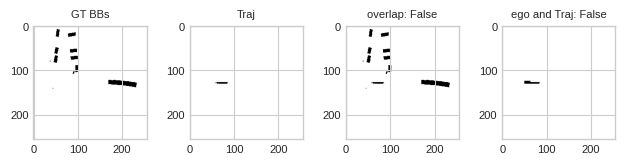

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

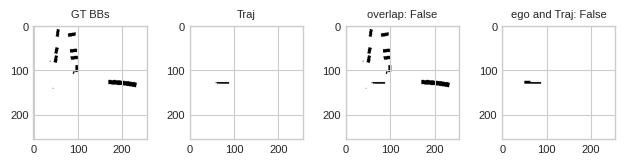

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

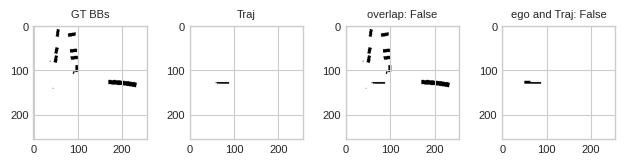

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

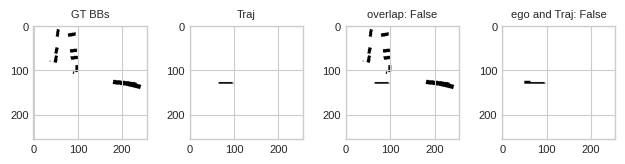

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

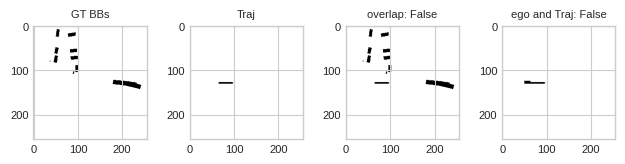

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

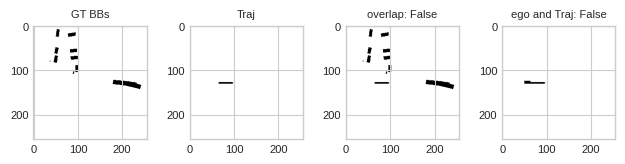

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

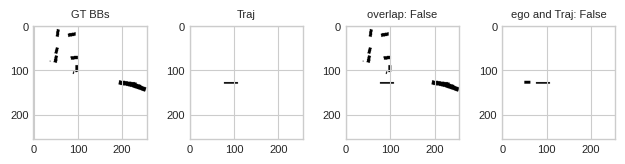

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

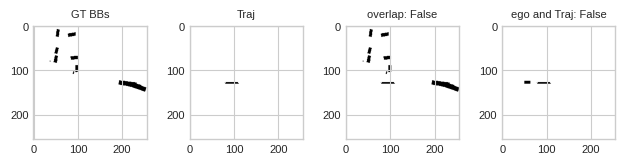

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

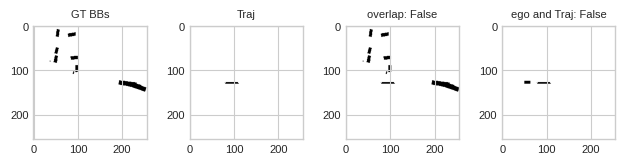

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

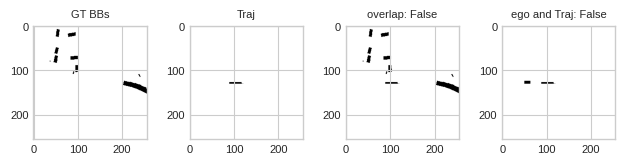

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

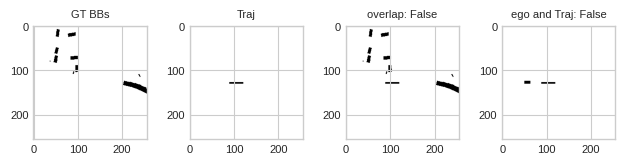

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

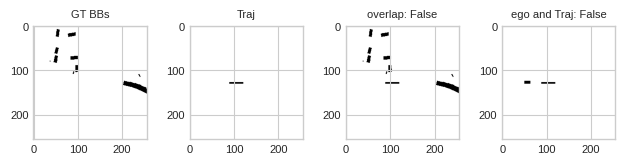

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

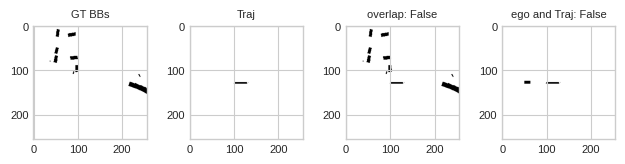

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

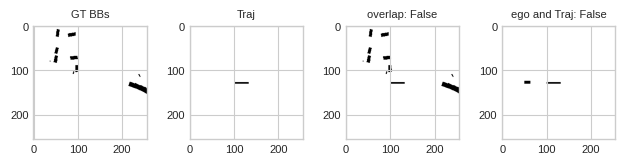

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

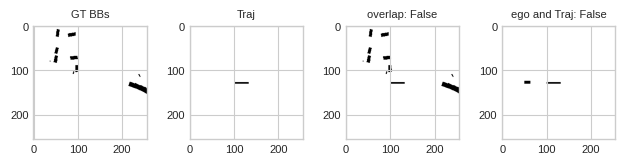

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

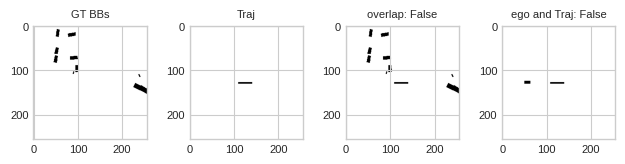

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

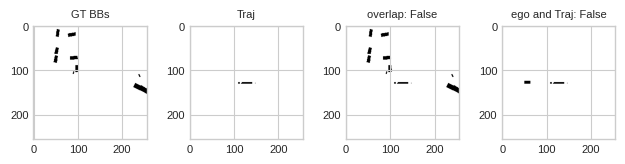

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

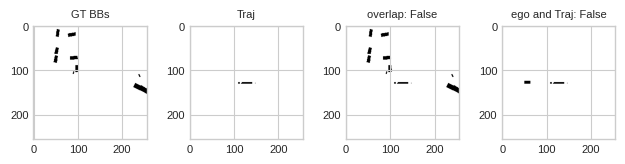

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

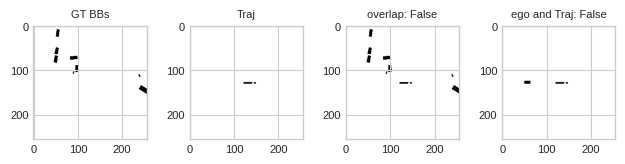

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

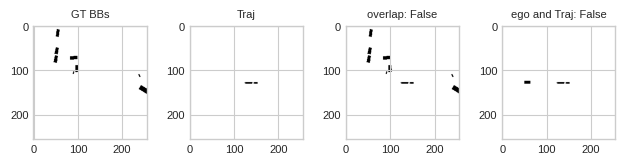

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

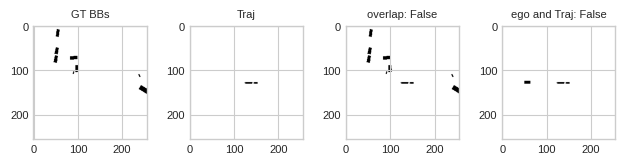

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

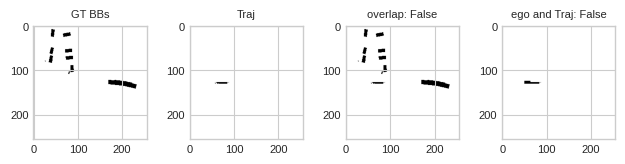

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

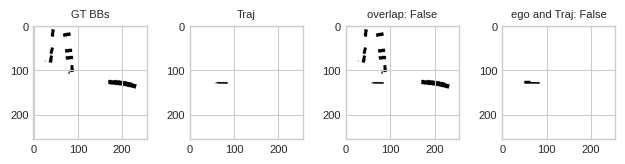

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

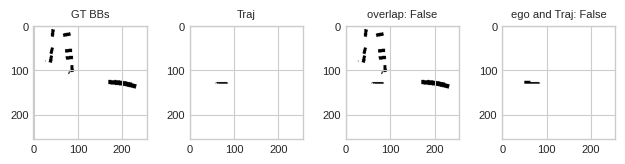

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

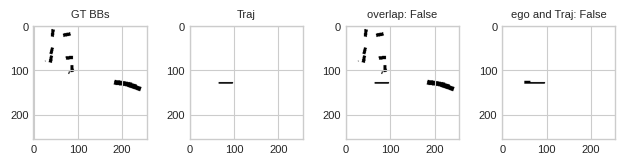

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

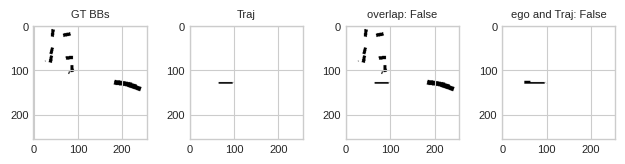

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

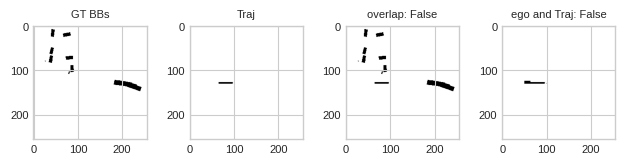

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

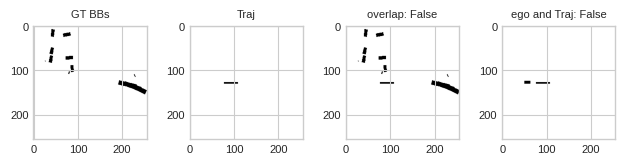

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

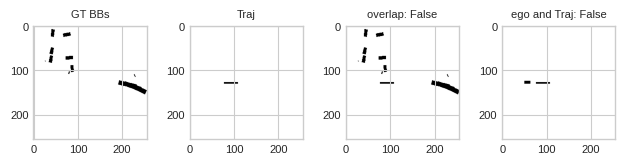

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

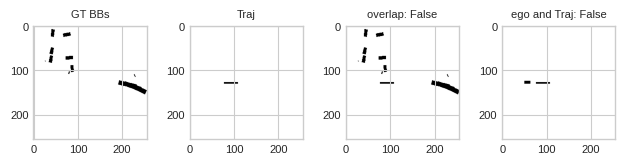

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

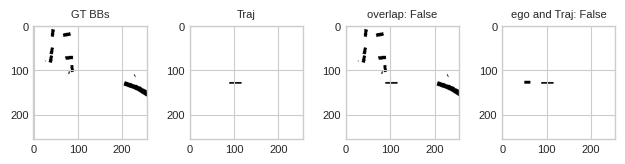

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

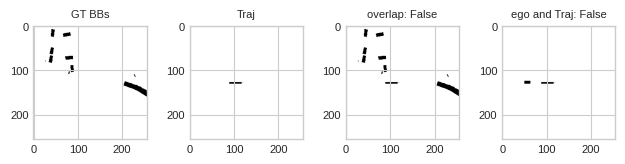

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

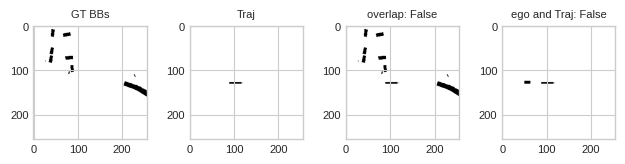

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

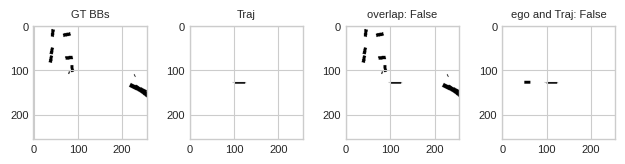

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

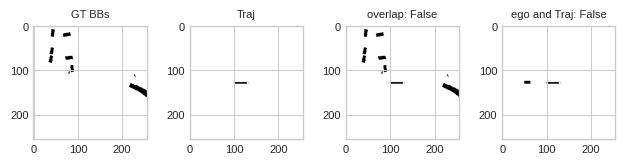

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

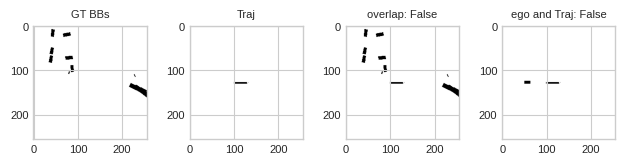

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

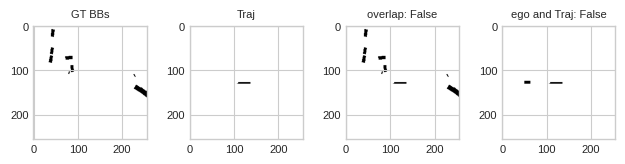

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

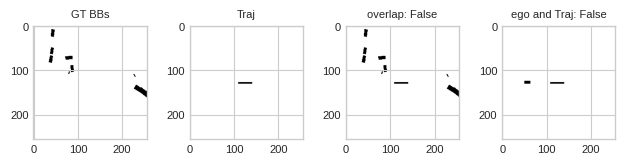

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

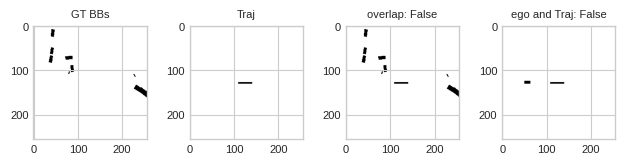

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

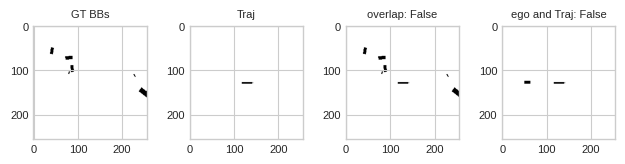

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

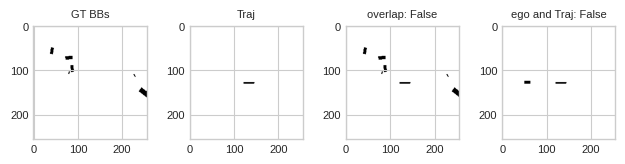

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

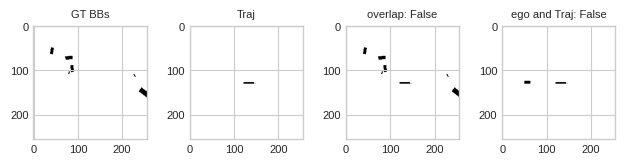

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

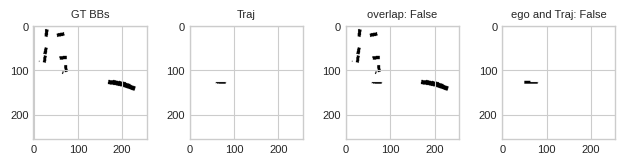

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

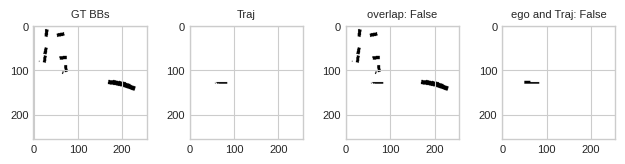

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

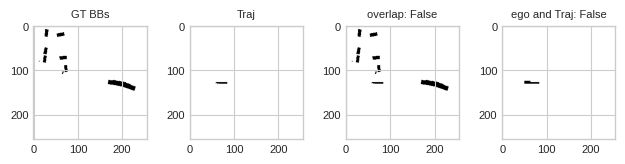

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

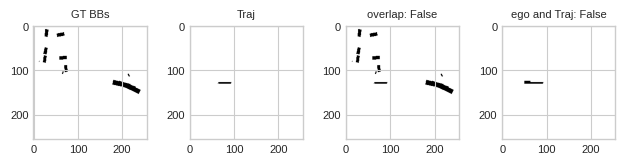

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

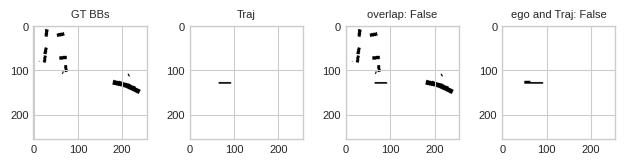

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

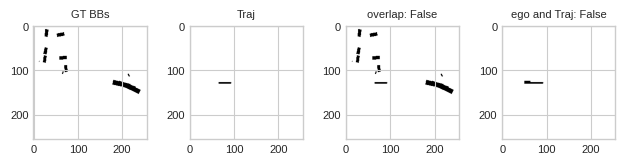

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

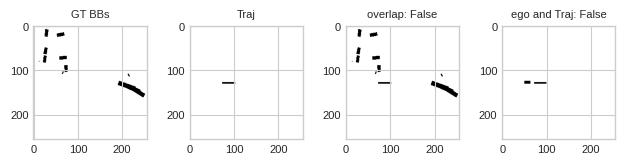

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

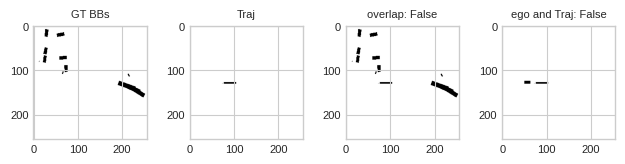

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

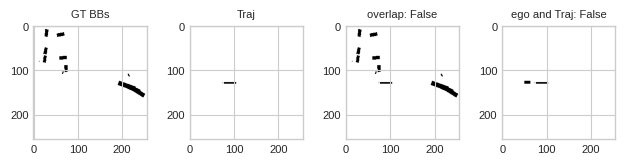

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

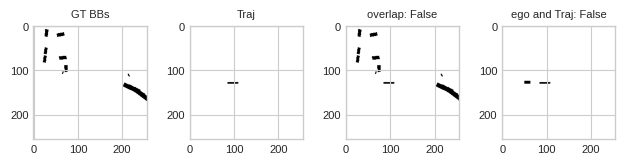

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

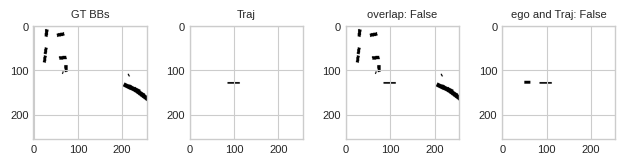

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

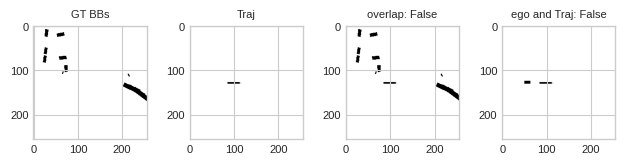

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

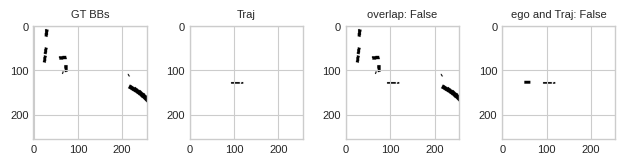

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

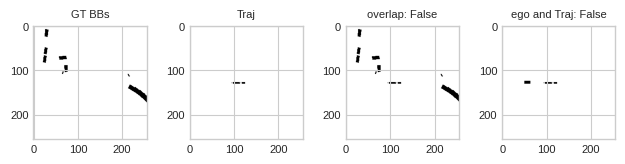

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

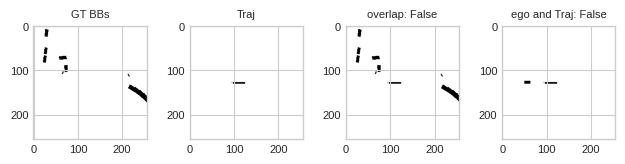

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

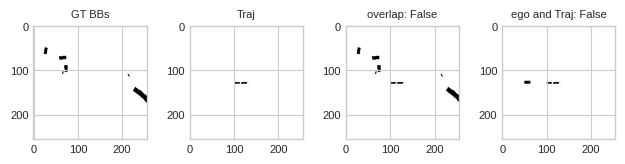

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

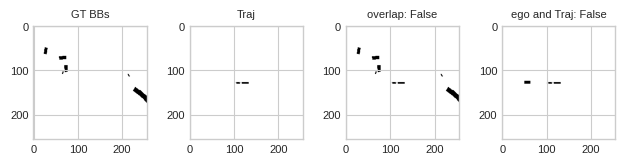

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

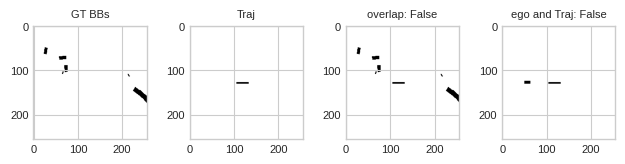

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

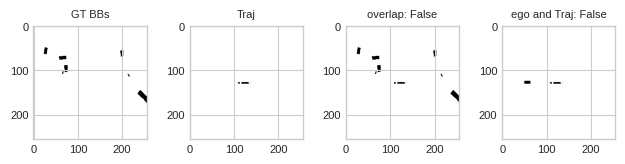

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

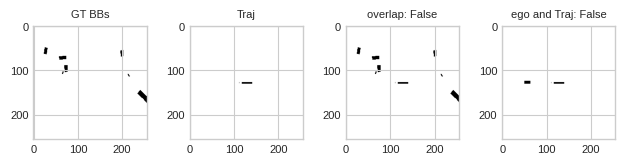

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

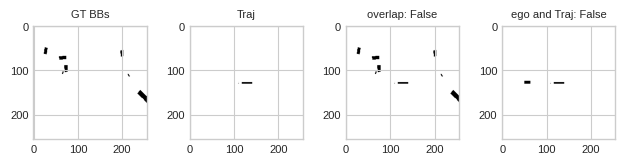

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

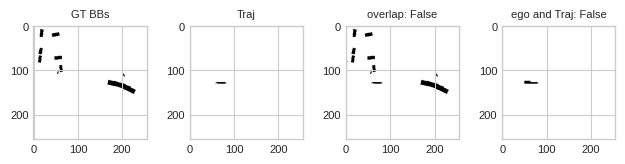

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

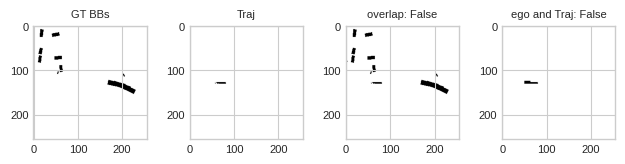

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

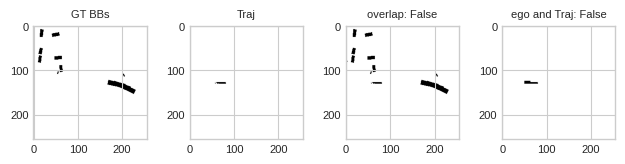

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

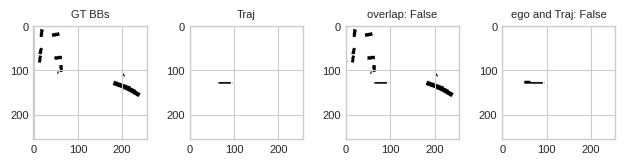

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

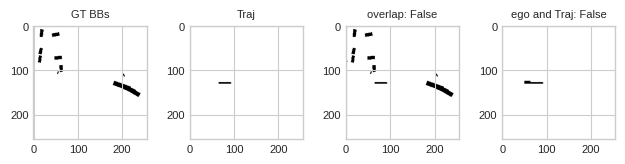

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

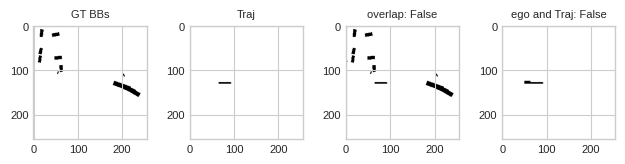

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

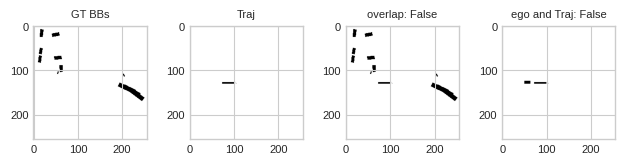

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

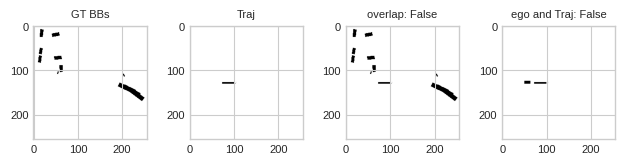

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

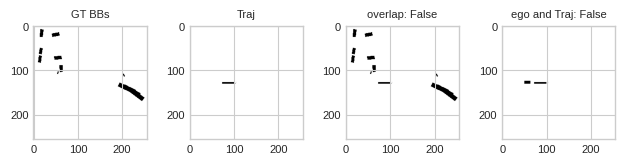

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

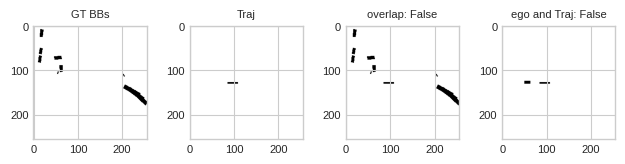

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

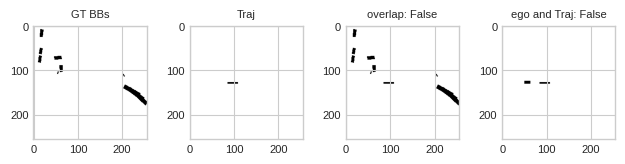

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

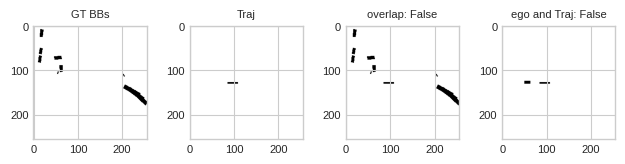

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

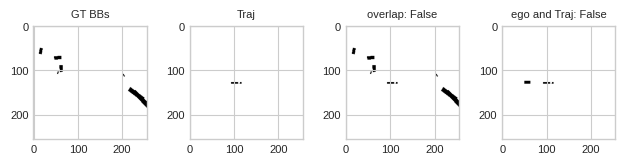

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

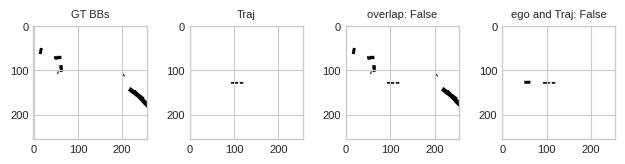

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

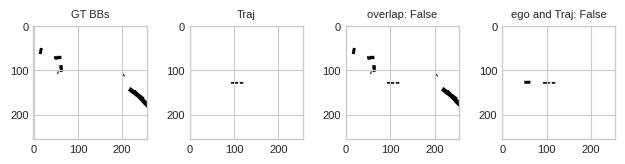

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

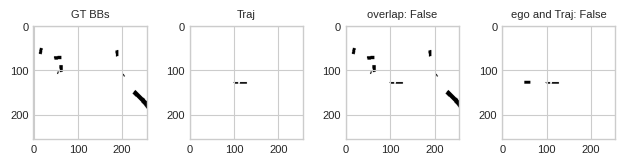

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

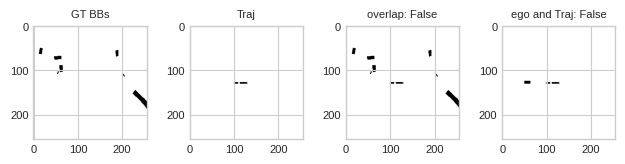

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

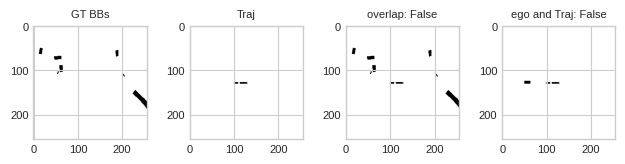

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

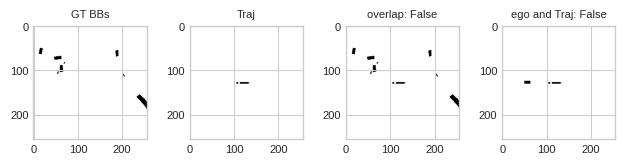

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

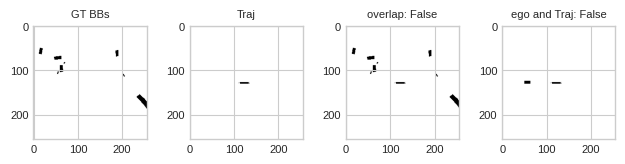

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

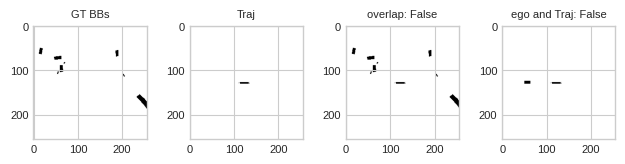

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

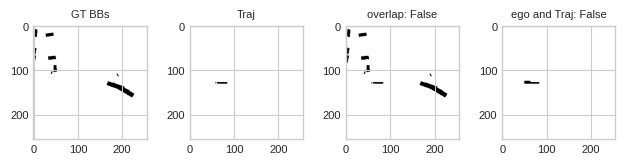

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

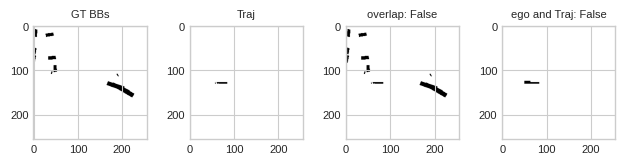

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

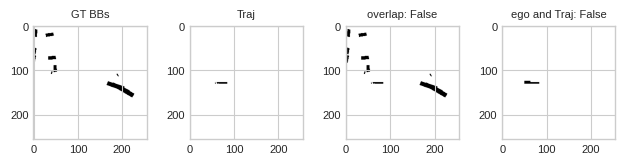

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

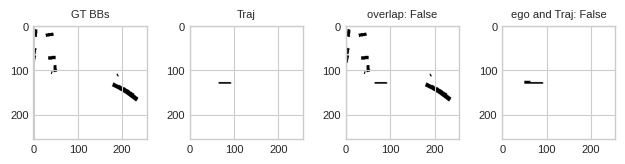

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

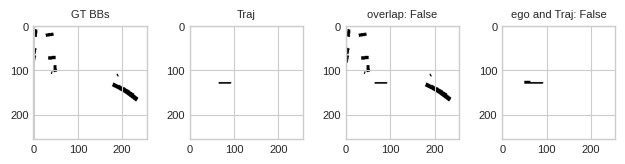

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

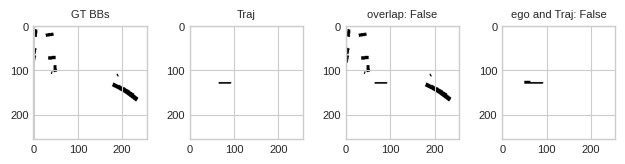

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

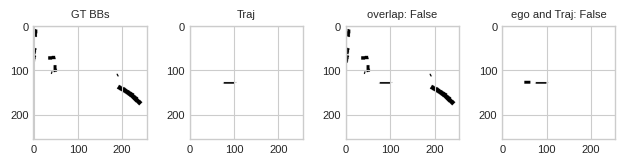

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

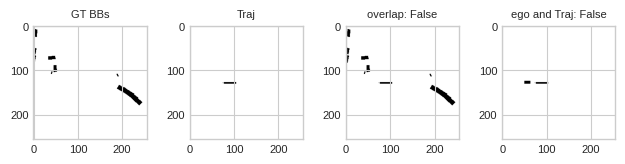

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

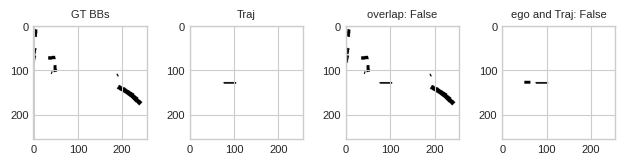

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

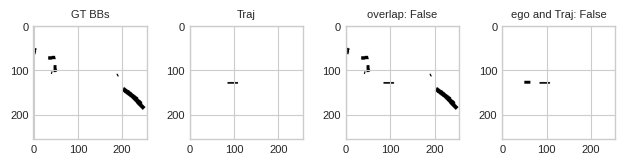

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

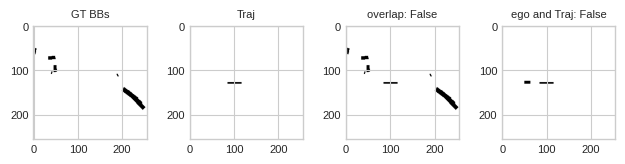

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

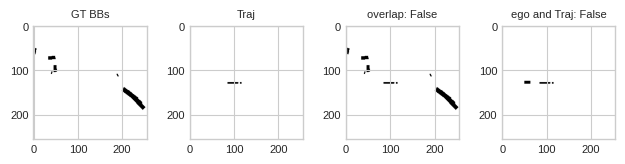

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

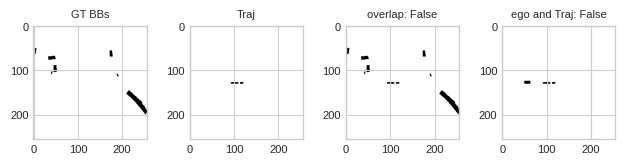

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

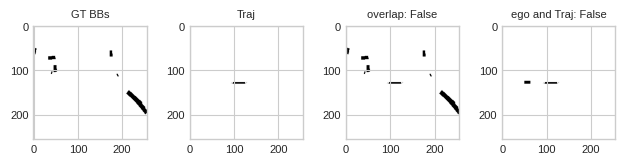

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

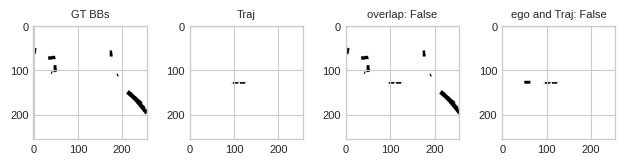

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

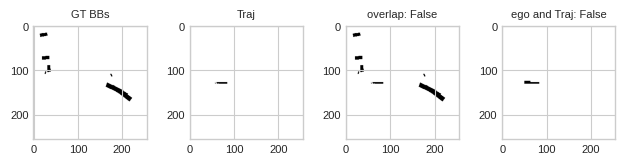

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

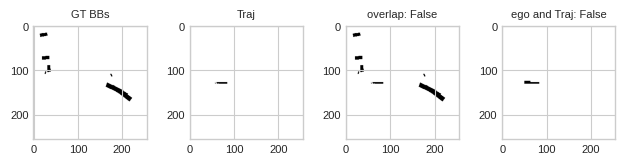

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

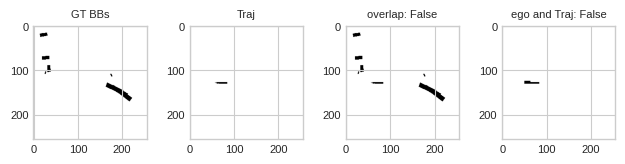

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

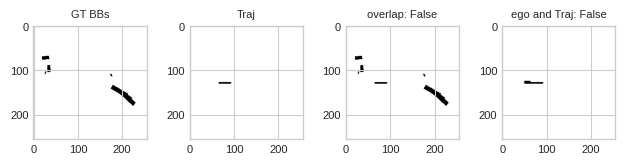

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

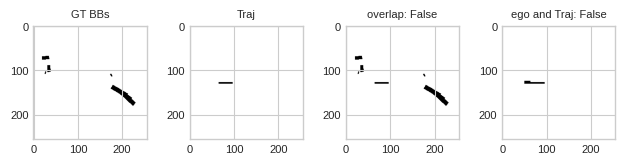

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

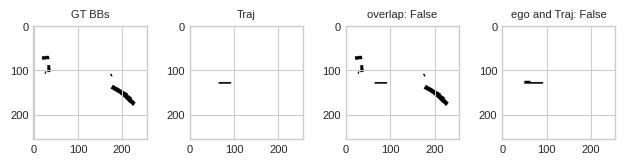

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

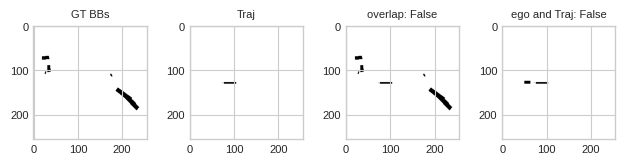

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

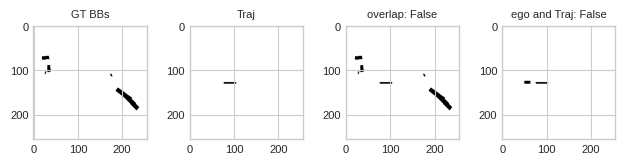

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

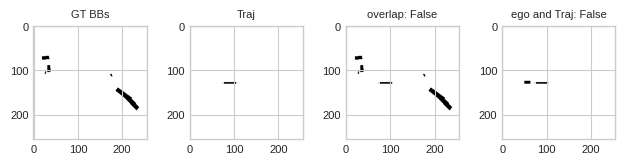

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

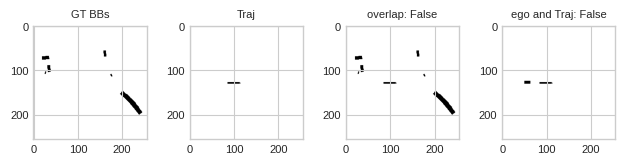

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

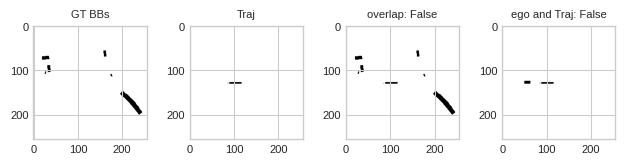

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

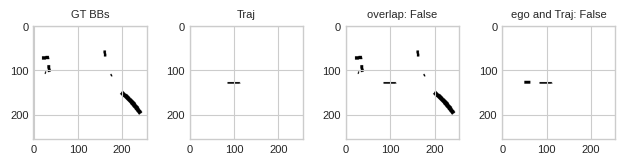

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

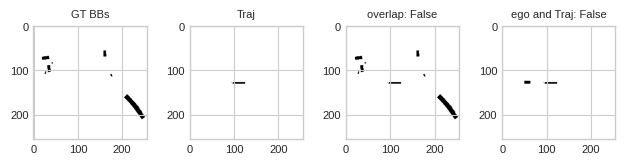

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

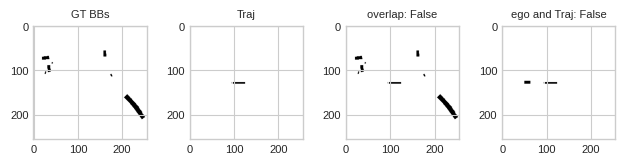

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

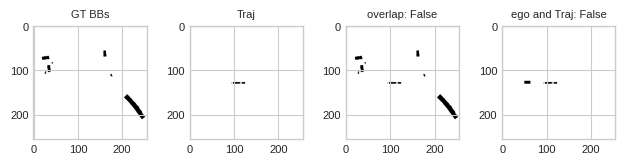

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

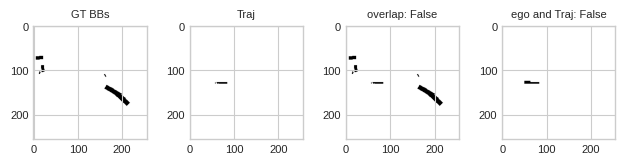

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

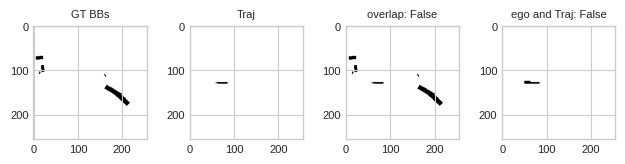

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

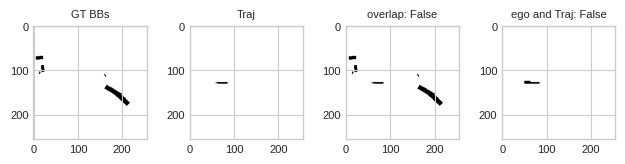

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

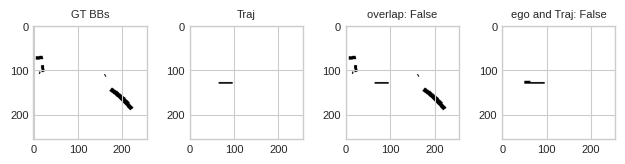

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

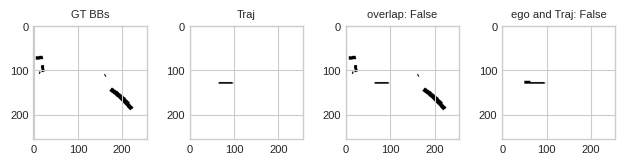

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

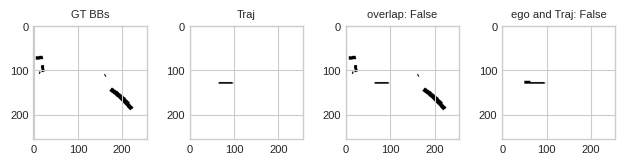

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

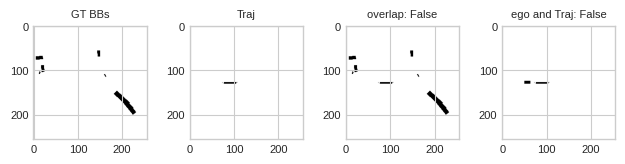

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

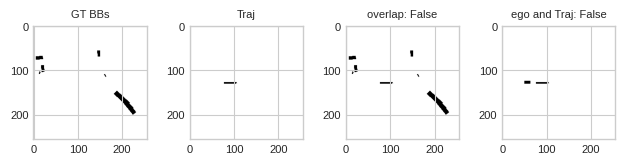

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

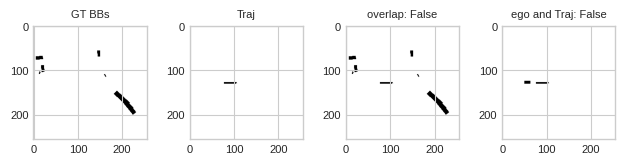

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

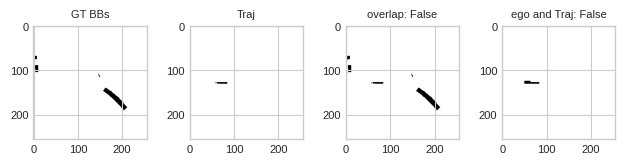

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

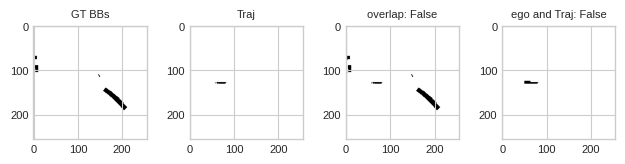

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

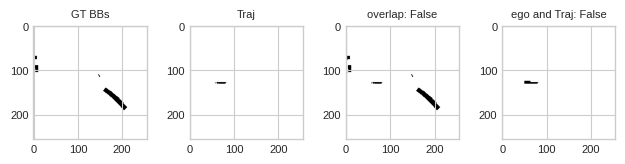

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

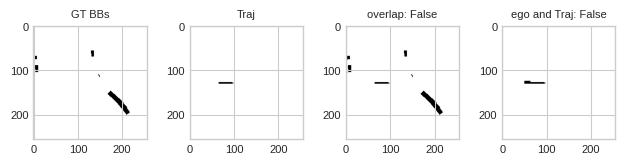

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

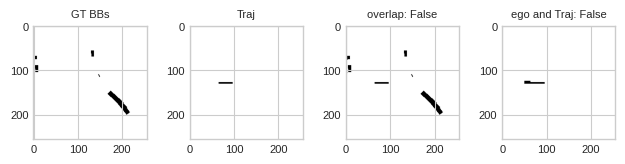

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

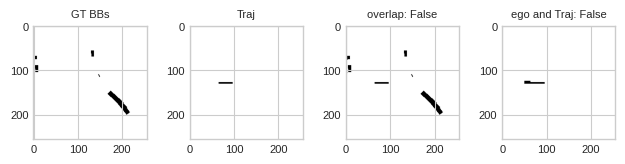

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

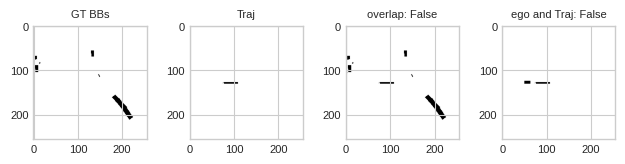

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

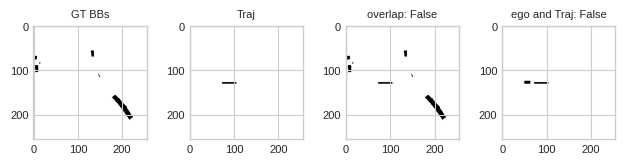

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

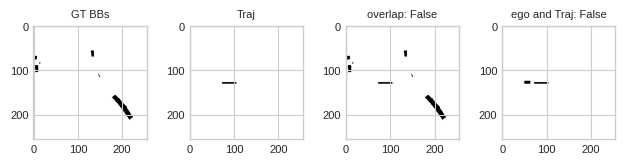

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

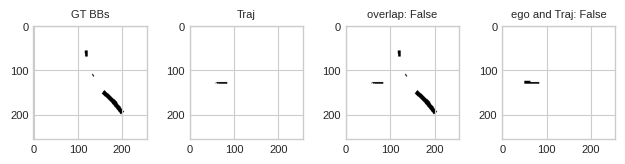

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

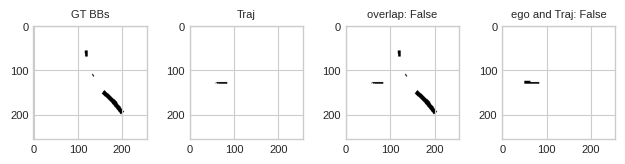

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

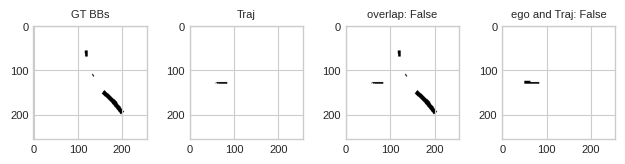

loading pkl model
loading pkl model


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

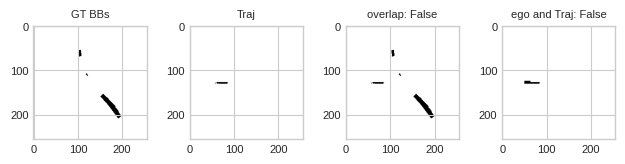

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

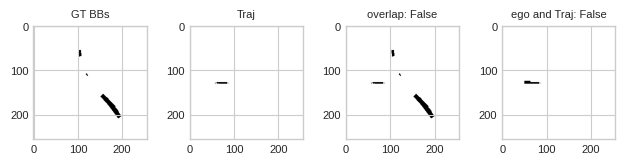

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

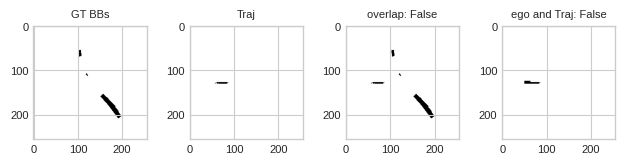

loading pkl model
loading pkl model


KeyboardInterrupt: 

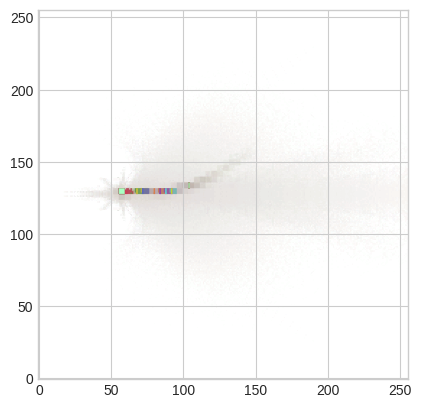

In [67]:
%matplotlib inline
#get the related sequence, to compute predictions number of images we have used in our validation
#first we get the my_sample with the reference selected_token
escape=0
dx,bx, (nx, ny) = get_grid([-17.0, -38.5, 60.0,38.5], [0.3, 0.3])
#dx,bx, (nx, ny) = get_grid([-34.0, -77, 120.0,77], [0.5, 0.5])
stretch=70 #120
layer_names = ['road_segment', 'lane']
line_names = ['road_divider', 'lane_divider']

for sequence in nuscenes_sequences:
    sequence_length=sequence['nbr_samples']
#    frames_can_use=sequence_length-(seconds*2) #remove the last 4 seconds, that are 8 frames
    current_frame=0
    token  = sequence['first_sample_token']
    while(current_frame < sequence_length): #from 0 to 39 frames, 20 seconds
        my_selected_sample = nuscenes.get('sample', token)
        if(current_frame >=31):
            seconds=math.floor((40-current_frame)/2)-1
        else:
            seconds=4
        tokens=get_following_tokens(seconds, token, my_selected_sample)
        
        pklfile_original, info_original, all_pkls_original, gtdist,preddist_original,gtxs, predxs_original, \
        createdimages_original, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=tokens,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=None, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(tokens),
                                     verbose=verbose);

        pklfile_dynamic, info_dynamic, all_pkls_dynamic, gtdist,preddist_dynamic,gtxs, predxs_dynamic, \
        createdimages_dynamic, gt_boxes, nusc_maps=dt.calc_sample_crit_GOAL3_visualization(listtoken=tokens,
                                     conf_th=basic_threshold,
                                     crit=basic_criticality,
                                     correction_factor=analyzed_correction_factor, #in this case, it is just the normal pkl
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     image_counter=len(tokens),
                                     verbose=verbose);

        #for the trajectory with the original and dynamic approach
        do_computation(tokens,
                            info_original, createdimages_original, 
                            info_dynamic, createdimages_dynamic,
                            dx,bx, nx, ny,stretch, 
                            nuscenes, nusc_maps, gt_boxes )
        
        current_frame=current_frame+1;
        token=my_selected_sample['next']